# Similar Neighborhoods in Downtown Toronto and Ville Marie

Do the necessary installations and most of the imports

In [1]:
# import Numerical and dataframe libraries
import numpy as np 
import pandas as pd 

# install libraries that I want to use that aren't installed by default
!conda install --yes -c conda-forge geopy folium=0.5.0 seaborn

from geopy.geocoders import Nominatim 

# import web service libraries
import requests 
import json 
from pandas.io.json import json_normalize 

# import Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


Import more of what is needed.

In [2]:
# import seaborn library (for improved plotting)
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

In [3]:
%matplotlib inline 

## Download and Explore Dataset about Montreal's Ville-Marie Borough

In [4]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

###### Define and use my IBM Cloud Object Storage credentials to access a file containing information about the borough. The file will be readable via the variable "body"

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
vc_postal_codes = pd.read_csv(body)
vc_postal_codes

,PostalCode,Neighborhood,AdditionalNeighborhoods
0,H2K,Centre-Sud North,Sainte-Marie
1,H2L,Centre-Sud South,Gay Village
2,H2X,Plateau Mont-Royal Southeast,Quartier Des Spectacles
3,H2Y,Old Montreal,Quartier International De Montréal
4,H2Z,Downtown Montreal Northeast,
5,H3A,Downtown Montreal North (McGill University),Golden Square Mile
6,H3B,Downtown Montreal East,
7,H3C,Griffintown (Includes Île Notre-Dame & Île Sai...,"Cité du Multimédia, Saint Helen's Island, Notr..."
8,H3G,Downtown Montreal Southeast (Concordia Univers...,
9,H3H,Downtown Montreal Southwest,"Shaughnessy Village, part of Mount Royal Park"


##### The Neighborhood column has data from the Wikipedia page for "H" postal codes. The AdditionalNeighborhoods column has information that I deduced from Wikipedia and Google Maps. Combine them into one column

In [7]:
nbhd1 = vc_postal_codes["Neighborhood"].str.strip()
anbhd = vc_postal_codes["AdditionalNeighborhoods"].str.strip()

##### Make a series that has the two neighborhood columns combined

In [8]:
nbhds = nbhd1.str.cat(anbhd, sep=', ')
nbhds = nbhds.str.strip() # Remove blanks at ends of lines
nbhds = nbhds.str.strip(',') # Remove commas at ends of lines

##### Make a dataframe that has the postal codes with their neighborhood or neighborhoods

In [9]:
vc_postal_codes_combined = pd.DataFrame({"PostalCode": vc_postal_codes["PostalCode"],  "Neighborhood": nbhds})

###### Define and use my IBM Cloud Object Storage credentials to access a file containing information about the longitude and latitude of each postal code
The file will be readable via the variable "body2"

In [10]:
body2 = client_4ece76dbd54043419b2adab621f7ac29.get_object(Bucket='capstoneweek4-donotdelete-pr-rnhzmrilf46wdj',
                                                           Key='VilleMarieCoords.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body2, "__iter__"): body2.__iter__ = types.MethodType( __iter__, body )

coords_1 = pd.read_csv(body2)
coords_1

,PostalCode,CoordsFromGoogle
0,H2K,"45.5302° N, 73.5527° W"
1,H2L,"45.5222° N, 73.5641° W"
2,H2X,"45.5133° N, 73.5694° W"
3,H2Y,"45.5052° N, 73.5557° W"
4,H2Z,"45.5039° N, 73.5632° W"
5,H3A,"45.5035° N, 73.5769° W"
6,H3B,"45.4999° N, 73.5689° W"
7,H3C,"45.4928° N, 73.5614° W"
8,H3G,"45.4995° N, 73.5826° W"
9,H3H,"45.5027° N, 73.5958° W"


##### Split the strings that were copied from Google into strings for latitude and longitude

In [11]:
coords_split = coords_1["CoordsFromGoogle"].str.split(",")

##### Put the strings for latitude into one Series and the strings for longitude into a different Series

In [12]:
[lat, lon] = [coords_split.str[i] for i in range(2)]

##### Convert the strings into the corresponding floating-point numbers

In [13]:
# Convert the latitudes into positive numbers
lat1 = lat.str.replace(". N *", "").astype(float)
# Convert the longitudes into negative numbers, since West latitudes are negative numbers for mapping
lon1 = -(lon.str.replace(". W *", "").astype(float))

####  Make a dataframe with the postal codes, latitudes and longitudes

In [14]:
coords_2 = pd.DataFrame({"PostalCode": coords_1["PostalCode"], "Latitude": lat1, "Longitude": lon1})

#### Join two data frames to add the coordinates to the neighborhood data

In [15]:
combined_postal = pd.merge(vc_postal_codes_combined, coords_2, left_on="PostalCode", right_on="PostalCode", validate="1:1")
combined_postal

,PostalCode,Neighborhood,Latitude,Longitude
0,H2K,"Centre-Sud North, Sainte-Marie",45.5302,-73.5527
1,H2L,"Centre-Sud South, Gay Village",45.5222,-73.5641
2,H2X,"Plateau Mont-Royal Southeast, Quartier Des Spe...",45.5133,-73.5694
3,H2Y,"Old Montreal, Quartier International De Montréal",45.5052,-73.5557
4,H2Z,Downtown Montreal Northeast,45.5039,-73.5632
5,H3A,"Downtown Montreal North (McGill University), G...",45.5035,-73.5769
6,H3B,Downtown Montreal East,45.4999,-73.5689
7,H3C,Griffintown (Includes Île Notre-Dame & Île Sai...,45.4928,-73.5614
8,H3G,Downtown Montreal Southeast (Concordia Univers...,45.4995,-73.5826
9,H3H,"Downtown Montreal Southwest, Shaughnessy Villa...",45.5027,-73.5958


### Explore Neighborhoods in Ville-Marie

In [16]:
# Find the latitude and longitude of the center of the map by finding the latitude and longitude that are the midpoints of the ranges of the latitude and the longitude
latitude = (combined_postal.loc[:,"Latitude"].min() + combined_postal.loc[:,"Latitude"].max()) / 2
longitude = (combined_postal.loc[:,"Longitude"].min() + combined_postal.loc[:,"Longitude"].max()) / 2
print('The geograpical coordinates of Ville-Marie are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Ville-Marie are 45.5115, -73.57425.


In [17]:
# create map of Ville-Marie using latitude and longitude values
map_vm = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(combined_postal['Latitude'], combined_postal['Longitude'], 
                                           combined_postal['PostalCode'], combined_postal['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough) 
    label = folium.Popup(label, parse_html=True) 
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_vm)
    
map_vm

### Analyze Each Set of Neighborhood (based on Postal Code) in Ville-Marie

##### Define Foursquare Credentials

In [18]:
# The code was removed by Watson Studio for sharing.

##### Define Foursquare Version and other constants

In [19]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500

##### From the Foursquare lab in the 2nd module, we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.¶

In [20]:
# function that extracts the category of the venue 
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0: 
        return None
    else:
        return categories_list[0]['name']

##### Let's borrow another function used previously

In [21]:
# Create a function to repeat the same process for all the neighborhoods in Downtown Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

###### Use the above function on each neighborhood and create a new dataframe called vm_venues.

In [22]:
vm_venues = getNearbyVenues(names=combined_postal['Neighborhood'],
                                     latitudes=combined_postal['Latitude'],
                                     longitudes=combined_postal['Longitude']
                                    )

Centre-Sud North, Sainte-Marie
Centre-Sud South, Gay Village
Plateau Mont-Royal Southeast, Quartier Des Spectacles
Old Montreal, Quartier International De Montréal
Downtown Montreal Northeast
Downtown Montreal North (McGill University), Golden Square Mile
Downtown Montreal East
Griffintown (Includes Île Notre-Dame & Île Sainte-Hélène) (Université de Montréal), Cité du Multimédia, Saint Helen's Island, Notre Dame Island
Downtown Montreal Southeast (Concordia University)
Downtown Montreal Southwest, Shaughnessy Village, part of Mount Royal Park


In [23]:
print(vm_venues.shape)
vm_venues.head()

(580, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Centre-Sud North, Sainte-Marie",45.5302,-73.5527,Wawel,45.532925,-73.552444,Bakery
1,"Centre-Sud North, Sainte-Marie",45.5302,-73.5527,Espace Libre,45.530336,-73.554078,Performing Arts Venue
2,"Centre-Sud North, Sainte-Marie",45.5302,-73.5527,CrossFit CapOp,45.530719,-73.557649,Gym
3,"Centre-Sud North, Sainte-Marie",45.5302,-73.5527,Le Gourmandin,45.530709,-73.554887,Ice Cream Shop
4,"Centre-Sud North, Sainte-Marie",45.5302,-73.5527,Bistro sur la Rivière,45.530918,-73.557474,French Restaurant


##### How many venues were returned for each neighborhood?

In [24]:
vm_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Centre-Sud North, Sainte-Marie",22,22,22,22,22,22
"Centre-Sud South, Gay Village",20,20,20,20,20,20
Downtown Montreal East,100,100,100,100,100,100
"Downtown Montreal North (McGill University), Golden Square Mile",62,62,62,62,62,62
Downtown Montreal Northeast,100,100,100,100,100,100
Downtown Montreal Southeast (Concordia University),45,45,45,45,45,45
"Downtown Montreal Southwest, Shaughnessy Village, part of Mount Royal Park",4,4,4,4,4,4
"Griffintown (Includes Île Notre-Dame & Île Sainte-Hélène) (Université de Montréal), Cité du Multimédia, Saint Helen's Island, Notre Dame Island",36,36,36,36,36,36
"Old Montreal, Quartier International De Montréal",100,100,100,100,100,100


#### How many unique categories can be curated from all the returned venues?

In [25]:
print('There are {} uniques categories.'.format(len(vm_venues['Venue Category'].unique())))

There are 157 uniques categories.


#### Do more detailed analysis

In [26]:
# one hot encoding
vm_onehot = pd.get_dummies(vm_venues[['Venue Category']], prefix="", prefix_sep="")


vm_onehot = pd.merge(vm_onehot.copy(), vm_venues[['Neighborhood']], left_index=True, right_index=True, validate="1:1")
# move neighborhood column to the first column
fixed_columns = [vm_onehot.columns[-1]] + list(vm_onehot.columns[:-1])
vm_onehot = vm_onehot[fixed_columns]

vm_onehot.head()

,Neighborhood_y,Arepa Restaurant,Art Museum,Arts & Entertainment,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,...,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Centre-Sud North, Sainte-Marie",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Centre-Sud North, Sainte-Marie",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Centre-Sud North, Sainte-Marie",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Centre-Sud North, Sainte-Marie",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Centre-Sud North, Sainte-Marie",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Let's look at the shape

In [27]:
vm_onehot.shape

(580, 158)

#### Let's group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [28]:
vmg = vm_onehot.groupby(['Neighborhood_y'])
vm_grouped = vmg.mean().reset_index()
vm_grouped

,Neighborhood_y,Arepa Restaurant,Art Museum,Arts & Entertainment,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,...,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Centre-Sud North, Sainte-Marie",0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.00,0.000000,0.000000
1,"Centre-Sud South, Gay Village",0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2,Downtown Montreal East,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,...,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.00,0.000000,0.010000
3,"Downtown Montreal North (McGill University), G...",0.000000,0.016129,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.016129,0.016129,0.000000,0.00,0.016129,0.016129
4,Downtown Montreal Northeast,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.030000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.000000,0.030000,0.000000,0.00,0.000000,0.020000
5,Downtown Montreal Southeast (Concordia Univers...,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,...,0.022222,0.022222,0.000000,0.000000,0.000000,0.022222,0.000000,0.00,0.022222,0.022222
6,"Downtown Montreal Southwest, Shaughnessy Villa...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
7,Griffintown (Includes Île Notre-Dame & Île Sai...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.027778,0.027778,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,"Old Montreal, Quartier International De Montréal",0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,...,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.010000,0.01,0.010000,0.010000
9,"Plateau Mont-Royal Southeast, Quartier Des Spe...",0.010989,0.000000,0.000000,0.010989,0.021978,0.010989,0.021978,0.000000,0.054945,...,0.000000,0.010989,0.021978,0.010989,0.000000,0.032967,0.010989,0.00,0.000000,0.010989


##### Let's confirm the new size

In [29]:
vm_grouped.shape

(10, 158)

#### Let's print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in vm_grouped['Neighborhood_y']:
    print("----"+hood+"----")
    temp = vm_grouped[vm_grouped['Neighborhood_y'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Centre-Sud North, Sainte-Marie----
               venue  freq
0  French Restaurant  0.14
1        Coffee Shop  0.14
2               Park  0.14
3     Sandwich Place  0.09
4     Ice Cream Shop  0.05


----Centre-Sud South, Gay Village----
                      venue  freq
0                Restaurant  0.10
1  Bike Rental / Bike Share  0.05
2            Hardware Store  0.05
3               Cheese Shop  0.05
4      Caribbean Restaurant  0.05


----Downtown Montreal East----
           venue  freq
0    Coffee Shop  0.12
1          Hotel  0.08
2     Restaurant  0.05
3           Café  0.04
4  Deli / Bodega  0.03


----Downtown Montreal North (McGill University), Golden Square Mile----
            venue  freq
0           Hotel  0.10
1  Sandwich Place  0.08
2     Coffee Shop  0.06
3  Clothing Store  0.06
4             Gym  0.05


----Downtown Montreal Northeast----
               venue  freq
0              Hotel  0.09
1               Café  0.06
2  French Restaurant  0.06
3              Plaza

#### Let's retrieve data about Downtown Toronto from the Week 3 peer-graded assignment 

In [31]:
# Create a text string that has data about Downtown Toronto neighborhoods from the Week 3 project
long_text = ',Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category\n0,Rosedale,43.6795626,-79.37752940000001,Rosedale Park,43.68232820227814,-79.37893434347683,Playground\n1,Rosedale,43.6795626,-79.37752940000001,Whitney Park,43.68203573063681,-79.37378835021306,Park\n2,Rosedale,43.6795626,-79.37752940000001,Alex Murray Parkette,43.678300240478954,-79.38277328698108,Park\n3,Rosedale,43.6795626,-79.37752940000001,Milkman\'s Lane,43.676352068015554,-79.37384239440172,Trail\n4,"Cabbagetown, St. James Town",43.667967,-79.3676753,Cranberries,43.6678427705951,-79.36940687874281,Diner\n5,"Cabbagetown, St. James Town",43.667967,-79.3676753,Kingyo Toronto,43.66589495808371,-79.36841520638596,Japanese Restaurant\n6,"Cabbagetown, St. James Town",43.667967,-79.3676753,Butter Chicken Factory,43.66707247004843,-79.36918422958169,Indian Restaurant\n7,"Cabbagetown, St. James Town",43.667967,-79.3676753,Murgatroid,43.66738149016019,-79.36931129229457,Restaurant\n8,"Cabbagetown, St. James Town",43.667967,-79.3676753,Merryberry Cafe + Bistro,43.66663020301851,-79.36879184199822,Café\n9,"Cabbagetown, St. James Town",43.667967,-79.3676753,F\'Amelia,43.66753590663226,-79.36861331485827,Italian Restaurant\n10,"Cabbagetown, St. James Town",43.667967,-79.3676753,Cabbagetown Brew,43.66692279890784,-79.36928929560437,Café\n11,"Cabbagetown, St. James Town",43.667967,-79.3676753,Absolute Bakery & Café,43.667469462461995,-79.36927654747196,Bakery\n12,"Cabbagetown, St. James Town",43.667967,-79.3676753,Toronto Dance Theatre,43.66623230619368,-79.36707506629983,General Entertainment\n13,"Cabbagetown, St. James Town",43.667967,-79.3676753,Fair Trade Jewellery Co.,43.6653480241165,-79.36836240366654,Jewelry Store\n14,"Cabbagetown, St. James Town",43.667967,-79.3676753,St. Jamestown Delicatessen,43.66581142395609,-79.36864825640076,Butcher\n15,"Cabbagetown, St. James Town",43.667967,-79.3676753,House on Parliament,43.663645704974314,-79.36785378722945,Gastropub\n16,"Cabbagetown, St. James Town",43.667967,-79.3676753,Mr. Jerk,43.66732847256732,-79.37338943621165,Caribbean Restaurant\n17,"Cabbagetown, St. James Town",43.667967,-79.3676753,Stout Irish Pub,43.66389071833622,-79.3690300810636,Pub\n18,"Cabbagetown, St. James Town",43.667967,-79.3676753,The Epicure Shop,43.663964860964924,-79.36779540886938,Deli / Bodega\n19,"Cabbagetown, St. James Town",43.667967,-79.3676753,Pet Valu,43.66420501339666,-79.36846012382637,Pet Store\n20,"Cabbagetown, St. James Town",43.667967,-79.3676753,Kanpai Snack Bar,43.664330935948634,-79.36806503124257,Taiwanese Restaurant\n21,"Cabbagetown, St. James Town",43.667967,-79.3676753,Labour Of Love,43.663907,-79.368822,Gift Shop\n22,"Cabbagetown, St. James Town",43.667967,-79.3676753,Sunny Green Vegetable and Fruit,43.667555388483756,-79.3724347693053,Market\n23,"Cabbagetown, St. James Town",43.667967,-79.3676753,The Pear Tree,43.664904018134834,-79.36824639094671,Restaurant\n24,"Cabbagetown, St. James Town",43.667967,-79.3676753,TD Canada Trust,43.66465469253796,-79.36788707971579,Bank\n25,"Cabbagetown, St. James Town",43.667967,-79.3676753,Wellesley Park,43.6696487958367,-79.3621551990509,Park\n26,"Cabbagetown, St. James Town",43.667967,-79.3676753,Thai Room - Cabbagetown,43.6641587260231,-79.36818872980979,Thai Restaurant\n27,"Cabbagetown, St. James Town",43.667967,-79.3676753,Jetfuel Coffee,43.66529519392083,-79.3683345416816,Coffee Shop\n28,"Cabbagetown, St. James Town",43.667967,-79.3676753,Hey Lucy,43.66407509923825,-79.36865505824356,Italian Restaurant\n29,"Cabbagetown, St. James Town",43.667967,-79.3676753,LCBO,43.665585593088366,-79.36853050840249,Liquor Store\n30,"Cabbagetown, St. James Town",43.667967,-79.3676753,Winchester Park,43.66623107575282,-79.3716312803108,Playground\n31,"Cabbagetown, St. James Town",43.667967,-79.3676753,The Beer Store,43.6664079,-79.368833,Beer Store\n32,"Cabbagetown, St. James Town",43.667967,-79.3676753,Tim Hortons,43.66716925802294,-79.36884865164751,Coffee Shop\n33,"Cabbagetown, St. James Town",43.667967,-79.3676753,Subway,43.66564329610601,-79.3683001523662,Sandwich Place\n34,"Cabbagetown, St. James Town",43.667967,-79.3676753,Daniel et Daniel Event Creation & Catering,43.66421724890659,-79.36826854052997,Bakery\n35,"Cabbagetown, St. James Town",43.667967,-79.3676753,Pizza Pizza,43.667178738521734,-79.36966873777858,Pizza Place\n36,"Cabbagetown, St. James Town",43.667967,-79.3676753,Johnny G\'s,43.66456495893274,-79.36806027251208,Breakfast Spot\n37,"Cabbagetown, St. James Town",43.667967,-79.3676753,Tim Hortons,43.665785871990316,-79.36828404664993,Coffee Shop\n38,"Cabbagetown, St. James Town",43.667967,-79.3676753,The Flying Beaver Pubaret,43.664828798875426,-79.36829203718695,Pub\n39,"Cabbagetown, St. James Town",43.667967,-79.3676753,Pizza Pizza,43.66809038080825,-79.37027389227195,Pizza Place\n40,"Cabbagetown, St. James Town",43.667967,-79.3676753,China Gourmet,43.6641802410051,-79.36835925727236,Chinese Restaurant\n41,"Cabbagetown, St. James Town",43.667967,-79.3676753,Tasso Baking Co,43.666571,-79.36878,Bakery\n42,"Cabbagetown, St. James Town",43.667967,-79.3676753,Ambal Trading,43.66753798027583,-79.36934978648982,Market\n43,"Cabbagetown, St. James Town",43.667967,-79.3676753,Wellesley Parliament Square,43.668589018294284,-79.37016915914073,Plaza\n44,"Cabbagetown, St. James Town",43.667967,-79.3676753,No Frills,43.663515,-79.367166,Grocery Store\n45,"Cabbagetown, St. James Town",43.667967,-79.3676753,Fairway Garden Centre,43.66574206941764,-79.36862964238483,Flower Shop\n46,"Cabbagetown, St. James Town",43.667967,-79.3676753,Shoppers Drug Mart,43.663998,-79.36783,Pharmacy\n47,"Cabbagetown, St. James Town",43.667967,-79.3676753,Park Snacks,43.66697911709206,-79.36311542987823,Snack Place\n48,"Cabbagetown, St. James Town",43.667967,-79.3676753,Corner Convenience,43.664234117491084,-79.36811246507057,Convenience Store\n49,"Cabbagetown, St. James Town",43.667967,-79.3676753,Riverdale Farmer\'s Market,43.66689081195459,-79.36250306755787,Farmers Market\n50,"Cabbagetown, St. James Town",43.667967,-79.3676753,D&W Fruits And Flowers,43.66781688757667,-79.37306400833606,Flower Shop\n51,"Cabbagetown, St. James Town",43.667967,-79.3676753,Spruce,43.663614,-79.367607,Furniture / Home Store\n52,Church and Wellesley,43.6658599,-79.38315990000001,Storm Crow Manor,43.66683985695023,-79.38159278029707,Theme Restaurant\n53,Church and Wellesley,43.6658599,-79.38315990000001,DanceLifeX Centre,43.66695583448771,-79.3852972984314,Dance Studio\n54,Church and Wellesley,43.6658599,-79.38315990000001,Como En Casa,43.66516,-79.384796,Mexican Restaurant\n55,Church and Wellesley,43.6658599,-79.38315990000001,Smith,43.66692666745884,-79.38142135954267,Breakfast Spot\n56,Church and Wellesley,43.6658599,-79.38315990000001,The Alley,43.66592244798498,-79.38556672752236,Bubble Tea Shop\n57,Church and Wellesley,43.6658599,-79.38315990000001,Wickson Social,43.66590450775969,-79.38571974166427,Gastropub\n58,Church and Wellesley,43.6658599,-79.38315990000001,Sansotei Ramen 三草亭,43.666734794517005,-79.3853530009483,Ramen Restaurant\n59,Church and Wellesley,43.6658599,-79.38315990000001,Ho\'s Team Barber Shop,43.66563031656884,-79.38135926650858,Salon / Barbershop\n60,Church and Wellesley,43.6658599,-79.38315990000001,Bar Volo,43.66546184849369,-79.38569158315659,Beer Bar\n61,Church and Wellesley,43.6658599,-79.38315990000001,Fabarnak,43.66637677585409,-79.38096396850409,Restaurant\n62,Church and Wellesley,43.6658599,-79.38315990000001,Hero Certified Burgers,43.66562403029978,-79.38090430769088,Burger Joint\n63,Church and Wellesley,43.6658599,-79.38315990000001,Barbara Hall Park,43.66687857011423,-79.38106777601625,Park\n64,Church and Wellesley,43.6658599,-79.38315990000001,Glad Day Bookshop,43.66527119350875,-79.38078512672504,Bookstore\n65,Church and Wellesley,43.6658599,-79.38315990000001,Ethiopian House,43.6665987043968,-79.38566906742606,Ethiopian Restaurant\n66,Church and Wellesley,43.6658599,-79.38315990000001,Riddle Room,43.665881092438454,-79.38493615023397,General Entertainment\n67,Church and Wellesley,43.6658599,-79.38315990000001,Si Lom,43.66501007731949,-79.38068288199048,Thai Restaurant\n68,Church and Wellesley,43.6658599,-79.38315990000001,FUEL+,43.66439936324463,-79.38042718414235,Juice Bar\n69,Church and Wellesley,43.6658599,-79.38315990000001,Coach House Restaurant,43.66499059853204,-79.38481415727767,Diner\n70,Church and Wellesley,43.6658599,-79.38315990000001,North of Brooklyn Pizzeria,43.664383604568975,-79.38037571983865,Pizza Place\n71,Church and Wellesley,43.6658599,-79.38315990000001,Starbucks,43.66498,-79.38051,Coffee Shop\n72,Church and Wellesley,43.6658599,-79.38315990000001,Holy Chuck,43.66524054342597,-79.38472816592302,Burger Joint\n73,Church and Wellesley,43.6658599,-79.38315990000001,T-Swirl Crepe,43.663452,-79.384125,Creperie\n74,Church and Wellesley,43.6658599,-79.38315990000001,Woody\'s and Sailor,43.664389684023526,-79.38036131100687,Gay Bar\n75,Church and Wellesley,43.6658599,-79.38315990000001,401 Games,43.663623277853254,-79.3840374323983,Hobby Shop\n76,Church and Wellesley,43.6658599,-79.38315990000001,Churchmouse & Firkin,43.66463217328346,-79.38040612389896,Pub\n77,Church and Wellesley,43.6658599,-79.38315990000001,Dal Moro\'s Fresh Pasta To Go,43.66664070494267,-79.38540023837237,Italian Restaurant\n78,Church and Wellesley,43.6658599,-79.38315990000001,Wine Rack,43.66580230870318,-79.38050712395066,Wine Shop\n79,Church and Wellesley,43.6658599,-79.38315990000001,Black Eagle,43.66408473971554,-79.38009823456886,Gay Bar\n80,Church and Wellesley,43.6658599,-79.38315990000001,Tokyo Sushi,43.665885330936845,-79.38697684868161,Sushi Restaurant\n81,Church and Wellesley,43.6658599,-79.38315990000001,The Keg Steakhouse + Bar - Keg Mansion,43.66675618397813,-79.37830241801962,Steakhouse\n82,Church and Wellesley,43.6658599,-79.38315990000001,Bloom Cafe,43.66548,-79.38497,Dessert Shop\n83,Church and Wellesley,43.6658599,-79.38315990000001,YMCA,43.66275344493089,-79.3848492869005,Gym\n84,Church and Wellesley,43.6658599,-79.38315990000001,Curry\'s Art Store Ltd.,43.66283810530193,-79.38373201352064,Arts & Crafts Store\n85,Church and Wellesley,43.6658599,-79.38315990000001,Church Street Espresso,43.66829221417146,-79.38187727767004,Café\n86,Church and Wellesley,43.6658599,-79.38315990000001,Burrito Bandidos,43.662962178169344,-79.38395554190546,Burrito Place\n87,Church and Wellesley,43.6658599,-79.38315990000001,Kothur Indian Cuisine,43.66787229558206,-79.38565911153148,Indian Restaurant\n88,Church and Wellesley,43.6658599,-79.38315990000001,Piedmont Coffee Bar,43.66828640594333,-79.38252026711419,Coffee Shop\n89,Church and Wellesley,43.6658599,-79.38315990000001,The Men\'s Room,43.664445596525944,-79.38006704821788,Men\'s Store\n90,Church and Wellesley,43.6658599,-79.38315990000001,Hone Fitness,43.66748371662793,-79.38551016951237,Gym\n91,Church and Wellesley,43.6658599,-79.38315990000001,Ginger,43.665371542785785,-79.38084590182032,Vietnamese Restaurant\n92,Church and Wellesley,43.6658599,-79.38315990000001,Toronto Hemp Company,43.668419429320515,-79.38584843598086,Smoke Shop\n93,Church and Wellesley,43.6658599,-79.38315990000001,Out On The Street,43.668293169032786,-79.3803404783587,Men\'s Store\n94,Church and Wellesley,43.6658599,-79.38315990000001,The Anndore House,43.66880060698211,-79.38541264736057,Hotel\n95,Church and Wellesley,43.6658599,-79.38315990000001,Kintaro,43.664151602498634,-79.38026409399562,Sake Bar\n96,Church and Wellesley,43.6658599,-79.38315990000001,Wish,43.66875926600152,-79.38569365317709,Restaurant\n97,Church and Wellesley,43.6658599,-79.38315990000001,Hair Of The Dog,43.66282779855822,-79.37966975971744,Gastropub\n98,Church and Wellesley,43.6658599,-79.38315990000001,Bikram Yoga Yonge,43.66820532149228,-79.38578009605408,Yoga Studio\n99,Church and Wellesley,43.6658599,-79.38315990000001,Wow! Sushi,43.668514,-79.386686,Sushi Restaurant\n100,Church and Wellesley,43.6658599,-79.38315990000001,Kawa Sushi,43.66389438938988,-79.38021009464505,Japanese Restaurant\n101,Church and Wellesley,43.6658599,-79.38315990000001,Constantine,43.668772727073986,-79.38528710685651,Mediterranean Restaurant\n102,Church and Wellesley,43.6658599,-79.38315990000001,Buddies In Bad Times Theatre,43.663058539371825,-79.38344927771267,Nightclub\n103,Church and Wellesley,43.6658599,-79.38315990000001,Rooster Coffee House,43.66965378571954,-79.379870566686,Coffee Shop\n104,Church and Wellesley,43.6658599,-79.38315990000001,The Yoga Sanctuary,43.661499497597596,-79.38363613350754,Yoga Studio\n105,Church and Wellesley,43.6658599,-79.38315990000001,NC Salon +,43.66940593538455,-79.38674752555433,Health & Beauty Service\n106,Church and Wellesley,43.6658599,-79.38315990000001,CAA Theatre,43.6679597115992,-79.38561784286743,Theater\n107,Church and Wellesley,43.6658599,-79.38315990000001,7 West Cafe,43.66866503275271,-79.38682953936424,Café\n108,Church and Wellesley,43.6658599,-79.38315990000001,O. Noir,43.66914465420568,-79.38250465821741,Restaurant\n109,Church and Wellesley,43.6658599,-79.38315990000001,Wendy\'s,43.662820073147046,-79.38337917323224,Fast Food Restaurant\n110,Church and Wellesley,43.6658599,-79.38315990000001,Coffee Island,43.66427089680226,-79.38697157138014,Coffee Shop\n111,Church and Wellesley,43.6658599,-79.38315990000001,Onnki Donburi,43.669757426551236,-79.3845741987884,Japanese Restaurant\n112,Church and Wellesley,43.6658599,-79.38315990000001,Cawthra Square Dog Park,43.66658331158984,-79.3800401687622,Dog Run\n113,Church and Wellesley,43.6658599,-79.38315990000001,The Betty Oliphant Theatre,43.6643149030362,-79.37772963287725,Theater\n114,Church and Wellesley,43.6658599,-79.38315990000001,Crown Princess Fine Dining 伯爵名宴,43.66645492941117,-79.38769789187712,Chinese Restaurant\n115,Church and Wellesley,43.6658599,-79.38315990000001,Tika Tea House,43.668797,-79.38601,Bubble Tea Shop\n116,Church and Wellesley,43.6658599,-79.38315990000001,Ritz Caribbean Food,43.66954527049821,-79.38650615702159,Caribbean Restaurant\n117,Church and Wellesley,43.6658599,-79.38315990000001,The Blake House,43.664468354131486,-79.37747087203942,American Restaurant\n118,Church and Wellesley,43.6658599,-79.38315990000001,Rolltation,43.669388,-79.386566,Sushi Restaurant\n119,Church and Wellesley,43.6658599,-79.38315990000001,Naan & Kabob,43.66900468266943,-79.38621916870052,Afghan Restaurant\n120,Church and Wellesley,43.6658599,-79.38315990000001,Okonomi House お好みハウス,43.66844763699195,-79.38688420443032,Japanese Restaurant\n121,Church and Wellesley,43.6658599,-79.38315990000001,The Salad House,43.669508018475916,-79.38606068373156,Mediterranean Restaurant\n122,Church and Wellesley,43.6658599,-79.38315990000001,Starbucks,43.661527,-79.383411,Coffee Shop\n123,Church and Wellesley,43.6658599,-79.38315990000001,H Mart,43.66933159547631,-79.38625713488061,Grocery Store\n124,Church and Wellesley,43.6658599,-79.38315990000001,The Drink,43.66416675815651,-79.3801489917456,Coffee Shop\n125,Church and Wellesley,43.6658599,-79.38315990000001,Church Street Garage,43.664710240695925,-79.3803316033599,Gay Bar\n126,Church and Wellesley,43.6658599,-79.38315990000001,Kokoni Izakaya,43.664181433817156,-79.38025833040214,Japanese Restaurant\n127,Church and Wellesley,43.6658599,-79.38315990000001,Joe Fresh,43.661956,-79.38016,Clothing Store\n128,Church and Wellesley,43.6658599,-79.38315990000001,Alexander Wood Statue,43.66370219409484,-79.38030123823394,Sculpture Garden\n129,Church and Wellesley,43.6658599,-79.38315990000001,Noah\'s Natural Foods,43.66853209575393,-79.38588463120627,Food & Drink Shop\n130,Church and Wellesley,43.6658599,-79.38315990000001,Bishop and Belcher,43.67009573008565,-79.38235405899651,Pub\n131,Church and Wellesley,43.6658599,-79.38315990000001,A&W Canada,43.66641495866356,-79.37823495735253,Fast Food Restaurant\n132,Church and Wellesley,43.6658599,-79.38315990000001,Croissant Tree,43.66957516951418,-79.3823307429487,Coffee Shop\n133,Church and Wellesley,43.6658599,-79.38315990000001,Flash,43.66431873076484,-79.38019013536531,Strip Club\n134,Church and Wellesley,43.6658599,-79.38315990000001,Asahi Sushi,43.66987385309732,-79.38294265075162,Sushi Restaurant\n135,Church and Wellesley,43.6658599,-79.38315990000001,Town Inn Suites,43.66905597213064,-79.38257311903673,Hotel\n136,Harbourfront,43.6542599,-79.3606359,Roselle Desserts,43.653446723052674,-79.3620167174383,Bakery\n137,Harbourfront,43.6542599,-79.3606359,Tandem Coffee,43.65355870959944,-79.36180945913513,Coffee Shop\n138,Harbourfront,43.6542599,-79.3606359,Cooper Koo Family YMCA,43.65319052672638,-79.35794700053884,Gym / Fitness Center\n139,Harbourfront,43.6542599,-79.3606359,Body Blitz Spa East,43.65473505045365,-79.35987433132891,Spa\n140,Harbourfront,43.6542599,-79.3606359,Impact Kitchen,43.65636850543279,-79.35697968750694,Restaurant\n141,Harbourfront,43.6542599,-79.3606359,Morning Glory Cafe,43.653946942635294,-79.36114884214422,Breakfast Spot\n142,Harbourfront,43.6542599,-79.3606359,Dominion Pub and Kitchen,43.65691857501867,-79.35896684476664,Pub\n143,Harbourfront,43.6542599,-79.3606359,The Distillery Historic District,43.65024435658077,-79.35932278633118,Historic Site\n144,Harbourfront,43.6542599,-79.3606359,Figs Breakfast & Lunch,43.65567455427388,-79.3645032892494,Breakfast Spot\n145,Harbourfront,43.6542599,-79.3606359,Corktown Common,43.655617799749734,-79.3562113397429,Park\n146,Harbourfront,43.6542599,-79.3606359,SOMA chocolatemaker,43.65062222570758,-79.35812684032683,Chocolate Shop\n147,Harbourfront,43.6542599,-79.3606359,Distillery Sunday Market,43.650074989330655,-79.36183171318665,Farmers Market\n148,Harbourfront,43.6542599,-79.3606359,Young Centre for the Performing Arts,43.65082466432163,-79.35759324240415,Performing Arts Venue\n149,Harbourfront,43.6542599,-79.3606359,Cacao 70,43.650066694561666,-79.36072263183006,Dessert Shop\n150,Harbourfront,43.6542599,-79.3606359,Arvo,43.64996280366945,-79.36144178325522,Coffee Shop\n151,Harbourfront,43.6542599,-79.3606359,Rooster Coffee,43.65189965670432,-79.36560912104514,Coffee Shop\n152,Harbourfront,43.6542599,-79.3606359,Brick Street Bakery,43.650574039683974,-79.35953942981405,Bakery\n153,Harbourfront,43.6542599,-79.3606359,Sumach Espresso,43.65813540553308,-79.35951549011845,Coffee Shop\n154,Harbourfront,43.6542599,-79.3606359,Starbucks,43.651613,-79.364917,Coffee Shop\n155,Harbourfront,43.6542599,-79.3606359,Cluny Bistro & Boulangerie,43.650565116074695,-79.35784287026658,French Restaurant\n156,Harbourfront,43.6542599,-79.3606359,ODIN Cafe + Bar,43.656738544928054,-79.35650305267754,Café\n157,Harbourfront,43.6542599,-79.3606359,Underpass Park,43.65576361726024,-79.3548059463501,Park\n158,Harbourfront,43.6542599,-79.3606359,El Catrin,43.650600737116996,-79.35892024942333,Mexican Restaurant\n159,Harbourfront,43.6542599,-79.3606359,Cocina Economica,43.65495889022676,-79.3656572507398,Mexican Restaurant\n160,Harbourfront,43.6542599,-79.3606359,The Sweet Escape Patisserie,43.65063217302609,-79.35870913127346,Bakery\n161,Harbourfront,43.6542599,-79.3606359,Dark Horse Espresso Bar,43.653080578844275,-79.3570778621122,Coffee Shop\n162,Harbourfront,43.6542599,-79.3606359,Berkeley Church,43.65512324174501,-79.36587330410705,Event Space\n163,Harbourfront,43.6542599,-79.3606359,Parliament Square Park,43.65026388338689,-79.36219509081177,Park\n164,Harbourfront,43.6542599,-79.3606359,Caffe Furbo,43.649969882303814,-79.35884946388191,Café\n165,Harbourfront,43.6542599,-79.3606359,Mill St. Brew Pub,43.65035331843578,-79.35848936650571,Pub\n166,Harbourfront,43.6542599,-79.3606359,John Fluevog Shoes,43.64989585773889,-79.3594359503061,Shoe Store\n167,Harbourfront,43.6542599,-79.3606359,Izumi,43.6499697935016,-79.36015326451906,Asian Restaurant\n168,Harbourfront,43.6542599,-79.3606359,Greg\'s Ice Cream,43.65010164153305,-79.3604404498866,Ice Cream Shop\n169,Harbourfront,43.6542599,-79.3606359,The Abnormal Beauty Company,43.649892147380996,-79.3610051085219,Cosmetics Shop\n170,Harbourfront,43.6542599,-79.3606359,Soulpepper Theatre,43.65078003430492,-79.35761534068922,Theater\n171,Harbourfront,43.6542599,-79.3606359,The Aviary,43.65363394725125,-79.35466212072043,Pub\n172,Harbourfront,43.6542599,-79.3606359,Arta Gallery,43.650022181882065,-79.36122168476822,Art Gallery\n173,Harbourfront,43.6542599,-79.3606359,Ontario Spring Water Sake Company,43.649921646081026,-79.36007302731126,Brewery\n174,Harbourfront,43.6542599,-79.3606359,Vistek,43.65704640025721,-79.35966695607046,Electronics Store\n175,Harbourfront,43.6542599,-79.3606359,TD Canada Trust,43.652779762702764,-79.3563362625656,Bank\n176,Harbourfront,43.6542599,-79.3606359,The Beer Store,43.657773,-79.3574632,Beer Store\n177,Harbourfront,43.6542599,-79.3606359,Savoury Grounds,43.656820970004496,-79.3589698353747,Coffee Shop\n178,Harbourfront,43.6542599,-79.3606359,Residence & Conference Centre,43.65304,-79.35704,Hotel\n179,Harbourfront,43.6542599,-79.3606359,The Healthy Road,43.656264585886454,-79.35711882680904,Health Food Store\n180,Harbourfront,43.6542599,-79.3606359,GW General,43.650495,-79.357538,Antique Shop\n181,"Ryerson, Garden District",43.6571618,-79.37893709999999,UNIQLO ユニクロ,43.65591027779457,-79.38064099181345,Clothing Store\n182,"Ryerson, Garden District",43.6571618,-79.37893709999999,Silver Snail Comics,43.65703137958407,-79.38140310220501,Comic Shop\n183,"Ryerson, Garden District",43.6571618,-79.37893709999999,Blaze Pizza,43.656518,-79.380015,Pizza Place\n184,"Ryerson, Garden District",43.6571618,-79.37893709999999,Yonge-Dundas Square,43.65605389742188,-79.38049504264389,Plaza\n185,"Ryerson, Garden District",43.6571618,-79.37893709999999,Page One Cafe,43.65777161112601,-79.3760725691681,Café\n186,"Ryerson, Garden District",43.6571618,-79.37893709999999,DAVIDsTEA,43.65658619027106,-79.38116704725516,Tea Room\n187,"Ryerson, Garden District",43.6571618,-79.37893709999999,Burrito Boyz,43.656265264409015,-79.37834318376771,Burrito Place\n188,"Ryerson, Garden District",43.6571618,-79.37893709999999,Ed Mirvish Theatre,43.655101567321054,-79.37976762131545,Theater\n189,"Ryerson, Garden District",43.6571618,-79.37893709999999,Hokkaido Ramen Santouka らーめん山頭火,43.65643520293576,-79.37758637997793,Ramen Restaurant\n190,"Ryerson, Garden District",43.6571618,-79.37893709999999,Jazz Bistro,43.65567828473835,-79.37927565514764,Music Venue\n191,"Ryerson, Garden District",43.6571618,-79.37893709999999,Five Guys,43.65710635305761,-79.38130606340378,Burger Joint\n192,"Ryerson, Garden District",43.6571618,-79.37893709999999,Tacos 101,43.656636132918166,-79.37696796225362,Taco Place\n193,"Ryerson, Garden District",43.6571618,-79.37893709999999,The Black Canary Espresso Bar,43.65702925121356,-79.38138512728051,Café\n194,"Ryerson, Garden District",43.6571618,-79.37893709999999,Salad King,43.65760101432665,-79.38161963017174,Thai Restaurant\n195,"Ryerson, Garden District",43.6571618,-79.37893709999999,Cineplex Cinemas,43.65612555948613,-79.38039005666784,Movie Theater\n196,"Ryerson, Garden District",43.6571618,-79.37893709999999,Infuse Cafe,43.658068043552504,-79.38172645275614,Coffee Shop\n197,"Ryerson, Garden District",43.6571618,-79.37893709999999,Banh Mi Boys,43.659292,-79.381949,Sandwich Place\n198,"Ryerson, Garden District",43.6571618,-79.37893709999999,The Senator Restaurant,43.65564091455335,-79.37919882575557,Diner\n199,"Ryerson, Garden District",43.6571618,-79.37893709999999,306 Yonge Street - Jordan Store,43.65649471160899,-79.38101531134684,Sporting Goods Shop\n200,"Ryerson, Garden District",43.6571618,-79.37893709999999,Barberian\'s Steak House,43.65775512925926,-79.38217741375935,Steakhouse\n201,"Ryerson, Garden District",43.6571618,-79.37893709999999,Balzac\'s Coffee,43.65785440672277,-79.37919981155157,Coffee Shop\n202,"Ryerson, Garden District",43.6571618,-79.37893709999999,Tokyo Smoke,43.65723,-79.38087,Coffee Shop\n203,"Ryerson, Garden District",43.6571618,-79.37893709999999,Nordstrom,43.655041,-79.3809665,Clothing Store\n204,"Ryerson, Garden District",43.6571618,-79.37893709999999,JOEY Eaton Centre,43.65540379999999,-79.38192889999999,Restaurant\n205,"Ryerson, Garden District",43.6571618,-79.37893709999999,JOEY,43.6560936540828,-79.38187792357716,American Restaurant\n206,"Ryerson, Garden District",43.6571618,-79.37893709999999,Urban Herbivore,43.65497185575342,-79.38085556030273,Vegetarian / Vegan Restaurant\n207,"Ryerson, Garden District",43.6571618,-79.37893709999999,Kinka Izakaya Original,43.66059636632361,-79.37889120754515,Japanese Restaurant\n208,"Ryerson, Garden District",43.6571618,-79.37893709999999,The Grand Hotel & Suites Toronto,43.65644901207743,-79.3741100180102,Hotel\n209,"Ryerson, Garden District",43.6571618,-79.37893709999999,The 3 Brewers,43.655474284721,-79.38041324445061,Beer Bar\n210,"Ryerson, Garden District",43.6571618,-79.37893709999999,Elmwood Spa,43.6577592341367,-79.38258620521141,Spa\n211,"Ryerson, Garden District",43.6571618,-79.37893709999999,Spring Sushi,43.656252529816086,-79.38065954471074,Sushi Restaurant\n212,"Ryerson, Garden District",43.6571618,-79.37893709999999,Bourbon St. Grill,43.6551351410162,-79.3808225262395,Fast Food Restaurant\n213,"Ryerson, Garden District",43.6571618,-79.37893709999999,Elgin And Winter Garden Theatres,43.653393796019586,-79.3785073962175,Theater\n214,"Ryerson, Garden District",43.6571618,-79.37893709999999,Oakham Café,43.658077944767534,-79.37831497990125,Café\n215,"Ryerson, Garden District",43.6571618,-79.37893709999999,The Queen and Beaver Public House,43.65747228208784,-79.38352412327917,Gastropub\n216,"Ryerson, Garden District",43.6571618,-79.37893709999999,Ryerson Athletics Centre,43.65843443942876,-79.37929610991361,College Rec Center\n217,"Ryerson, Garden District",43.6571618,-79.37893709999999,Hailed Coffee,43.65883296982352,-79.38368351986598,Coffee Shop\n218,"Ryerson, Garden District",43.6571618,-79.37893709999999,Solei Tanning Salon,43.654734082347616,-79.38024826065258,Tanning Salon\n219,"Ryerson, Garden District",43.6571618,-79.37893709999999,Crepe Delicious,43.654536488277245,-79.38088885547485,Fast Food Restaurant\n220,"Ryerson, Garden District",43.6571618,-79.37893709999999,Kinton Ramen,43.660631695006714,-79.37887964897601,Ramen Restaurant\n221,"Ryerson, Garden District",43.6571618,-79.37893709999999,Tim Hortons,43.656755,-79.380512,Coffee Shop\n222,"Ryerson, Garden District",43.6571618,-79.37893709999999,Chipotle Mexican Grill,43.65686,-79.38091,Mexican Restaurant\n223,"Ryerson, Garden District",43.6571618,-79.37893709999999,BMV Books,43.657047061091596,-79.38166061431659,Bookstore\n224,"Ryerson, Garden District",43.6571618,-79.37893709999999,Ryerson Image Centre,43.65752337161094,-79.37945958709186,Art Gallery\n225,"Ryerson, Garden District",43.6571618,-79.37893709999999,Trattoria Mercatto,43.65445314470199,-79.3809741075674,Italian Restaurant\n226,"Ryerson, Garden District",43.6571618,-79.37893709999999,The Elm Tree Restaurant,43.65739749535259,-79.38376054171513,Modern European Restaurant\n227,"Ryerson, Garden District",43.6571618,-79.37893709999999,MUJI,43.656024,-79.383284,Miscellaneous Shop\n228,"Ryerson, Garden District",43.6571618,-79.37893709999999,Indigo,43.65351471121164,-79.38069591056922,Bookstore\n229,"Ryerson, Garden District",43.6571618,-79.37893709999999,Kabul Express,43.65669146835466,-79.37664313658586,Middle Eastern Restaurant\n230,"Ryerson, Garden District",43.6571618,-79.37893709999999,DAVIDsTEA,43.65506981949658,-79.38059022205873,Tea Room\n231,"Ryerson, Garden District",43.6571618,-79.37893709999999,Danish Pastry House,43.654574,-79.38074,Bakery\n232,"Ryerson, Garden District",43.6571618,-79.37893709999999,CF Toronto Eaton Centre,43.65359376340117,-79.38061140153864,Shopping Mall\n233,"Ryerson, Garden District",43.6571618,-79.37893709999999,SEPHORA,43.653688,-79.38012,Cosmetics Shop\n234,"Ryerson, Garden District",43.6571618,-79.37893709999999,Red Lobster,43.656328,-79.383621,Seafood Restaurant\n235,"Ryerson, Garden District",43.6571618,-79.37893709999999,Second Cup,43.65602745564191,-79.38057491935326,Coffee Shop\n236,"Ryerson, Garden District",43.6571618,-79.37893709999999,Jack Astor\'s Bar & Grill,43.65601939992059,-79.38032551379719,Restaurant\n237,"Ryerson, Garden District",43.6571618,-79.37893709999999,Paramount Fine Foods,43.65502870847598,-79.38024513018975,Middle Eastern Restaurant\n238,"Ryerson, Garden District",43.6571618,-79.37893709999999,Panera Bread,43.65710745327419,-79.38157439231873,Bakery\n239,"Ryerson, Garden District",43.6571618,-79.37893709999999,Scaddabush Italian Kitchen & Bar,43.658920292028725,-79.38289105381784,Italian Restaurant\n240,"Ryerson, Garden District",43.6571618,-79.37893709999999,Nordstrom Ebar,43.654648676831954,-79.38057377013143,Coffee Shop\n241,"Ryerson, Garden District",43.6571618,-79.37893709999999,MAC,43.65405547492733,-79.38071368220903,Cosmetics Shop\n242,"Ryerson, Garden District",43.6571618,-79.37893709999999,Ali Baba\'s - Yonge north of Dundas,43.65791597172264,-79.38168923893144,Middle Eastern Restaurant\n243,"Ryerson, Garden District",43.6571618,-79.37893709999999,LUSH,43.653557,-79.3804,Cosmetics Shop\n244,"Ryerson, Garden District",43.6571618,-79.37893709999999,Hollister Co.,43.654479660102204,-79.38091371769396,Clothing Store\n245,"Ryerson, Garden District",43.6571618,-79.37893709999999,Duke\'s Refresher + Bar,43.65897985683036,-79.38294890507811,Bar\n246,"Ryerson, Garden District",43.6571618,-79.37893709999999,Roots,43.65361341708363,-79.38024401664734,Clothing Store\n247,"Ryerson, Garden District",43.6571618,-79.37893709999999,Lake Devo,43.6569936860937,-79.37689788366988,Lake\n248,"Ryerson, Garden District",43.6571618,-79.37893709999999,Booster Juice,43.65631796,-79.38276487,Juice Bar\n249,"Ryerson, Garden District",43.6571618,-79.37893709999999,Bath & Body Works,43.654216369093064,-79.38099524844415,Cosmetics Shop\n250,"Ryerson, Garden District",43.6571618,-79.37893709999999,GB Hand-Pulled Noodles,43.65643422548463,-79.3837827356398,Chinese Restaurant\n251,"Ryerson, Garden District",43.6571618,-79.37893709999999,HomeSense,43.6531866401305,-79.3792368471621,Furniture / Home Store\n252,"Ryerson, Garden District",43.6571618,-79.37893709999999,Marshalls,43.659308,-79.3824621,Department Store\n253,"Ryerson, Garden District",43.6571618,-79.37893709999999,Citrus Restaurant & Lounge @ The Grand Hotel,43.65627304573888,-79.37422062269164,Lounge\n254,"Ryerson, Garden District",43.6571618,-79.37893709999999,Magic Tailor,43.65374158228865,-79.37974523881418,Clothing Store\n255,"Ryerson, Garden District",43.6571618,-79.37893709999999,Big Smoke Burger,43.65492030150413,-79.38080432697494,Burger Joint\n256,"Ryerson, Garden District",43.6571618,-79.37893709999999,Disney Store,43.654248,-79.381232,Toy / Game Store\n257,"Ryerson, Garden District",43.6571618,-79.37893709999999,KAKA,43.65745745164475,-79.38419169987876,Japanese Restaurant\n258,"Ryerson, Garden District",43.6571618,-79.37893709999999,Chatime 日出茶太,43.65554164147378,-79.38468427043244,Bubble Tea Shop\n259,"Ryerson, Garden District",43.6571618,-79.37893709999999,Starbucks,43.65446528594945,-79.37891894388453,Coffee Shop\n260,"Ryerson, Garden District",43.6571618,-79.37893709999999,Uncle Tetsu\'s Cheesecake (Uncle Tetsu\'s Japanese Cheesecake),43.65606287245643,-79.38369472446465,Dessert Shop\n261,"Ryerson, Garden District",43.6571618,-79.37893709999999,Bubble Republic Tea House 奶茶黨部,43.656707495984975,-79.38416470657434,Bubble Tea Shop\n262,"Ryerson, Garden District",43.6571618,-79.37893709999999,Panago,43.65825817735338,-79.38431282558368,Pizza Place\n263,"Ryerson, Garden District",43.6571618,-79.37893709999999,Imperial Pub,43.656254269765554,-79.37895528846455,Pub\n264,"Ryerson, Garden District",43.6571618,-79.37893709999999,Ethiopiques,43.65651274304155,-79.377077748846,Ethiopian Restaurant\n265,"Ryerson, Garden District",43.6571618,-79.37893709999999,Starbucks,43.654438,-79.380699,Coffee Shop\n266,"Ryerson, Garden District",43.6571618,-79.37893709999999,Victoria\'s Secret,43.65320588119187,-79.38052200729167,Lingerie Store\n267,"Ryerson, Garden District",43.6571618,-79.37893709999999,Fine Asian Bowl,43.6553866,-79.3803264,Vietnamese Restaurant\n268,"Ryerson, Garden District",43.6571618,-79.37893709999999,EB Games,43.65529344166874,-79.38032812642462,Video Game Store\n269,"Ryerson, Garden District",43.6571618,-79.37893709999999,Starbucks,43.659509,-79.382132,Coffee Shop\n270,"Ryerson, Garden District",43.6571618,-79.37893709999999,Uncle Tetsu,43.65603138949496,-79.38350988129672,Café\n271,"Ryerson, Garden District",43.6571618,-79.37893709999999,Tangerine Café,43.653936903308185,-79.37972202364307,Bank\n272,"Ryerson, Garden District",43.6571618,-79.37893709999999,lululemon athletica,43.653394,-79.380722,Sporting Goods Shop\n273,"Ryerson, Garden District",43.6571618,-79.37893709999999,Reds Midtown Tavern,43.659128249470015,-79.38226565563255,Wine Bar\n274,"Ryerson, Garden District",43.6571618,-79.37893709999999,Fran\'s,43.65426474929814,-79.37912005538317,Diner\n275,"Ryerson, Garden District",43.6571618,-79.37893709999999,Eaton Centre Fountain,43.65366112275937,-79.37978736281504,Plaza\n276,"Ryerson, Garden District",43.6571618,-79.37893709999999,Ali Basha Cafè,43.6566897,-79.3754589,Hookah Bar\n277,"Ryerson, Garden District",43.6571618,-79.37893709999999,Shisha&Co,43.6567479206269,-79.37433722726891,Smoke Shop\n278,"Ryerson, Garden District",43.6571618,-79.37893709999999,Bell Trinity Square,43.65347479872822,-79.38246987630343,Office\n279,"Ryerson, Garden District",43.6571618,-79.37893709999999,Victoria\'s Secret PINK,43.65335746417248,-79.3806734813237,Lingerie Store\n280,"Ryerson, Garden District",43.6571618,-79.37893709999999,Ryerson Square,43.656988428886045,-79.37689617296417,Other Great Outdoors\n281,St. James Town,43.6514939,-79.3754179,Gyu-Kaku Japanese BBQ,43.651422275497914,-79.37504693687086,Japanese Restaurant\n282,St. James Town,43.6514939,-79.3754179,Terroni,43.650927,-79.375602,Italian Restaurant\n283,St. James Town,43.6514939,-79.3754179,GoodLife Fitness Toronto 137 Yonge Street,43.651242,-79.378068,Gym\n284,St. James Town,43.6514939,-79.3754179,GEORGE Restaurant,43.65334645635036,-79.3744449051126,Restaurant\n285,St. James Town,43.6514939,-79.3754179,Crepe TO,43.650063279511016,-79.37458664523871,Creperie\n286,St. James Town,43.6514939,-79.3754179,Pearl Diver,43.651481290733734,-79.37359954211877,Gastropub\n287,St. James Town,43.6514939,-79.3754179,Triple A Bar (AAA),43.65165840099557,-79.3727201723461,BBQ Joint\n288,St. James Town,43.6514939,-79.3754179,Fahrenheit Coffee,43.65238358726612,-79.37271903848271,Coffee Shop\n289,St. James Town,43.6514939,-79.3754179,Hogtown Smoke,43.64928693557788,-79.37468932637938,Food Truck\n290,St. James Town,43.6514939,-79.3754179,Aveda Institute Toronto,43.65009640955562,-79.37362952211767,Cosmetics Shop\n291,St. James Town,43.6514939,-79.3754179,Mystic Muffin,43.652483550499326,-79.37265472845176,Middle Eastern Restaurant\n292,St. James Town,43.6514939,-79.3754179,Versus Coffee,43.65121343781903,-79.37523564828548,Coffee Shop\n293,St. James Town,43.6514939,-79.3754179,Beerbistro,43.64941904378835,-79.37723726034164,Gastropub\n294,St. James Town,43.6514939,-79.3754179,NAMI,43.650853361785124,-79.37588746641697,Japanese Restaurant\n295,St. James Town,43.6514939,-79.3754179,Dineen Coffee,43.650497,-79.378765,Café\n296,St. James Town,43.6514939,-79.3754179,Richmond Station,43.65156872562108,-79.37926594000328,American Restaurant\n297,St. James Town,43.6514939,-79.3754179,Cambridge Suites Toronto,43.65183649475983,-79.37810738045548,Hotel\n298,St. James Town,43.6514939,-79.3754179,The Carbon Bar,43.65336708689279,-79.37496515174824,Restaurant\n299,St. James Town,43.6514939,-79.3754179,The Omni King Edward Hotel,43.64919051601911,-79.37600612640387,Hotel\n300,St. James Town,43.6514939,-79.3754179,The Poké Box,43.65046931503178,-79.37631703952829,Poke Place\n301,St. James Town,43.6514939,-79.3754179,Elgin And Winter Garden Theatres,43.653393796019586,-79.3785073962175,Theater\n302,St. James Town,43.6514939,-79.3754179,St James Anglican Cathedral,43.650109744784004,-79.37429172248066,Church\n303,St. James Town,43.6514939,-79.3754179,HI-Toronto Hostel,43.650623213878255,-79.37519039641123,Hostel\n304,St. James Town,43.6514939,-79.3754179,Vintage Conservatory,43.6522291429876,-79.37348666333094,Speakeasy\n305,St. James Town,43.6514939,-79.3754179,La Bettola Di Terroni,43.65199330592565,-79.37805579614488,Italian Restaurant\n306,St. James Town,43.6514939,-79.3754179,The George Street Diner,43.65297,-79.371467,Diner\n307,St. James Town,43.6514939,-79.3754179,Starbucks,43.650159,-79.377793,Coffee Shop\n308,St. James Town,43.6514939,-79.3754179,Craft Beer Market,43.6498722789121,-79.37839828995996,Beer Bar\n309,St. James Town,43.6514939,-79.3754179,Sukhothai,43.64848710249909,-79.37454735245633,Thai Restaurant\n310,St. James Town,43.6514939,-79.3754179,The Poet Cafe,43.65063683072023,-79.37127573699792,Café\n311,St. James Town,43.6514939,-79.3754179,deKEFIR,43.65043319523819,-79.37939324949957,Ice Cream Shop\n312,St. James Town,43.6514939,-79.3754179,Victoria\'s Restaurant,43.64929834396347,-79.37643067251867,Restaurant\n313,St. James Town,43.6514939,-79.3754179,The Chase,43.650951982093595,-79.37942201983014,New American Restaurant\n314,St. James Town,43.6514939,-79.3754179,St. Lawrence Market Plaza,43.64916860422451,-79.37232987433548,Art Gallery\n315,St. James Town,43.6514939,-79.3754179,Sud Forno,43.65093965733832,-79.37904545824371,Bakery\n316,St. James Town,43.6514939,-79.3754179,The Joint - Hogtown Smoke,43.649149979382656,-79.3746782955818,BBQ Joint\n317,St. James Town,43.6514939,-79.3754179,Pizzaiolo,43.65020573236071,-79.37618378615609,Pizza Place\n318,St. James Town,43.6514939,-79.3754179,Downtown Camera,43.653107,-79.37512,Camera Store\n319,St. James Town,43.6514939,-79.3754179,St. Lawrence Market (North Building),43.64879290161719,-79.37194535820687,Farmers Market\n320,St. James Town,43.6514939,-79.3754179,Berczy Park,43.64804835388851,-79.3751722909452,Park\n321,St. James Town,43.6514939,-79.3754179,Fresh On Front,43.64781466405137,-79.3744527618627,Vegetarian / Vegan Restaurant\n322,St. James Town,43.6514939,-79.3754179,St. Lawrence Market (South Building),43.64874320223593,-79.37159697627527,Farmers Market\n323,St. James Town,43.6514939,-79.3754179,Pravda Vodka Bar,43.64851553067474,-79.37473231149953,Cocktail Bar\n324,St. James Town,43.6514939,-79.3754179,Leña,43.651722,-79.379205,Latin American Restaurant\n325,St. James Town,43.6514939,-79.3754179,The Reservoir Lounge,43.64851659851552,-79.37455623391588,Jazz Club\n326,St. James Town,43.6514939,-79.3754179,D.W. Alexander,43.64833304339161,-79.3738261420116,Cocktail Bar\n327,St. James Town,43.6514939,-79.3754179,Café Plenty,43.6491179354577,-79.37831288380438,Café\n328,St. James Town,43.6514939,-79.3754179,St. James Park,43.6504248002309,-79.3723109702051,Park\n329,St. James Town,43.6514939,-79.3754179,HomeSense,43.6531866401305,-79.3792368471621,Furniture / Home Store\n330,St. James Town,43.6514939,-79.3754179,Sunset Grill,43.65166162378037,-79.3790751303271,Breakfast Spot\n331,St. James Town,43.6514939,-79.3754179,C\'est What,43.64842583928427,-79.37343925237656,Beer Bar\n332,St. James Town,43.6514939,-79.3754179,Dog Fountain,43.64799795147863,-79.37536096948996,Fountain\n333,St. James Town,43.6514939,-79.3754179,Bombay Palace,43.65117354457489,-79.37213984452025,Indian Restaurant\n334,St. James Town,43.6514939,-79.3754179,Hudson\'s Bay,43.652039815876805,-79.38039146122816,Department Store\n335,St. James Town,43.6514939,-79.3754179,Stonemill Bread,43.648668221542096,-79.37160962302049,Bakery\n336,St. James Town,43.6514939,-79.3754179,Mos Mos Coffee,43.64815919753501,-79.37874450467258,Café\n337,St. James Town,43.6514939,-79.3754179,Le Petit Déjeuner,43.650822486200305,-79.37043860004992,Breakfast Spot\n338,St. James Town,43.6514939,-79.3754179,Starbucks,43.649328,-79.378339,Coffee Shop\n339,St. James Town,43.6514939,-79.3754179,One King West Hotel & Residence,43.6491395,-79.3778763,Hotel\n340,St. James Town,43.6514939,-79.3754179,Market Street Catch,43.64850142396483,-79.3718080237409,Seafood Restaurant\n341,St. James Town,43.6514939,-79.3754179,Everyday Gourmet (Teas & Coffees),43.64875714757637,-79.37164539765817,Coffee Shop\n342,St. James Town,43.6514939,-79.3754179,Bulk Barn,43.64999368528393,-79.37009943145777,Grocery Store\n343,St. James Town,43.6514939,-79.3754179,Indigo,43.65351471121164,-79.38069591056922,Bookstore\n344,St. James Town,43.6514939,-79.3754179,Garrison Bespoke,43.648102,-79.376334,Tailor Shop\n345,St. James Town,43.6514939,-79.3754179,Topshop,43.65225092432807,-79.3802210071282,Women\'s Store\n346,St. James Town,43.6514939,-79.3754179,Imagine Cinemas Market Square,43.64964574271603,-79.37244562498488,Movie Theater\n347,St. James Town,43.6514939,-79.3754179,SEPHORA,43.653688,-79.38012,Cosmetics Shop\n348,St. James Town,43.6514939,-79.3754179,Carousel Bakery,43.6487072781773,-79.37158005127563,Bakery\n349,St. James Town,43.6514939,-79.3754179,CF Toronto Eaton Centre,43.65359376340117,-79.38061140153864,Shopping Mall\n350,St. James Town,43.6514939,-79.3754179,Buster\'s Sea Cove,43.6484950904393,-79.37146231793892,Seafood Restaurant\n351,St. James Town,43.6514939,-79.3754179,The Works Gourmet Burger Bistro,43.648742,-79.374142,Restaurant\n352,St. James Town,43.6514939,-79.3754179,Movenpick Cafe,43.647686808930885,-79.3772953884033,Café\n353,St. James Town,43.6514939,-79.3754179,Paddington\'s Pump,43.649035,-79.371899,Diner\n354,St. James Town,43.6514939,-79.3754179,Seafront Fish Market,43.6484785341064,-79.37148942972523,Fish Market\n355,St. James Town,43.6514939,-79.3754179,Schnitzel Queen,43.65423906004429,-79.37053284604036,German Restaurant\n356,St. James Town,43.6514939,-79.3754179,LUSH,43.653557,-79.3804,Cosmetics Shop\n357,St. James Town,43.6514939,-79.3754179,Balzac\'s Coffee,43.64845650131932,-79.37178993724407,Café\n358,St. James Town,43.6514939,-79.3754179,Apple Eaton Centre,43.652823,-79.380615,Electronics Store\n359,St. James Town,43.6514939,-79.3754179,Roots,43.65361341708363,-79.38024401664734,Clothing Store\n360,St. James Town,43.6514939,-79.3754179,Saks Food Hall by Pusateri\'s,43.6522693929052,-79.37979282493797,Food & Drink Shop\n361,St. James Town,43.6514939,-79.3754179,Biff\'s Bistro,43.647084825125084,-79.37634231908494,French Restaurant\n362,St. James Town,43.6514939,-79.3754179,Victoria\'s Secret,43.65320588119187,-79.38052200729167,Lingerie Store\n363,St. James Town,43.6514939,-79.3754179,Starbucks,43.648738309887705,-79.37251925468443,Coffee Shop\n364,St. James Town,43.6514939,-79.3754179,Bannock,43.652101173138405,-79.38117828399939,Restaurant\n365,St. James Town,43.6514939,-79.3754179,St. Urbain Bagel,43.64861083503254,-79.37149723554923,Bagel Shop\n366,St. James Town,43.6514939,-79.3754179,Abercrombie & Fitch,43.65291548392747,-79.38049525090148,Clothing Store\n367,St. James Town,43.6514939,-79.3754179,Sweet Lulu,43.65055650489936,-79.38117543224395,Asian Restaurant\n368,St. James Town,43.6514939,-79.3754179,Over Easy,43.64807704204346,-79.37759871575396,Breakfast Spot\n369,St. James Town,43.6514939,-79.3754179,The Corner Place,43.64957380922698,-79.37139313793533,Lounge\n370,St. James Town,43.6514939,-79.3754179,Bay Adelaide Centre,43.650878539102386,-79.38000310739676,Office\n371,St. James Town,43.6514939,-79.3754179,Goose Island Brewhouse,43.64732926809359,-79.37354117631912,Beer Bar\n372,St. James Town,43.6514939,-79.3754179,Winners,43.6477479,-79.3745508,Clothing Store\n373,St. James Town,43.6514939,-79.3754179,CC Lounge,43.64791735425827,-79.37451991085871,Cocktail Bar\n374,St. James Town,43.6514939,-79.3754179,lululemon athletica,43.653394,-79.380722,Sporting Goods Shop\n375,St. James Town,43.6514939,-79.3754179,Eaton Centre Fountain,43.65366112275937,-79.37978736281504,Plaza\n376,St. James Town,43.6514939,-79.3754179,Loaded Pierogi,43.647965,-79.373427,Comfort Food Restaurant\n377,St. James Town,43.6514939,-79.3754179,The National Club,43.64934259283233,-79.3805735731846,Wine Bar\n378,St. James Town,43.6514939,-79.3754179,John Allans,43.651446635211904,-79.38135389611388,Salon / Barbershop\n379,St. James Town,43.6514939,-79.3754179,Victoria\'s Secret PINK,43.65335746417248,-79.3806734813237,Lingerie Store\n380,St. James Town,43.6514939,-79.3754179,Carnicero\'s,43.64881585146593,-79.37163857542666,Butcher\n381,Berczy Park,43.644770799999996,-79.3733064,The Keg Steakhouse + Bar,43.64667637593993,-79.37482154865866,Steakhouse\n382,Berczy Park,43.644770799999996,-79.3733064,LCBO,43.64294379917171,-79.37243989044406,Liquor Store\n383,Berczy Park,43.644770799999996,-79.3733064,Fresh On Front,43.64781466405137,-79.3744527618627,Vegetarian / Vegan Restaurant\n384,Berczy Park,43.644770799999996,-79.3733064,Meridian Hall,43.646292124205594,-79.37602179505662,Concert Hall\n385,Berczy Park,43.644770799999996,-79.3733064,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974451431056,-79.37732323942681,Museum\n386,Berczy Park,43.644770799999996,-79.3733064,Berczy Park,43.64804835388851,-79.3751722909452,Park\n387,Berczy Park,43.644770799999996,-79.3733064,Biff\'s Bistro,43.647084825125084,-79.37634231908494,French Restaurant\n388,Berczy Park,43.644770799999996,-79.3733064,DAVIDsTEA,43.646657736285796,-79.37764102856944,Tea Room\n389,Berczy Park,43.644770799999996,-79.3733064,Goose Island Brewhouse,43.64732926809359,-79.37354117631912,Beer Bar\n390,Berczy Park,43.644770799999996,-79.3733064,D.W. Alexander,43.64833304339161,-79.3738261420116,Cocktail Bar\n391,Berczy Park,43.644770799999996,-79.3733064,St. Lawrence Market (South Building),43.64874320223593,-79.37159697627527,Farmers Market\n392,Berczy Park,43.644770799999996,-79.3733064,Sukhothai,43.64848710249909,-79.37454735245633,Thai Restaurant\n393,Berczy Park,43.644770799999996,-79.3733064,St. Lawrence Market (North Building),43.64879290161719,-79.37194535820687,Farmers Market\n394,Berczy Park,43.644770799999996,-79.3733064,Dog Fountain,43.64799795147863,-79.37536096948996,Fountain\n395,Berczy Park,43.644770799999996,-79.3733064,Market Street Catch,43.64850142396483,-79.3718080237409,Seafood Restaurant\n396,Berczy Park,43.644770799999996,-79.3733064,Eggspectation,43.646526,-79.375134,Breakfast Spot\n397,Berczy Park,43.644770799999996,-79.3733064,C\'est What,43.64842583928427,-79.37343925237656,Beer Bar\n398,Berczy Park,43.644770799999996,-79.3733064,Stonemill Bread,43.648668221542096,-79.37160962302049,Bakery\n399,Berczy Park,43.644770799999996,-79.3733064,Buster\'s Sea Cove,43.6484950904393,-79.37146231793892,Seafood Restaurant\n400,Berczy Park,43.644770799999996,-79.3733064,Starbucks,43.644525,-79.36856,Coffee Shop\n401,Berczy Park,43.644770799999996,-79.3733064,FARMR Eatery & Catering,43.648419863375096,-79.37027379521088,Bistro\n402,Berczy Park,43.644770799999996,-79.3733064,Scotiabank Arena,43.64344617535107,-79.37903988889991,Basketball Stadium\n403,Berczy Park,43.644770799999996,-79.3733064,Seafront Fish Market,43.6484785341064,-79.37148942972523,Fish Market\n404,Berczy Park,43.644770799999996,-79.3733064,The Reservoir Lounge,43.64851659851552,-79.37455623391588,Jazz Club\n405,Berczy Park,43.644770799999996,-79.3733064,Pravda Vodka Bar,43.64851553067474,-79.37473231149953,Cocktail Bar\n406,Berczy Park,43.644770799999996,-79.3733064,Balzac\'s Coffee,43.64845650131932,-79.37178993724407,Café\n407,Berczy Park,43.644770799999996,-79.3733064,Everyday Gourmet (Teas & Coffees),43.64875714757637,-79.37164539765817,Coffee Shop\n408,Berczy Park,43.644770799999996,-79.3733064,Movenpick Cafe,43.647686808930885,-79.3772953884033,Café\n409,Berczy Park,43.644770799999996,-79.3733064,St. Lawrence Market Plaza,43.64916860422451,-79.37232987433548,Art Gallery\n410,Berczy Park,43.644770799999996,-79.3733064,Carousel Bakery,43.6487072781773,-79.37158005127563,Bakery\n411,Berczy Park,43.644770799999996,-79.3733064,Mos Mos,43.64163954520267,-79.3775517786762,Coffee Shop\n412,Berczy Park,43.644770799999996,-79.3733064,Garrison Bespoke,43.648102,-79.376334,Tailor Shop\n413,Berczy Park,43.644770799999996,-79.3733064,Olympic Cheese,43.64870154739154,-79.37154069441475,Cheese Shop\n414,Berczy Park,43.644770799999996,-79.3733064,Scheffler\'s Deli,43.648643353516086,-79.37153681663685,Cheese Shop\n415,Berczy Park,43.644770799999996,-79.3733064,Winners,43.6477479,-79.3745508,Clothing Store\n416,Berczy Park,43.644770799999996,-79.3733064,Alexandro\'s World Famous Gyros,43.6416627086796,-79.3752137736969,Greek Restaurant\n417,Berczy Park,43.644770799999996,-79.3733064,Crepe It Up!,43.64873614340388,-79.37162306748482,Creperie\n418,Berczy Park,43.644770799999996,-79.3733064,Chotto Matte,43.646473,-79.378782,Japanese Restaurant\n419,Berczy Park,43.644770799999996,-79.3733064,Loaded Pierogi,43.647965,-79.373427,Comfort Food Restaurant\n420,Berczy Park,43.644770799999996,-79.3733064,Sugar Beach,43.643379816203485,-79.36744155499679,Beach\n421,Berczy Park,43.644770799999996,-79.3733064,CC Lounge,43.64791735425827,-79.37451991085871,Cocktail Bar\n422,Berczy Park,43.644770799999996,-79.3733064,St. Urbain Bagel,43.64861083503254,-79.37149723554923,Bagel Shop\n423,Berczy Park,43.644770799999996,-79.3733064,"The Westin Harbour Castle, Toronto",43.64121139206991,-79.37574863433838,Hotel\n424,Berczy Park,43.644770799999996,-79.3733064,Paddington\'s Pump,43.649035,-79.371899,Diner\n425,Berczy Park,43.644770799999996,-79.3733064,The Joint - Hogtown Smoke,43.649149979382656,-79.3746782955818,BBQ Joint\n426,Berczy Park,43.644770799999996,-79.3733064,The Works Gourmet Burger Bistro,43.648742,-79.374142,Restaurant\n427,Berczy Park,43.644770799999996,-79.3733064,Starbucks,43.648738309887705,-79.37251925468443,Coffee Shop\n428,Berczy Park,43.644770799999996,-79.3733064,Anton Kozlik\'s mustard,43.64875242328643,-79.37148453951065,Gourmet Shop\n429,Berczy Park,43.644770799999996,-79.3733064,Harbour 60 Toronto,43.64222021431867,-79.37794459004243,Steakhouse\n430,Berczy Park,43.644770799999996,-79.3733064,Brookfield Place,43.646790641203026,-79.37876938530562,Shopping Mall\n431,Berczy Park,43.644770799999996,-79.3733064,European Delight,43.64870976781708,-79.37154525652817,Eastern European Restaurant\n432,Berczy Park,43.644770799999996,-79.3733064,Spirit of Hockey,43.64704692224217,-79.37753727586353,Sporting Goods Shop\n433,Berczy Park,43.644770799999996,-79.3733064,Carnicero\'s,43.64881585146593,-79.37163857542666,Butcher\n434,Berczy Park,43.644770799999996,-79.3733064,Irish Embassy,43.647918499361516,-79.37727345157903,Irish Pub\n435,Central Bay Street,43.6579524,-79.3873826,Jimmy\'s Coffee,43.65842123574496,-79.38561319551111,Coffee Shop\n436,Central Bay Street,43.6579524,-79.3873826,Tim Hortons,43.658569999999976,-79.38512341104502,Coffee Shop\n437,Central Bay Street,43.6579524,-79.3873826,Hailed Coffee,43.65883296982352,-79.38368351986598,Coffee Shop\n438,Central Bay Street,43.6579524,-79.3873826,The Elm Tree Restaurant,43.65739749535259,-79.38376054171513,Modern European Restaurant\n439,Central Bay Street,43.6579524,-79.3873826,Mercatto,43.660390911898546,-79.38766421192705,Italian Restaurant\n440,Central Bay Street,43.6579524,-79.3873826,The Queen and Beaver Public House,43.65747228208784,-79.38352412327917,Gastropub\n441,Central Bay Street,43.6579524,-79.3873826,College Park Area,43.65975136823981,-79.38491112965691,Park\n442,Central Bay Street,43.6579524,-79.3873826,Japango,43.65526771691681,-79.38516506734886,Sushi Restaurant\n443,Central Bay Street,43.6579524,-79.3873826,KAKA,43.65745745164475,-79.38419169987876,Japanese Restaurant\n444,Central Bay Street,43.6579524,-79.3873826,Chatime 日出茶太,43.65554164147378,-79.38468427043244,Bubble Tea Shop\n445,Central Bay Street,43.6579524,-79.3873826,Tsujiri,43.65537430780922,-79.38535434742991,Tea Room\n446,Central Bay Street,43.6579524,-79.3873826,Starbucks,43.6595874273128,-79.3852515870617,Coffee Shop\n447,Central Bay Street,43.6579524,-79.3873826,Red Lobster,43.656328,-79.383621,Seafood Restaurant\n448,Central Bay Street,43.6579524,-79.3873826,Sansotei Ramen 三草亭,43.655157467561246,-79.38650067479335,Ramen Restaurant\n449,Central Bay Street,43.6579524,-79.3873826,Starbucks,43.65945605353152,-79.39041123272168,Coffee Shop\n450,Central Bay Street,43.6579524,-79.3873826,Rolltation,43.65491791857301,-79.3874242454196,Japanese Restaurant\n451,Central Bay Street,43.6579524,-79.3873826,Bubble Republic Tea House 奶茶黨部,43.656707495984975,-79.38416470657434,Bubble Tea Shop\n452,Central Bay Street,43.6579524,-79.3873826,Bubble Bath & Spa,43.65904951746615,-79.38534357912432,Spa\n453,Central Bay Street,43.6579524,-79.3873826,Banh Mi Boys,43.659292,-79.381949,Sandwich Place\n454,Central Bay Street,43.6579524,-79.3873826,GB Hand-Pulled Noodles,43.65643422548463,-79.3837827356398,Chinese Restaurant\n455,Central Bay Street,43.6579524,-79.3873826,Yueh Tung Chinese Restaurant,43.655281263429195,-79.3853365267765,Chinese Restaurant\n456,Central Bay Street,43.6579524,-79.3873826,MUJI,43.656024,-79.383284,Miscellaneous Shop\n457,Central Bay Street,43.6579524,-79.3873826,Scaddabush Italian Kitchen & Bar,43.658920292028725,-79.38289105381784,Italian Restaurant\n458,Central Bay Street,43.6579524,-79.3873826,Fugo Desserts,43.654922556722134,-79.38738186530605,Ice Cream Shop\n459,Central Bay Street,43.6579524,-79.3873826,Coffee Public,43.66076299149323,-79.38618409033066,Coffee Shop\n460,Central Bay Street,43.6579524,-79.3873826,Cafe Plenty,43.65457125894357,-79.38944976536852,Café\n461,Central Bay Street,43.6579524,-79.3873826,Neo Coffee Bar,43.66014,-79.38587,Coffee Shop\n462,Central Bay Street,43.6579524,-79.3873826,Duke\'s Refresher + Bar,43.65897985683036,-79.38294890507811,Bar\n463,Central Bay Street,43.6579524,-79.3873826,Nando\'s,43.66172826,-79.38639146,Portuguese Restaurant\n464,Central Bay Street,43.6579524,-79.3873826,Jimmy\'s Coffee,43.65582710322224,-79.39204216888555,Café\n465,Central Bay Street,43.6579524,-79.3873826,Silver Snail Comics,43.65703137958407,-79.38140310220501,Comic Shop\n466,Central Bay Street,43.6579524,-79.3873826,Poke Guys,43.65489527525682,-79.38505238381624,Poke Place\n467,Central Bay Street,43.6579524,-79.3873826,Kekou Gelato House,43.65609938127313,-79.39271479734887,Ice Cream Shop\n468,Central Bay Street,43.6579524,-79.3873826,Barberian\'s Steak House,43.65775512925926,-79.38217741375935,Steakhouse\n469,Central Bay Street,43.6579524,-79.3873826,Vegetarian Haven,43.656016028357094,-79.3927577742003,Vegetarian / Vegan Restaurant\n470,Central Bay Street,43.6579524,-79.3873826,Uncle Tetsu\'s Cheesecake (Uncle Tetsu\'s Japanese Cheesecake),43.65606287245643,-79.38369472446465,Dessert Shop\n471,Central Bay Street,43.6579524,-79.3873826,Salad King,43.65760101432665,-79.38161963017174,Thai Restaurant\n472,Central Bay Street,43.6579524,-79.3873826,Infuse Cafe,43.658068043552504,-79.38172645275614,Coffee Shop\n473,Central Bay Street,43.6579524,-79.3873826,The Yoga Sanctuary,43.661499497597596,-79.38363613350754,Yoga Studio\n474,Central Bay Street,43.6579524,-79.3873826,Butter Baker,43.65566927096165,-79.3842978108375,Bakery\n475,Central Bay Street,43.6579524,-79.3873826,The Library Specialty Coffee,43.65441282740799,-79.39090161351724,Coffee Shop\n476,Central Bay Street,43.6579524,-79.3873826,DoubleTree by Hilton Hotel Toronto Downtown,43.6546083,-79.3859415,Hotel\n477,Central Bay Street,43.6579524,-79.3873826,Five Guys,43.65710635305761,-79.38130606340378,Burger Joint\n478,Central Bay Street,43.6579524,-79.3873826,doubletree fitness center (Doubletree Fitness Centre),43.65460313972433,-79.38620388507843,Gym / Fitness Center\n479,Central Bay Street,43.6579524,-79.3873826,Marshalls,43.659308,-79.3824621,Department Store\n480,Central Bay Street,43.6579524,-79.3873826,Suite 114,43.655766,-79.38431,Speakeasy\n481,Central Bay Street,43.6579524,-79.3873826,Booster Juice,43.65631796,-79.38276487,Juice Bar\n482,Central Bay Street,43.6579524,-79.3873826,Uncle Tetsu,43.65603138949496,-79.38350988129672,Café\n483,Central Bay Street,43.6579524,-79.3873826,JOEY,43.6560936540828,-79.38187792357716,American Restaurant\n484,Central Bay Street,43.6579524,-79.3873826,Sambuca Grill,43.656109861046346,-79.39294644724129,Italian Restaurant\n485,Central Bay Street,43.6579524,-79.3873826,W Burger Bar,43.66133100835633,-79.3835570768382,Burger Joint\n486,Central Bay Street,43.6579524,-79.3873826,Midi Bistro,43.65587131386703,-79.39209126452964,French Restaurant\n487,Central Bay Street,43.6579524,-79.3873826,Toronto Vegetarian Association,43.655953,-79.392854,Office\n488,Central Bay Street,43.6579524,-79.3873826,Lebanon Express,43.66099058425057,-79.38297576948105,Falafel Restaurant\n489,Central Bay Street,43.6579524,-79.3873826,BMV Books,43.657047061091596,-79.38166061431659,Bookstore\n490,Central Bay Street,43.6579524,-79.3873826,Dollarama,43.66068,-79.38468,Discount Store\n491,Central Bay Street,43.6579524,-79.3873826,Starbucks,43.659509,-79.382132,Coffee Shop\n492,Central Bay Street,43.6579524,-79.3873826,Hard Candy Fitness,43.659556180497816,-79.38244024080487,Gym / Fitness Center\n493,Central Bay Street,43.6579524,-79.3873826,Ali Baba\'s - Yonge north of Dundas,43.65791597172264,-79.38168923893144,Middle Eastern Restaurant\n494,Central Bay Street,43.6579524,-79.3873826,Reds Midtown Tavern,43.659128249470015,-79.38226565563255,Wine Bar\n495,Central Bay Street,43.6579524,-79.3873826,Hangry Burger,43.66070999694819,-79.38283826775837,Burger Joint\n496,Central Bay Street,43.6579524,-79.3873826,Panera Bread,43.65710745327419,-79.38157439231873,Bakery\n497,Central Bay Street,43.6579524,-79.3873826,Fran\'s,43.661255320138636,-79.38389304122866,Diner\n498,Central Bay Street,43.6579524,-79.3873826,Booster Juice,43.660323,-79.385445,Juice Bar\n499,Central Bay Street,43.6579524,-79.3873826,Arctic Bites,43.65608524137075,-79.39291311374251,Ice Cream Shop\n500,Central Bay Street,43.6579524,-79.3873826,California Sandwiches,43.660824989345386,-79.38288750546259,Sandwich Place\n501,Central Bay Street,43.6579524,-79.3873826,Krispy Kreme Doughnut Cafe,43.65577205054815,-79.391993340322,Donut Shop\n502,Central Bay Street,43.6579524,-79.3873826,Bed Bath & Beyond,43.6592716,-79.3830096,Furniture / Home Store\n503,Central Bay Street,43.6579524,-79.3873826,Light Café 路燈咖啡,43.65607098189164,-79.39302058882892,Café\n504,Central Bay Street,43.6579524,-79.3873826,freshii,43.66128623053018,-79.38396405932683,Salad Place\n505,Central Bay Street,43.6579524,-79.3873826,Subway,43.65946709895447,-79.38824850471555,Sandwich Place\n506,Central Bay Street,43.6579524,-79.3873826,Upper Deck by Fran\'s,43.66130448614313,-79.3840381913115,Bar\n507,Central Bay Street,43.6579524,-79.3873826,Winners,43.6609971311074,-79.3835994601249,Clothing Store\n508,Central Bay Street,43.6579524,-79.3873826,Starbucks,43.65952575859537,-79.39027029345037,Coffee Shop\n509,Central Bay Street,43.6579524,-79.3873826,Popeyes Louisiana Kitchen,43.66072684509608,-79.38273787270532,Fried Chicken Joint\n510,Central Bay Street,43.6579524,-79.3873826,Booster Juice,43.66084631,-79.38354609,Smoothie Shop\n511,Central Bay Street,43.6579524,-79.3873826,Est West Cafe,43.65954133608129,-79.39063666861075,Salad Place\n512,Central Bay Street,43.6579524,-79.3873826,Tosto,43.661198,-79.386414,Italian Restaurant\n513,Central Bay Street,43.6579524,-79.3873826,Tim Hortons,43.659695,-79.388706,Coffee Shop\n514,Central Bay Street,43.6579524,-79.3873826,Omai,43.656006,-79.392494,Japanese Restaurant\n515,Central Bay Street,43.6579524,-79.3873826,Second Cup,43.660721671691235,-79.38630837243234,Coffee Shop\n516,Central Bay Street,43.6579524,-79.3873826,Mo\'Ramyun,43.65614757920083,-79.39228230349781,Korean Restaurant\n517,Central Bay Street,43.6579524,-79.3873826,Ontario Police and Peace Officer\'s Memorial,43.66215942544592,-79.38948154449463,Sculpture Garden\n518,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Four Seasons Centre for the Performing Arts,43.650592,-79.385806,Concert Hall\n519,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,The Keg Steakhouse & Bar,43.649937252985254,-79.38419604942506,Steakhouse\n520,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Nathan Phillips Square,43.65227047322295,-79.38351631164551,Plaza\n521,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Rosalinda,43.650252483069295,-79.38515575620075,Vegetarian / Vegan Restaurant\n522,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Shangri-La Toronto,43.64912919417502,-79.3865566853963,Hotel\n523,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Bosk at Shangri-La,43.649022736761516,-79.38582635521233,Asian Restaurant\n524,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Estiatorio Volos,43.65032912559998,-79.38453301297716,Greek Restaurant\n525,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Canadian Opera Company,43.6506601893789,-79.38624169559013,Opera House\n526,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Soho House Toronto,43.64873430659662,-79.38654117564838,Speakeasy\n527,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Hy\'s Steakhouse,43.649504756476944,-79.38291850488223,Steakhouse\n528,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,M Square Coffee Co,43.65121797253777,-79.38355459932247,Coffee Shop\n529,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Cafe Landwer,43.64875349932059,-79.3853673607289,Café\n530,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Pizzeria Libretto,43.64833354686235,-79.38511050184168,Pizza Place\n531,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Bulldog On The Block,43.65065218852629,-79.38414092873634,Coffee Shop\n532,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Noodle King,43.65170632794881,-79.38304628912547,Asian Restaurant\n533,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Downtown Toronto,43.65323167517444,-79.38529600606677,Neighborhood\n534,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Adelaide Club Toronto,43.64927944291712,-79.38192123284551,Gym / Fitness Center\n535,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Cactus Club Cafe,43.6495520142626,-79.38167072512041,American Restaurant\n536,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Assembly Chef\'s Hall,43.650578865093934,-79.3834119303614,Food Court\n537,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Lobby Lounge at the Shangri-La Toronto,43.64915499986854,-79.38654574367817,Lounge\n538,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,JaBistro,43.64968685893743,-79.38809001547467,Sushi Restaurant\n539,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Boxcar Social Temperance,43.65055725249405,-79.38195634640063,Bar\n540,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,John & Sons Oyster House,43.65065642537144,-79.38161285228475,Seafood Restaurant\n541,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Hilton Toronto,43.6499459,-79.385479,Hotel\n542,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Friendly Stranger - Cannabis Culture Shop,43.650386666114635,-79.38852348995324,Smoke Shop\n543,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Ruth\'s Chris Steak House,43.6499174,-79.3857238,Steakhouse\n544,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Toronto PATH System,43.64990340698978,-79.3830527039004,General Travel\n545,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Old City Hall,43.652008800876125,-79.3817442232328,Monument / Landmark\n546,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Momofuku Noodle Bar,43.6493658716176,-79.38621652451032,Noodle House\n547,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Hilton Toronto Executive Lounge,43.650363125865155,-79.38580184119992,Breakfast Spot\n548,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Tachi,43.65059603893127,-79.38339613055128,Sushi Restaurant\n549,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Sam James Coffee Bar (SJCB),43.64788137014028,-79.38433152836829,Café\n550,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Maman,43.64830873804684,-79.38225333898805,Café\n551,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Pilot Coffee Roasters,43.648835391245896,-79.3809358125033,Coffee Shop\n552,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,King Taps,43.648475974183,-79.38205778358744,Gastropub\n553,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Pi Co.,43.648651,-79.385874,Pizza Place\n554,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,The Burger\'s Priest,43.648476440165176,-79.38737257506915,Burger Joint\n555,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Reds Wine Tavern,43.64957038171473,-79.38212873483711,Gastropub\n556,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Eggspectation Bell Trinity Square,43.65314383888587,-79.38198016678167,Breakfast Spot\n557,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Kojin,43.64939770725357,-79.38609106624851,Colombian Restaurant\n558,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Copacabana Grilled Brazilian,43.64833259480477,-79.3881514766071,Brazilian Restaurant\n559,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Kops Records,43.65051219841103,-79.38812570541256,Record Shop\n560,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Burrito Boyz,43.6484455955513,-79.3879951787513,Burrito Place\n561,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,iQ Food Co. (First Canadian Place),43.64835708519922,-79.38219241858727,Salad Place\n562,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Pumpernickel\'s Deli,43.64883150054619,-79.38197006345457,Deli / Bodega\n563,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Drake One Fifty,43.64973478218314,-79.38416200344601,Bar\n564,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,The Rex Hotel Jazz & Blues Bar,43.65050475544005,-79.38857723389897,Jazz Club\n565,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Pai,43.64792310735613,-79.38857932631602,Thai Restaurant\n566,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Sweet Lulu,43.65055650489936,-79.38117543224395,Asian Restaurant\n567,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Canoe,43.647452066183476,-79.38132001815676,Restaurant\n568,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Richmond Station,43.65156872562108,-79.37926594000328,American Restaurant\n569,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Byblos Toronto,43.647615054171766,-79.3883810317138,Mediterranean Restaurant\n570,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Civello Salon & Spa,43.6500197743058,-79.38940017059696,Salon / Barbershop\n571,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Hudson\'s Bay,43.652039815876805,-79.38039146122816,Department Store\n572,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Kupfert & Kim (First Canadian Place),43.64854659465186,-79.38162406470161,Gluten-free Restaurant\n573,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Fune Japanese Restaurant,43.64851365544565,-79.38645657820041,Japanese Restaurant\n574,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Brick Street Bakery,43.6488151631615,-79.38060468610949,Bakery\n575,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Bannock,43.652101173138405,-79.38117828399939,Restaurant\n576,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Michael\'s on Simcoe,43.64826881661747,-79.38632821234134,Steakhouse\n577,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,HotBlack Coffee,43.65036434800487,-79.38866907575726,Coffee Shop\n578,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,deKEFIR,43.65043319523819,-79.37939324949957,Ice Cream Shop\n579,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Starbucks,43.650751,-79.388047,Coffee Shop\n580,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Equinox Bay Street,43.64809974034856,-79.37998869411526,Gym\n581,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Royal Alexandra Theatre,43.647255,-79.38753,Theater\n582,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Indigo,43.65351471121164,-79.38069591056922,Bookstore\n583,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Roy Thomson Hall,43.6465886970634,-79.38597899374354,Concert Hall\n584,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Dineen Coffee,43.650497,-79.378765,Café\n585,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,The Chase,43.650951982093595,-79.37942201983014,New American Restaurant\n586,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Starbucks,43.646731,-79.383951,Coffee Shop\n587,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Hakata Ikkousha Ramen,43.650299,-79.388753,Ramen Restaurant\n588,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Planta Queen,43.650622,-79.388154,Vegetarian / Vegan Restaurant\n589,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Queen Mother Cafe,43.650401,-79.389156,Thai Restaurant\n590,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Starbucks,43.64902831957521,-79.38159290007317,Coffee Shop\n591,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Topshop,43.65225092432807,-79.3802210071282,Women\'s Store\n592,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,CF Toronto Eaton Centre,43.65359376340117,-79.38061140153864,Shopping Mall\n593,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,South Street Burger,43.65061154617051,-79.38109473310139,Burger Joint\n594,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Apple Eaton Centre,43.652823,-79.380615,Electronics Store\n595,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Bell Trinity Square,43.65347479872822,-79.38246987630343,Office\n596,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Dineen @CommerceCourt,43.648250543365556,-79.38012728220869,Coffee Shop\n597,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Yuzu No Hana,43.6483011115534,-79.3883359381972,Sushi Restaurant\n598,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,The National Club,43.64934259283233,-79.3805735731846,Wine Bar\n599,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,LUSH,43.653557,-79.3804,Cosmetics Shop\n600,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Sud Forno,43.65093965733832,-79.37904545824371,Bakery\n601,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Little India Restaurant,43.65031880877208,-79.38899760320798,Indian Restaurant\n602,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Earls Kitchen & Bar,43.647945662980305,-79.3837058277153,Bar\n603,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Five Guys,43.648952917114954,-79.38148110862167,Burger Joint\n604,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,SEPHORA,43.653688,-79.38012,Cosmetics Shop\n605,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,GoodLife Fitness Toronto Bell Trinity Centre,43.653436,-79.382314,Gym\n606,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Design Exchange,43.64797219581623,-79.38010382588462,Art Gallery\n607,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Ruby Thai (First Canadian Place),43.64909140219368,-79.38159990145141,Thai Restaurant\n608,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Leña,43.651722,-79.379205,Latin American Restaurant\n609,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Queen St. Warehouse,43.650116540590425,-79.3903160886256,Bar\n610,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Victoria\'s Secret,43.65320588119187,-79.38052200729167,Lingerie Store\n611,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,First Canadian Place,43.64848212292913,-79.38244342803955,Building\n612,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Roots,43.65361341708363,-79.38024401664734,Clothing Store\n613,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Bymark,43.647217284018005,-79.38125188166379,Restaurant\n614,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,The Adelaide Hotel Toronto,43.6498312,-79.3801639,Hotel\n615,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,"Coffee, Oysters, Champagne",43.647309,-79.38673,Lounge\n616,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Abercrombie & Fitch,43.65291548392747,-79.38049525090148,Clothing Store\n617,"Adelaide, King, Richmond",43.65057120000001,-79.3845675,Forno Cultura,43.648532894220665,-79.38253494049307,Bakery\n618,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Harbourfront,43.639525632239106,-79.38068838052389,Neighborhood\n619,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Roundhouse Park,43.64174513889102,-79.38427882922346,Park\n620,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,iQ Food Co,43.642851,-79.382081,Salad Place\n621,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Real Sports Apparel,43.64285984835777,-79.38018363195047,Sporting Goods Shop\n622,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Longo\'s Maple Leaf Square,43.64251679604069,-79.38139301653129,Supermarket\n623,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,BeaverTails,43.639736,-79.380068,Dessert Shop\n624,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Lake Ontario,43.63894493157648,-79.37966465950012,Lake\n625,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Harbourfront Centre,43.63855578926675,-79.38319016270458,Performing Arts Venue\n626,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Natrel Pond/Rink,43.6384313677662,-79.38252754335107,Skating Rink\n627,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Maple Leaf Square,43.64292522840183,-79.38089182467687,Plaza\n628,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Delta Hotels by Marriott Toronto,43.6428819,-79.3839491,Hotel\n629,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Evviva Restaurant,43.64157991761808,-79.38345644030795,Deli / Bodega\n630,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,e11even,43.64242558687748,-79.38144094115985,New American Restaurant\n631,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Harbour Square Park,43.63925269130776,-79.37839547902978,Park\n632,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Lick It Gelato,43.63925633222479,-79.38464951914256,Ice Cream Shop\n633,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Boxcar Social,43.63831906511549,-79.38246311921247,Café\n634,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Real Sports Bar & Grill,43.64255846521551,-79.37996506690979,Sports Bar\n635,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Aroma Espresso Bar,43.6423209103846,-79.38374932648954,Café\n636,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Sharetea,43.640175967763966,-79.37960567018246,Bubble Tea Shop\n637,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Ontario Square,43.63937829745867,-79.38209598496967,Plaza\n638,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Le Germain Hotel,43.64312502979691,-79.38091770864038,Hotel\n639,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,SOCO Kitchen+Bar,43.64280448399251,-79.38392149415381,Bistro\n640,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,The Power Plant,43.63827200397285,-79.38199390946676,Art Gallery\n641,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Miku,43.64137436,-79.37753063,Japanese Restaurant\n642,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Taverna Mercatto,43.64262514139939,-79.38325673989138,Italian Restaurant\n643,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Pearl Harbourfront,43.63815654013541,-79.38068763743328,Chinese Restaurant\n644,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,TELUS Store,43.64331243103257,-79.38099939294844,IT Services\n645,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Scotiabank Arena,43.64344617535107,-79.37903988889991,Basketball Stadium\n646,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Delta Toronto Club Lounge,43.64308454373067,-79.38388489051405,Roof Deck\n647,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Ripley\'s Aquarium of Canada,43.642104321965796,-79.38625159146146,Aquarium\n648,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Mos Mos,43.64163954520267,-79.3775517786762,Coffee Shop\n649,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Fleck Dance Theater,43.638300366812686,-79.3804699399247,Dance Studio\n650,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Ray Bay,43.642323,-79.38593,Aquarium\n651,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Union Pearson Express,43.64436200658875,-79.38319927907953,Train Station\n652,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,PawsWay,43.63859915782706,-79.38499178154079,Event Space\n653,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Air Canada Club,43.643224100030416,-79.37915938219528,Lounge\n654,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Steam Whistle Brewing,43.641751628677554,-79.38708862583252,Brewery\n655,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Sky Pod,43.64256148814412,-79.38703777833165,Scenic Lookout\n656,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Balzac\'s Coffee,43.644372584148364,-79.38306470027423,Coffee Shop\n657,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,WVRST,43.64496809087762,-79.38137631843854,Beer Bar\n658,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Rogers Centre,43.64175329733295,-79.38714957057036,Baseball Stadium\n659,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Booster Juice,43.64322536,-79.3812383,Smoothie Shop\n660,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,CN Tower,43.642535570189125,-79.38718187733883,Monument / Landmark\n661,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Amsterdam Brewhouse,43.63812210550607,-79.38480300808894,Brewery\n662,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,The Rec Room,43.641109851662456,-79.38676279808568,Bar\n663,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Toronto Railway Heritage Centre,43.64130010529897,-79.38588431405732,History Museum\n664,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Dangerous Lagoon,43.64233,-79.385925,Aquarium\n665,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Pilot Coffee Roasters,43.64501814464698,-79.3804150931199,Coffee Shop\n666,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Joe Bird,43.6382035241723,-79.38035466343936,Fried Chicken Joint\n667,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Subway,43.6397080530486,-79.38344130418051,Sandwich Place\n668,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Pie Bar,43.63817355603517,-79.38054644461133,Pizza Place\n669,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Harbourfront Wavedecks,43.6389104293985,-79.38485064893273,Scenic Lookout\n670,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Steam Whistle\'s Biergarten,43.64066595472727,-79.38585895302366,Restaurant\n671,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Lavazza Espression,43.63953746292591,-79.38176322686563,Coffee Shop\n672,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Union Chicken,43.64491185903613,-79.38232534702786,Fried Chicken Joint\n673,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Corks Beer & Wine Bar,43.64249338656422,-79.38154042927468,Bar\n674,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,360 Restaurant,43.642537317144566,-79.38704201569328,Wine Bar\n675,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Uncle Tetsu\'s Japanese Cheesecake,43.64442750617172,-79.38131123056226,Bakery\n676,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Harbour 60 Toronto,43.64222021431867,-79.37794459004243,Steakhouse\n677,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Gonoe Sushi Japanese Restaurant,43.63901430970685,-79.38591360078077,Sushi Restaurant\n678,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Labatt Breweries of Canada,43.63828189167837,-79.38037771487727,Brewery\n679,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Glass Floor,43.642643117348996,-79.38694780301735,Scenic Lookout\n680,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Kupfert & Kim,43.64117858582677,-79.37814448224783,Vegetarian / Vegan Restaurant\n681,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Aroma Espresso Bar,43.64074017304165,-79.37847790115718,Coffee Shop\n682,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Canadian Waters,43.64210325443365,-79.3862534013201,Aquarium\n683,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Starbucks,43.64309,-79.383071,Coffee Shop\n684,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Tim Hortons,43.6387246,-79.3863403,Coffee Shop\n685,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Starbucks,43.640257,-79.381731,Coffee Shop\n686,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Sushi Shop,43.643485,-79.38096,Restaurant\n687,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Rainbow Reef,43.64226,-79.385994,Aquarium\n688,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Starbucks,43.64265659071355,-79.3833577475679,Coffee Shop\n689,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Indian Roti House,43.63906038875002,-79.38542224544638,Indian Restaurant\n690,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Radisson Admiral Hotel Toronto-Harbourfront,43.6386727,-79.3857168,Hotel\n691,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Amano Pasta,43.64491852117436,-79.38235777637108,Italian Restaurant\n692,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Kellys Landing,43.64500578241027,-79.3826604817129,Restaurant\n693,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,"The Westin Harbour Castle, Toronto",43.64121139206991,-79.37574863433838,Hotel\n694,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,World Café at Harbourfront Centre,43.63834730048568,-79.383045755058,Café\n695,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Enwave Theatre,43.63863608843057,-79.38229942602973,Theater\n696,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Toronto Railway Museum,43.64074506722835,-79.38598104134535,History Museum\n697,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Buster\'s Sea Cove,43.642636994917666,-79.38337001427526,Seafood Restaurant\n698,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Panago,43.64251764051932,-79.38359138522554,Pizza Place\n699,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,McCafé,43.644490691919735,-79.38110912246584,Café\n700,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Dollarama,43.641765,-79.379589,Discount Store\n701,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,The Danish Pastry House,43.64526188121351,-79.38084966956498,Bakery\n702,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Starbucks,43.64510181136508,-79.38360972232998,Coffee Shop\n703,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Winners,43.64206291678669,-79.37900143460836,Clothing Store\n704,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,The Chartroom Bar & Lounge,43.640485908474695,-79.37604353917551,Hotel Bar\n705,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Tim Hortons,43.63882773618699,-79.38037276268005,Coffee Shop\n706,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Redpath Stage,43.63876358449261,-79.38331731184844,Music Venue\n707,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Popeyes Louisiana Kitchen,43.639864,-79.381136,Fried Chicken Joint\n708,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Union Food Court,43.644596060712175,-79.3811995633232,Food Court\n709,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Chipotle Mexican Grill,43.64489,-79.38305,Mexican Restaurant\n710,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Starbucks,43.644580752794965,-79.38167197782931,Coffee Shop\n711,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Toronto Blue Jays Box Office,43.64241616569043,-79.38586232130253,Baseball Stadium\n712,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Iron Rose Tea Gallery,43.6400591104487,-79.38315167425998,Tea Room\n713,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,WestJet Stage,43.63802210524934,-79.38353594515505,Music Venue\n714,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Roundhouse Craft Beer Festival,43.64137952795035,-79.38463071869337,Festival\n715,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Sportchek,43.642814842317044,-79.38040776035005,Sporting Goods Shop\n716,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Piazza Manna,43.641460067165184,-79.37771914472566,Italian Restaurant\n717,"Harbourfront East, Toronto Islands, Union Station",43.6408157,-79.38175229999999,Aria Ristorante,43.64329880302282,-79.38103414760897,Italian Restaurant\n718,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Canoe,43.647452066183476,-79.38132001815676,Restaurant\n719,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Equinox Bay Street,43.64809974034856,-79.37998869411526,Gym\n720,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,The Fairmont Royal York,43.64544914616651,-79.3815076529019,Hotel\n721,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Walrus Pub & Beer Hall,43.64737470920577,-79.37951515363918,Pub\n722,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Pilot Coffee Roasters,43.648835391245896,-79.3809358125033,Coffee Shop\n723,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Starbucks,43.646731,-79.383951,Coffee Shop\n724,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,WVRST,43.64496809087762,-79.38137631843854,Beer Bar\n725,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Maman,43.64830873804684,-79.38225333898805,Café\n726,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Adelaide Club Toronto,43.64927944291712,-79.38192123284551,Gym / Fitness Center\n727,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,King Taps,43.648475974183,-79.38205778358744,Gastropub\n728,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Pilot Coffee Roasters,43.64501814464698,-79.3804150931199,Coffee Shop\n729,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Dineen @CommerceCourt,43.648250543365556,-79.38012728220869,Coffee Shop\n730,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Mos Mos Coffee,43.64815919753501,-79.37874450467258,Café\n731,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Olly Fresco\'s,43.646912231909276,-79.37959661696463,Deli / Bodega\n732,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Cactus Club Cafe,43.6495520142626,-79.38167072512041,American Restaurant\n733,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Sam James Coffee Bar (SJCB),43.64788137014028,-79.38433152836829,Café\n734,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Design Exchange,43.64797219581623,-79.38010382588462,Art Gallery\n735,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Ki Modern Japanese + Bar,43.647167,-79.379608,Japanese Restaurant\n736,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Bymark,43.647217284018005,-79.38125188166379,Restaurant\n737,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Pumpernickel\'s Deli,43.64883150054619,-79.38197006345457,Deli / Bodega\n738,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Library Bar,43.64550019136729,-79.38160166851243,Hotel Bar\n739,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Chotto Matte,43.646473,-79.378782,Japanese Restaurant\n740,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Union Pearson Express,43.64436200658875,-79.38319927907953,Train Station\n741,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Pizzeria Libretto,43.64833354686235,-79.38511050184168,Pizza Place\n742,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Starbucks,43.647261,-79.378599,Coffee Shop\n743,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Hy\'s Steakhouse,43.649504756476944,-79.38291850488223,Steakhouse\n744,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974451431056,-79.37732323942681,Museum\n745,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,DAVIDsTEA,43.646657736285796,-79.37764102856944,Tea Room\n746,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Union Chicken,43.64491185903613,-79.38232534702786,Fried Chicken Joint\n747,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Roy Thomson Hall,43.6465886970634,-79.38597899374354,Concert Hall\n748,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Marché Mövenpick,43.6472616,-79.3785998,Restaurant\n749,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Petit Four Bakery,43.647743692587085,-79.37958814250598,Sandwich Place\n750,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,The Keg Steakhouse & Bar,43.649937252985254,-79.38419604942506,Steakhouse\n751,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Balzac\'s Coffee,43.644372584148364,-79.38306470027423,Coffee Shop\n752,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Starbucks,43.646516,-79.380059,Coffee Shop\n753,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Buster\'s Sea Cove,43.64777410584289,-79.37918080262172,Seafood Restaurant\n754,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Indigospirit,43.64834987590252,-79.38034747310336,Bookstore\n755,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Starbucks,43.64902831957521,-79.38159290007317,Coffee Shop\n756,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Cafe Landwer,43.64875349932059,-79.3853673607289,Café\n757,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Café Plenty,43.6491179354577,-79.37831288380438,Café\n758,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Movenpick Cafe,43.647686808930885,-79.3772953884033,Café\n759,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Tim Hortons,43.646104578197665,-79.38257150352001,Coffee Shop\n760,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Dineen Coffee,43.650497,-79.378765,Café\n761,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,The Danish Pastry House,43.64526188121351,-79.38084966956498,Bakery\n762,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Reds Wine Tavern,43.64957038171473,-79.38212873483711,Gastropub\n763,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Soho House Toronto,43.64873430659662,-79.38654117564838,Speakeasy\n764,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,deKEFIR,43.65043319523819,-79.37939324949957,Ice Cream Shop\n765,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Loose Moose,43.64528061938072,-79.38396600831251,Bar\n766,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Beerbistro,43.64941904378835,-79.37723726034164,Gastropub\n767,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Five Guys,43.648952917114954,-79.38148110862167,Burger Joint\n768,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Kellys Landing,43.64500578241027,-79.3826604817129,Restaurant\n769,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,The National Club,43.64934259283233,-79.3805735731846,Wine Bar\n770,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Brookfield Place,43.646790641203026,-79.37876938530562,Shopping Mall\n771,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Earls Kitchen & Bar,43.647945662980305,-79.3837058277153,Bar\n772,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Bosk at Shangri-La,43.649022736761516,-79.38582635521233,Asian Restaurant\n773,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Amano Pasta,43.64491852117436,-79.38235777637108,Italian Restaurant\n774,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Shangri-La Toronto,43.64912919417502,-79.3865566853963,Hotel\n775,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Craft Beer Market,43.6498722789121,-79.37839828995996,Beer Bar\n776,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,John & Sons Oyster House,43.65065642537144,-79.38161285228475,Seafood Restaurant\n777,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Toronto PATH System,43.64990340698978,-79.3830527039004,General Travel\n778,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Rosalinda,43.650252483069295,-79.38515575620075,Vegetarian / Vegan Restaurant\n779,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Tim Hortons,43.646255967524645,-79.37957346439356,Coffee Shop\n780,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Estiatorio Volos,43.65032912559998,-79.38453301297716,Greek Restaurant\n781,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Scotiabank Arena,43.64344617535107,-79.37903988889991,Basketball Stadium\n782,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Boxcar Social Temperance,43.65055725249405,-79.38195634640063,Bar\n783,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,John & Sons Oyster House,43.65060229830571,-79.38155510682869,Seafood Restaurant\n784,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Real Sports Apparel,43.64285984835777,-79.38018363195047,Sporting Goods Shop\n785,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,iQ Food Co,43.642851,-79.382081,Salad Place\n786,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,The Ritz-Carlton,43.645330157595886,-79.38708901405334,Hotel\n787,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Biff\'s Bistro,43.647084825125084,-79.37634231908494,French Restaurant\n788,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Scaddabush Italian Kitchen & Bar,43.6447367776608,-79.38535477982775,Italian Restaurant\n789,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Starbucks,43.649328,-79.378339,Coffee Shop\n790,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Maple Leaf Square,43.64292522840183,-79.38089182467687,Plaza\n791,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Royal Alexandra Theatre,43.647255,-79.38753,Theater\n792,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Z-Teca Gourmet Burritos,43.6480141803431,-79.37911924716222,Burrito Place\n793,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Spa My Blend by Clarins,43.645359,-79.387128,Spa\n794,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Assembly Chef\'s Hall,43.650578865093934,-79.3834119303614,Food Court\n795,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Jack Astor\'s Bar & Grill,43.645315,-79.383837,American Restaurant\n796,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,The Chase,43.650951982093595,-79.37942201983014,New American Restaurant\n797,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Starbucks,43.64510181136508,-79.38360972232998,Coffee Shop\n798,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Bulldog On The Block,43.65065218852629,-79.38414092873634,Coffee Shop\n799,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Pi Co.,43.648651,-79.385874,Pizza Place\n800,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,One King West Hotel & Residence,43.6491395,-79.3778763,Hotel\n801,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,TOCA,43.64543117726125,-79.38705858895491,Italian Restaurant\n802,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Le Germain Hotel,43.64312502979691,-79.38091770864038,Hotel\n803,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Sweet Lulu,43.65055650489936,-79.38117543224395,Asian Restaurant\n804,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,The Adelaide Hotel Toronto,43.6498312,-79.3801639,Hotel\n805,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Jump,43.64814738516352,-79.37875242540652,American Restaurant\n806,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Lobby Lounge at the Shangri-La Toronto,43.64915499986854,-79.38654574367817,Lounge\n807,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Garrison Bespoke,43.648102,-79.376334,Tailor Shop\n808,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,M Square Coffee Co,43.65121797253777,-79.38355459932247,Coffee Shop\n809,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Over Easy,43.64807704204346,-79.37759871575396,Breakfast Spot\n810,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Cosmopolitan Toronto Centre Hotel & Spa,43.64906432957466,-79.37759759701125,Hotel\n811,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,The Burger\'s Priest,43.648476440165176,-79.38737257506915,Burger Joint\n812,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,DAVIDsTEA,43.650546552943766,-79.38338493349875,Tea Room\n813,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Michael\'s on Simcoe,43.64826881661747,-79.38632821234134,Steakhouse\n814,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Hilton Toronto,43.6499459,-79.385479,Hotel\n815,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Sud Forno,43.65093965733832,-79.37904545824371,Bakery\n816,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Drake One Fifty,43.64973478218314,-79.38416200344601,Bar\n817,"Design Exchange, Toronto Dominion Centre",43.6471768,-79.38157640000001,Tachi,43.65059603893127,-79.38339613055128,Sushi Restaurant\n818,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Canoe,43.647452066183476,-79.38132001815676,Restaurant\n819,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Equinox Bay Street,43.64809974034856,-79.37998869411526,Gym\n820,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Walrus Pub & Beer Hall,43.64737470920577,-79.37951515363918,Pub\n821,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Mos Mos Coffee,43.64815919753501,-79.37874450467258,Café\n822,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Pilot Coffee Roasters,43.648835391245896,-79.3809358125033,Coffee Shop\n823,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Adelaide Club Toronto,43.64927944291712,-79.38192123284551,Gym / Fitness Center\n824,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Cactus Club Cafe,43.6495520142626,-79.38167072512041,American Restaurant\n825,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974451431056,-79.37732323942681,Museum\n826,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Maman,43.64830873804684,-79.38225333898805,Café\n827,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Beerbistro,43.64941904378835,-79.37723726034164,Gastropub\n828,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,King Taps,43.648475974183,-79.38205778358744,Gastropub\n829,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Brick Street Bakery,43.6488151631615,-79.38060468610949,Bakery\n830,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Dineen Coffee,43.650497,-79.378765,Café\n831,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Dineen @CommerceCourt,43.648250543365556,-79.38012728220869,Coffee Shop\n832,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,DAVIDsTEA,43.646657736285796,-79.37764102856944,Tea Room\n833,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Café Plenty,43.6491179354577,-79.37831288380438,Café\n834,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Olly Fresco\'s,43.646912231909276,-79.37959661696463,Deli / Bodega\n835,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Movenpick Cafe,43.647686808930885,-79.3772953884033,Café\n836,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Craft Beer Market,43.6498722789121,-79.37839828995996,Beer Bar\n837,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,deKEFIR,43.65043319523819,-79.37939324949957,Ice Cream Shop\n838,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,iQ Food Co. (First Canadian Place),43.64835708519922,-79.38219241858727,Salad Place\n839,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Design Exchange,43.64797219581623,-79.38010382588462,Art Gallery\n840,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Starbucks,43.647261,-79.378599,Coffee Shop\n841,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Chotto Matte,43.646473,-79.378782,Japanese Restaurant\n842,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Ki Modern Japanese + Bar,43.647167,-79.379608,Japanese Restaurant\n843,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Kupfert & Kim (First Canadian Place),43.64854659465186,-79.38162406470161,Gluten-free Restaurant\n844,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Bymark,43.647217284018005,-79.38125188166379,Restaurant\n845,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Pumpernickel\'s Deli,43.64883150054619,-79.38197006345457,Deli / Bodega\n846,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Marché Mövenpick,43.6472616,-79.3785998,Restaurant\n847,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Starbucks,43.649328,-79.378339,Coffee Shop\n848,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,The Fairmont Royal York,43.64544914616651,-79.3815076529019,Hotel\n849,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Hy\'s Steakhouse,43.649504756476944,-79.38291850488223,Steakhouse\n850,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,One King West Hotel & Residence,43.6491395,-79.3778763,Hotel\n851,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,The Chase,43.650951982093595,-79.37942201983014,New American Restaurant\n852,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Pilot Coffee Roasters,43.64501814464698,-79.3804150931199,Coffee Shop\n853,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Cosmopolitan Toronto Centre Hotel & Spa,43.64906432957466,-79.37759759701125,Hotel\n854,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Richmond Station,43.65156872562108,-79.37926594000328,American Restaurant\n855,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,GoodLife Fitness Toronto 137 Yonge Street,43.651242,-79.378068,Gym\n856,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Biff\'s Bistro,43.647084825125084,-79.37634231908494,French Restaurant\n857,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Petit Four Bakery,43.647743692587085,-79.37958814250598,Sandwich Place\n858,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,John & Sons Oyster House,43.65065642537144,-79.38161285228475,Seafood Restaurant\n859,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Buster\'s Sea Cove,43.64777410584289,-79.37918080262172,Seafood Restaurant\n860,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,The Omni King Edward Hotel,43.64919051601911,-79.37600612640387,Hotel\n861,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,WVRST,43.64496809087762,-79.38137631843854,Beer Bar\n862,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Starbucks,43.646516,-79.380059,Coffee Shop\n863,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,The National Club,43.64934259283233,-79.3805735731846,Wine Bar\n864,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Garrison Bespoke,43.648102,-79.376334,Tailor Shop\n865,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Starbucks,43.650159,-79.377793,Coffee Shop\n866,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Starbucks,43.64902831957521,-79.38159290007317,Coffee Shop\n867,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Indigospirit,43.64834987590252,-79.38034747310336,Bookstore\n868,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Berczy Park,43.64804835388851,-79.3751722909452,Park\n869,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,John & Sons Oyster House,43.65060229830571,-79.38155510682869,Seafood Restaurant\n870,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Sud Forno,43.65093965733832,-79.37904545824371,Bakery\n871,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Reds Wine Tavern,43.64957038171473,-79.38212873483711,Gastropub\n872,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Over Easy,43.64807704204346,-79.37759871575396,Breakfast Spot\n873,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,The Keg Steakhouse & Bar,43.649937252985254,-79.38419604942506,Steakhouse\n874,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Brookfield Place,43.646790641203026,-79.37876938530562,Shopping Mall\n875,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,The Adelaide Hotel Toronto,43.6498312,-79.3801639,Hotel\n876,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Boxcar Social Temperance,43.65055725249405,-79.38195634640063,Bar\n877,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Starbucks,43.646731,-79.383951,Coffee Shop\n878,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Hogtown Smoke,43.64928693557788,-79.37468932637938,Food Truck\n879,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Victoria\'s Restaurant,43.64929834396347,-79.37643067251867,Restaurant\n880,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Sam James Coffee Bar (SJCB),43.64788137014028,-79.38433152836829,Café\n881,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Fresh On Front,43.64781466405137,-79.3744527618627,Vegetarian / Vegan Restaurant\n882,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Dog Fountain,43.64799795147863,-79.37536096948996,Fountain\n883,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Sweet Lulu,43.65055650489936,-79.38117543224395,Asian Restaurant\n884,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Five Guys,43.648952917114954,-79.38148110862167,Burger Joint\n885,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Sukhothai,43.64848710249909,-79.37454735245633,Thai Restaurant\n886,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Pizzeria Libretto,43.64833354686235,-79.38511050184168,Pizza Place\n887,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,The Keg Steakhouse + Bar,43.64667637593993,-79.37482154865866,Steakhouse\n888,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Library Bar,43.64550019136729,-79.38160166851243,Hotel Bar\n889,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Toronto PATH System,43.64990340698978,-79.3830527039004,General Travel\n890,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Papyrus,43.64819540954937,-79.3813921854217,Gift Shop\n891,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Toronto Athletic Club,43.647359553534905,-79.3811766566002,Gym\n892,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Ruby Thai (First Canadian Place),43.64909140219368,-79.38159990145141,Thai Restaurant\n893,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Terroni,43.650927,-79.375602,Italian Restaurant\n894,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Tim Hortons,43.646255967524645,-79.37957346439356,Coffee Shop\n895,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Jump,43.64814738516352,-79.37875242540652,American Restaurant\n896,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Z-Teca Gourmet Burritos,43.6480141803431,-79.37911924716222,Burrito Place\n897,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Mercatto,43.6502431921682,-79.38081989149896,Italian Restaurant\n898,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Hudson\'s Bay,43.652039815876805,-79.38039146122816,Department Store\n899,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Assembly Chef\'s Hall,43.650578865093934,-79.3834119303614,Food Court\n900,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Pravda Vodka Bar,43.64851553067474,-79.37473231149953,Cocktail Bar\n901,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Starbucks,43.647192603955325,-79.38095685671752,Coffee Shop\n902,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Estiatorio Volos,43.65032912559998,-79.38453301297716,Greek Restaurant\n903,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Crepe TO,43.650063279511016,-79.37458664523871,Creperie\n904,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,The Poké Box,43.65046931503178,-79.37631703952829,Poke Place\n905,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Meridian Hall,43.646292124205594,-79.37602179505662,Concert Hall\n906,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Carisma,43.64961671774303,-79.3754337751762,Italian Restaurant\n907,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,First Canadian Place,43.64848212292913,-79.38244342803955,Building\n908,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Irish Embassy,43.647918499361516,-79.37727345157903,Irish Pub\n909,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Rosalinda,43.650252483069295,-79.38515575620075,Vegetarian / Vegan Restaurant\n910,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,South Street Burger,43.65061154617051,-79.38109473310139,Burger Joint\n911,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Cafe Landwer,43.64875349932059,-79.3853673607289,Café\n912,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,The Reservoir Lounge,43.64851659851552,-79.37455623391588,Jazz Club\n913,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Leña,43.651722,-79.379205,Latin American Restaurant\n914,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Old City Hall,43.652008800876125,-79.3817442232328,Monument / Landmark\n915,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Bardi\'s Steak House,43.64622,-79.383074,Restaurant\n916,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Cambridge Suites Toronto,43.65183649475983,-79.37810738045548,Hotel\n917,"Commerce Court, Victoria Hotel",43.6481985,-79.37981690000001,Spirit of Hockey,43.64704692224217,-79.37753727586353,Sporting Goods Shop\n918,"Harbord, University of Toronto",43.6626956,-79.4000493,Yasu,43.66283719650635,-79.40321739973975,Japanese Restaurant\n919,"Harbord, University of Toronto",43.6626956,-79.4000493,The Dessert Kitchen,43.66282317865166,-79.40274569154498,Dessert Shop\n920,"Harbord, University of Toronto",43.6626956,-79.4000493,Piano Piano,43.66294872979362,-79.40289804116937,Italian Restaurant\n921,"Harbord, University of Toronto",43.6626956,-79.4000493,Rasa,43.662756751275445,-79.40398803188654,Restaurant\n922,"Harbord, University of Toronto",43.6626956,-79.4000493,Bakka Phoenix Books,43.662958633796144,-79.40260149079198,Bookstore\n923,"Harbord, University of Toronto",43.6626956,-79.4000493,Her Father\'s Cider Bar + Kitchen,43.66244824890102,-79.40470324675829,Beer Bar\n924,"Harbord, University of Toronto",43.6626956,-79.4000493,Almond Butterfly,43.66283554072087,-79.40336494731255,Bakery\n925,"Harbord, University of Toronto",43.6626956,-79.4000493,Athletic Centre,43.66248699305214,-79.40065676565847,College Gym\n926,"Harbord, University of Toronto",43.6626956,-79.4000493,Cafe Cancan,43.662735486588865,-79.40344738555669,French Restaurant\n927,"Harbord, University of Toronto",43.6626956,-79.4000493,Harbord House,43.66246595195944,-79.40541041671369,Bar\n928,"Harbord, University of Toronto",43.6626956,-79.4000493,Harbord Bakery & Calandria,43.662519096022976,-79.40444270567404,Bakery\n929,"Harbord, University of Toronto",43.6626956,-79.4000493,Akai Sushi,43.66246971191281,-79.40494572728848,Sushi Restaurant\n930,"Harbord, University of Toronto",43.6626956,-79.4000493,Innis Cafe,43.665401003815745,-79.39971478706231,Café\n931,"Harbord, University of Toronto",43.6626956,-79.4000493,Gyubee,43.66708824997601,-79.4005710246546,Japanese Restaurant\n932,"Harbord, University of Toronto",43.6626956,-79.4000493,FLOCK Rotisserie + Greens,43.66263716795857,-79.4037981720113,Comfort Food Restaurant\n933,"Harbord, University of Toronto",43.6626956,-79.4000493,Harvest Kitchen,43.662713770749434,-79.40433001263669,Restaurant\n934,"Harbord, University of Toronto",43.6626956,-79.4000493,Coach House Printing,43.66631964001284,-79.40027745050322,Bookstore\n935,"Harbord, University of Toronto",43.6626956,-79.4000493,Hart House Theatre,43.66357134217992,-79.3946163990837,Theater\n936,"Harbord, University of Toronto",43.6626956,-79.4000493,Innis Town Hall,43.66541957367295,-79.39954635185894,College Arts Building\n937,"Harbord, University of Toronto",43.6626956,-79.4000493,The Clubhouse,43.6582455666801,-79.39989387989043,Sandwich Place\n938,"Harbord, University of Toronto",43.6626956,-79.4000493,Red Fish Blue Fish Creative Cafe,43.662826909852434,-79.40281748771667,Café\n939,"Harbord, University of Toronto",43.6626956,-79.4000493,River Tai Restaurant,43.66290213,-79.403167,Chinese Restaurant\n940,"Harbord, University of Toronto",43.6626956,-79.4000493,Second Cup,43.66355135916493,-79.40178748741704,Café\n941,"Harbord, University of Toronto",43.6626956,-79.4000493,A & C Games,43.66493880046117,-79.40319438893309,Video Game Store\n942,"Harbord, University of Toronto",43.6626956,-79.4000493,Second Cup Coffee Co.,43.66535,-79.398376,Café\n943,"Harbord, University of Toronto",43.6626956,-79.4000493,Subway,43.66448931335139,-79.39911750609278,Sandwich Place\n944,"Harbord, University of Toronto",43.6626956,-79.4000493,Daddyo\'s,43.66462215321565,-79.40268488417684,Italian Restaurant\n945,"Harbord, University of Toronto",43.6626956,-79.4000493,Hart House Gym,43.66417202442517,-79.39488839857401,Gym\n946,"Harbord, University of Toronto",43.6626956,-79.4000493,Charlie\'s Gallery,43.662809819602124,-79.40382164131282,Bar\n947,"Harbord, University of Toronto",43.6626956,-79.4000493,The Beer Store,43.6653855,-79.4034771,Beer Store\n948,"Harbord, University of Toronto",43.6626956,-79.4000493,Magic Noodle,43.66272766027783,-79.4036022699349,Noodle House\n949,"Harbord, University of Toronto",43.6626956,-79.4000493,DT Bistro,43.662375,-79.405734,Café\n950,"Harbord, University of Toronto",43.6626956,-79.4000493,Comfort Zone,43.65839738353197,-79.40027391815754,Nightclub\n951,"Harbord, University of Toronto",43.6626956,-79.4000493,Smoke\'s Poutinerie/Weinerie,43.658258885790666,-79.40013635216246,Poutine Place\n952,"Harbord, University of Toronto",43.6626956,-79.4000493,East of Brunswick,43.66560880777417,-79.40332426293872,Pub\n953,"Harbord, University of Toronto",43.6626956,-79.4000493,Sivananda Yoga Centre,43.6627536,-79.4029508,Yoga Studio\n954,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Kid Icarus,43.653933260442265,-79.40171859012935,Arts & Crafts Store\n955,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Seven Lives - Tacos y Mariscos,43.65441817160925,-79.40054467846261,Mexican Restaurant\n956,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Essence of Life Organics,43.65411067840614,-79.4004308758787,Organic Grocery\n957,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,The Moonbean Cafe,43.65414662211733,-79.40018175516231,Café\n958,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Jimmy\'s Coffee,43.65449315540114,-79.40131090393002,Café\n959,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Blackbird Baking Co,43.65476385976386,-79.40056588367806,Bakery\n960,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,FIKA Cafe,43.653560276835684,-79.40040209660836,Café\n961,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Little Pebbles,43.654883,-79.400264,Coffee Shop\n962,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Cold Tea,43.65419313416817,-79.40107491108753,Bar\n963,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Grey Gardens,43.653479,-79.401427,Wine Bar\n964,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,El Rey,43.652764,-79.400048,Cocktail Bar\n965,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Saigon Lotus Restaurant,43.654310800343325,-79.39922450076845,Vietnamese Restaurant\n966,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Banh Mi Nguyen Huong,43.653628006211044,-79.3983759881993,Vietnamese Restaurant\n967,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Torteria San Cosme,43.65470199390117,-79.40064636669985,Mexican Restaurant\n968,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Kensington Food Market,43.654058473740236,-79.40037565547179,Farmers Market\n969,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Global Cheese,43.65462257332082,-79.4006057130889,Cheese Shop\n970,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Golden Patty,43.6546590586465,-79.4011788108254,Caribbean Restaurant\n971,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Millie Creperie,43.654993860126034,-79.3998292732052,Dessert Shop\n972,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Carlos\' House of Spice,43.654188111731344,-79.40190419262933,Gourmet Shop\n973,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Wafels and More,43.65465108367296,-79.40197747917576,Belgian Restaurant\n974,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Hooked,43.6545853262614,-79.40174629702895,Fish Market\n975,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Perola Supermarket,43.65489448176307,-79.40214642462199,Grocery Store\n976,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Fudao Noodle House,43.654645274716124,-79.39887355126278,Noodle House\n977,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,King\'s Cafe,43.65427040798248,-79.40189703859198,Vegetarian / Vegan Restaurant\n978,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,FILM CAFE,43.65510856565147,-79.40234241534543,Comfort Food Restaurant\n979,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Dipped,43.654919660516846,-79.40015425072664,Donut Shop\n980,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Dumpling House,43.65386003934455,-79.3985583639792,Dumpling Restaurant\n981,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Hanabusa Cafe,43.654643265757464,-79.40062636492314,Café\n982,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Pancho\'s Bakery,43.654750233381165,-79.40210500607643,Bakery\n983,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Meeplemart,43.65162799198926,-79.39741037259144,Gaming Cafe\n984,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Juicy Dumpling,43.652722483150555,-79.39849796387996,Dumpling Restaurant\n985,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,The Dirty Bird Chicken + Waffles,43.65461198283731,-79.40067408795788,Comfort Food Restaurant\n986,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Our Spot,43.654720214861456,-79.40085899084721,Café\n987,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Toronto Popcorn Co,43.65502850858242,-79.39950090464713,Snack Place\n988,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Krudar Muay Thai,43.6528148810904,-79.40136827128343,Martial Arts Dojo\n989,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Hibiscus,43.655454254557085,-79.4024390910271,Vegetarian / Vegan Restaurant\n990,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Sonic Boom,43.650858882525974,-79.39698455156606,Record Shop\n991,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Swatow Restaurant 汕頭小食家,43.65386562507761,-79.39833353339202,Chinese Restaurant\n992,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Poetry Jazz Cafe,43.654974536398164,-79.40237067545584,Jazz Club\n993,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Maker Pizza,43.6504011331197,-79.39804047841302,Pizza Place\n994,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Thirsty and Miserable,43.65456533618983,-79.4015827891908,Beer Bar\n995,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Ozzy\'s Burger,43.65519064459841,-79.40261014020656,Burger Joint\n996,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Ajisen Ramen 味千拉麵,43.65391272417607,-79.39859327119643,Ramen Restaurant\n997,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Chine Legendary Hot Pot & Noodles 重慶秦媽,43.65444281087195,-79.39870944812398,Hotpot Restaurant\n998,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Pho Hung,43.654434,-79.398883,Vietnamese Restaurant\n999,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Greens Vegetarian Restaurant,43.652033704026216,-79.40238187213345,Vegetarian / Vegan Restaurant\n1000,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,The Burgernator,43.65564188206897,-79.40244009529668,Burger Joint\n1001,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,El Trompo,43.6558316709016,-79.40256072891863,Mexican Restaurant\n1002,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Icha Tea 一茶間,43.65133601830261,-79.39736984238466,Tea Room\n1003,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,New Sky Restaurant 小沙田食家,43.65533674412141,-79.39889716243826,Chinese Restaurant\n1004,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Big Fat Burrito,43.65607191076809,-79.40258445136877,Burrito Place\n1005,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Buddha\'s Vegetarian,43.65190355922526,-79.40331176640306,Vegetarian / Vegan Restaurant\n1006,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Otto\'s Berlin Döner,43.65638733696026,-79.40278822246442,Doner Restaurant\n1007,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,I Deal Coffee,43.65505778213131,-79.40325401691655,Coffee Shop\n1008,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Dark Horse Espresso Bar,43.65056381026066,-79.39701810600826,Coffee Shop\n1009,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Blue Banana Market,43.65566895683622,-79.40255063337135,Furniture / Home Store\n1010,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Nu Bügel,43.65554660380164,-79.40252785873975,Bagel Shop\n1011,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Jumbo Empanadas,43.65483086424975,-79.40209828955608,Empanada Restaurant\n1012,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Homemade Ramen 蘭州拉麵,43.65233637238558,-79.39777996857809,Noodle House\n1013,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Krispy Kreme,43.65583357917441,-79.3994168504878,Donut Shop\n1014,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Rosewood Chinese Cuisine,43.65317123090316,-79.39670982441321,Chinese Restaurant\n1015,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Wanda\'s Pie in the Sky,43.656162824734984,-79.40263037274666,Bakery\n1016,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Big Trouble,43.653257406110924,-79.39654153390033,Cocktail Bar\n1017,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Market 707,43.652127706758996,-79.40484420479436,Food Court\n1018,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,4 Life Natural Foods,43.6552749938635,-79.40237389544615,Farmers Market\n1019,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Crimson Teas 堅信良茶,43.656953,-79.399449,Tea Room\n1020,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Petit Nuage,43.65171670538228,-79.40399906956775,Dessert Shop\n1021,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Kanto,43.6521668804813,-79.40484262234281,Filipino Restaurant\n1022,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Café Pamenar,43.65667776586101,-79.402821713777,Café\n1023,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Anh Dao,43.6562166496578,-79.39926507682435,Vietnamese Restaurant\n1024,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,One Zo Tapioca,43.65660806239219,-79.39942623739408,Bubble Tea Shop\n1025,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Urban Herbivore,43.65619336278354,-79.40267323355785,Vegetarian / Vegan Restaurant\n1026,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Yummy Yummy Dumpling 口口香餃子館,43.65369918349761,-79.39625877650388,Dumpling Restaurant\n1027,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Trinity Common,43.65658951604609,-79.4027605130573,Bar\n1028,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Kensington Brewing Company,43.65654075339515,-79.40268640008452,Brewery\n1029,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Asian Legend 味香村,43.65360271388312,-79.39504693953127,Chinese Restaurant\n1030,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Dim Sum King Seafood Restaurant,43.653503,-79.395405,Dim Sum Restaurant\n1031,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Gushi,43.65225817681606,-79.40488372625506,Japanese Restaurant\n1032,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Alexandra Park,43.650582680667924,-79.40453778486872,Park\n1033,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Nom Nom Nom Poutine & Crêpes,43.65211105018779,-79.40478604370892,Poutine Place\n1034,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Mother\'s Dumplings,43.65710501801941,-79.39955196237875,Dumpling Restaurant\n1035,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Hotel Ocho,43.649999794212526,-79.39660870907747,Hotel Bar\n1036,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,金城超級市場 Lucky Moose Food Mart,43.65365148008927,-79.3944133930438,Grocery Store\n1037,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Toronto Western Hospital,43.65343431584569,-79.40607359183444,Hospital\n1038,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,College Backpackers,43.65683749268775,-79.40320279537319,Bed & Breakfast\n1039,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Tim Hortons,43.6533029125017,-79.4054567813873,Coffee Shop\n1040,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,KOS,43.65502568322186,-79.40335800214416,Breakfast Spot\n1041,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Booster Juice,43.65365721,-79.40613631,Smoothie Shop\n1042,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Shoppers Drug Mart,43.653702,-79.406093,Pharmacy\n1043,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,The Supermarket,43.656679898773774,-79.40295434688701,Bar\n1044,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Yarns Untangled,43.655082,-79.403302,Knitting Store\n1045,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Alexandra Park Pool,43.651248040490906,-79.4038041967255,Gym Pool\n1046,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Pho Tien,43.6528316250137,-79.40624186404881,Vietnamese Restaurant\n1047,"Chinatown, Grange Park, Kensington Market",43.6532057,-79.4000493,Bathurst Skatepark,43.650943,-79.404699,Skate Park\n1048,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Billy Bishop Toronto City Airport (YTZ) (Billy Bishop Toronto City Airport),43.631541287490016,-79.3958684847778,Airport\n1049,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Porter Lounge,43.63068,-79.395756,Airport Lounge\n1050,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Toronto Harbour,43.63304549594827,-79.39648421332333,Harbor / Marina\n1051,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Billy Bishop Café,43.63113165872724,-79.39613873448842,Airport Food Court\n1052,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Air Canada Check-In Counter,43.631225969080035,-79.3959873701636,Airport Terminal\n1053,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Crew Room,43.63135993598351,-79.39610738952823,Airport Lounge\n1054,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Market@416,43.631653,-79.39451,Bar\n1055,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Porter Airlines Flight,43.63173361240356,-79.39458203868975,Plane\n1056,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Want Passport,43.63148266310702,-79.39607739313684,Boutique\n1057,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Porter Airlines Check-In Counter,43.631683,-79.395454,Airport Service\n1058,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Hertz,43.632,-79.396223,Rental Car Location\n1059,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Porter FBO Limited,43.630717162940016,-79.3986976146698,Airport Terminal\n1060,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,HeliTours,43.63070559837703,-79.39876017431267,Airport Service\n1061,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,ORNGE - Toronto Air Base,43.63166229946016,-79.39816647981402,Airport Service\n1062,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Edward Hanlan Statue,43.62772066806761,-79.38927421473466,Sculpture Garden\n1063,"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",43.6289467,-79.3944199,Hanlan\'s Point Ferry,43.62781263197712,-79.38910853273904,Boat or Ferry\n1064,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Fresh On Front,43.64781466405137,-79.3744527618627,Vegetarian / Vegan Restaurant\n1065,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974451431056,-79.37732323942681,Museum\n1066,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,The Keg Steakhouse + Bar,43.64667637593993,-79.37482154865866,Steakhouse\n1067,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Berczy Park,43.64804835388851,-79.3751722909452,Park\n1068,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,DAVIDsTEA,43.646657736285796,-79.37764102856944,Tea Room\n1069,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Sukhothai,43.64848710249909,-79.37454735245633,Thai Restaurant\n1070,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,D.W. Alexander,43.64833304339161,-79.3738261420116,Cocktail Bar\n1071,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Biff\'s Bistro,43.647084825125084,-79.37634231908494,French Restaurant\n1072,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Dog Fountain,43.64799795147863,-79.37536096948996,Fountain\n1073,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Hogtown Smoke,43.64928693557788,-79.37468932637938,Food Truck\n1074,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Movenpick Cafe,43.647686808930885,-79.3772953884033,Café\n1075,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,The Reservoir Lounge,43.64851659851552,-79.37455623391588,Jazz Club\n1076,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Pravda Vodka Bar,43.64851553067474,-79.37473231149953,Cocktail Bar\n1077,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,C\'est What,43.64842583928427,-79.37343925237656,Beer Bar\n1078,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Meridian Hall,43.646292124205594,-79.37602179505662,Concert Hall\n1079,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Garrison Bespoke,43.648102,-79.376334,Tailor Shop\n1080,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,St. Lawrence Market (South Building),43.64874320223593,-79.37159697627527,Farmers Market\n1081,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,St. Lawrence Market (North Building),43.64879290161719,-79.37194535820687,Farmers Market\n1082,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Goose Island Brewhouse,43.64732926809359,-79.37354117631912,Beer Bar\n1083,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,The Omni King Edward Hotel,43.64919051601911,-79.37600612640387,Hotel\n1084,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Market Street Catch,43.64850142396483,-79.3718080237409,Seafood Restaurant\n1085,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Mos Mos Coffee,43.64815919753501,-79.37874450467258,Café\n1086,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Stonemill Bread,43.648668221542096,-79.37160962302049,Bakery\n1087,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,St. Lawrence Market Plaza,43.64916860422451,-79.37232987433548,Art Gallery\n1088,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Beerbistro,43.64941904378835,-79.37723726034164,Gastropub\n1089,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Walrus Pub & Beer Hall,43.64737470920577,-79.37951515363918,Pub\n1090,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Buster\'s Sea Cove,43.6484950904393,-79.37146231793892,Seafood Restaurant\n1091,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Chotto Matte,43.646473,-79.378782,Japanese Restaurant\n1092,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Starbucks,43.647261,-79.378599,Coffee Shop\n1093,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Seafront Fish Market,43.6484785341064,-79.37148942972523,Fish Market\n1094,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Winners,43.6477479,-79.3745508,Clothing Store\n1095,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Everyday Gourmet (Teas & Coffees),43.64875714757637,-79.37164539765817,Coffee Shop\n1096,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Balzac\'s Coffee,43.64845650131932,-79.37178993724407,Café\n1097,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,The Joint - Hogtown Smoke,43.649149979382656,-79.3746782955818,BBQ Joint\n1098,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Crepe TO,43.650063279511016,-79.37458664523871,Creperie\n1099,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Carousel Bakery,43.6487072781773,-79.37158005127563,Bakery\n1100,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Eggspectation,43.646526,-79.375134,Breakfast Spot\n1101,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,CC Lounge,43.64791735425827,-79.37451991085871,Cocktail Bar\n1102,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Loaded Pierogi,43.647965,-79.373427,Comfort Food Restaurant\n1103,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Marché Mövenpick,43.6472616,-79.3785998,Restaurant\n1104,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,FARMR Eatery & Catering,43.648419863375096,-79.37027379521088,Bistro\n1105,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,The Works Gourmet Burger Bistro,43.648742,-79.374142,Restaurant\n1106,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Equinox Bay Street,43.64809974034856,-79.37998869411526,Gym\n1107,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Aveda Institute Toronto,43.65009640955562,-79.37362952211767,Cosmetics Shop\n1108,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Olly Fresco\'s,43.646912231909276,-79.37959661696463,Deli / Bodega\n1109,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Victoria\'s Restaurant,43.64929834396347,-79.37643067251867,Restaurant\n1110,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Olympic Cheese,43.64870154739154,-79.37154069441475,Cheese Shop\n1111,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Scheffler\'s Deli,43.648643353516086,-79.37153681663685,Cheese Shop\n1112,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Carisma,43.64961671774303,-79.3754337751762,Italian Restaurant\n1113,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Woods Restaurant & Bar,43.6493568159853,-79.37500248445933,Molecular Gastronomy Restaurant\n1114,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Crepe It Up!,43.64873614340388,-79.37162306748482,Creperie\n1115,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Café Plenty,43.6491179354577,-79.37831288380438,Café\n1116,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,LCBO,43.64294379917171,-79.37243989044406,Liquor Store\n1117,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Scotiabank Arena,43.64344617535107,-79.37903988889991,Basketball Stadium\n1118,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Pilot Coffee Roasters,43.64501814464698,-79.3804150931199,Coffee Shop\n1119,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Over Easy,43.64807704204346,-79.37759871575396,Breakfast Spot\n1120,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Ki Modern Japanese + Bar,43.647167,-79.379608,Japanese Restaurant\n1121,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Paddington\'s Pump,43.649035,-79.371899,Diner\n1122,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Spirit of Hockey,43.64704692224217,-79.37753727586353,Sporting Goods Shop\n1123,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,St. Urbain Bagel,43.64861083503254,-79.37149723554923,Bagel Shop\n1124,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Starbucks,43.648738309887705,-79.37251925468443,Coffee Shop\n1125,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Brookfield Place,43.646790641203026,-79.37876938530562,Shopping Mall\n1126,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Cosmopolitan Toronto Centre Hotel & Spa,43.64906432957466,-79.37759759701125,Hotel\n1127,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,St James Anglican Cathedral,43.650109744784004,-79.37429172248066,Church\n1128,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,One King West Hotel & Residence,43.6491395,-79.3778763,Hotel\n1129,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Dineen @CommerceCourt,43.648250543365556,-79.38012728220869,Coffee Shop\n1130,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Craft Beer Market,43.6498722789121,-79.37839828995996,Beer Bar\n1131,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,The Optic Zone,43.649729898318576,-79.37170156814574,Optical Shop\n1132,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Irish Embassy,43.647918499361516,-79.37727345157903,Irish Pub\n1133,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Design Exchange,43.64797219581623,-79.38010382588462,Art Gallery\n1134,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Buster\'s Sea Cove,43.64777410584289,-79.37918080262172,Seafood Restaurant\n1135,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Starbucks,43.649328,-79.378339,Coffee Shop\n1136,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Air Canada Club,43.643224100030416,-79.37915938219528,Lounge\n1137,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,The Poké Box,43.65046931503178,-79.37631703952829,Poke Place\n1138,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Petit Four Bakery,43.647743692587085,-79.37958814250598,Sandwich Place\n1139,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Imagine Cinemas Market Square,43.64964574271603,-79.37244562498488,Movie Theater\n1140,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,NAMI,43.650853361785124,-79.37588746641697,Japanese Restaurant\n1141,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Anton Kozlik\'s mustard,43.64875242328643,-79.37148453951065,Gourmet Shop\n1142,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,HI-Toronto Hostel,43.650623213878255,-79.37519039641123,Hostel\n1143,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Starbucks,43.650159,-79.377793,Coffee Shop\n1144,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Starbucks,43.646516,-79.380059,Coffee Shop\n1145,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,European Delight,43.64870976781708,-79.37154525652817,Eastern European Restaurant\n1146,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Carnicero\'s,43.64881585146593,-79.37163857542666,Butcher\n1147,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Sam James Coffee Bar (SJCB),43.65031871629752,-79.37621650642859,Coffee Shop\n1148,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Pizzaiolo,43.65020573236071,-79.37618378615609,Pizza Place\n1149,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,St. James Park,43.6504248002309,-79.3723109702051,Park\n1150,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,St. Lawrence Antique Market,43.649614648758735,-79.37174739343294,Antique Shop\n1151,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Tim Hortons,43.646255967524645,-79.37957346439356,Coffee Shop\n1152,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Jump,43.64814738516352,-79.37875242540652,American Restaurant\n1153,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Mirto,43.650702,-79.376307,Italian Restaurant\n1154,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Z-Teca Gourmet Burritos,43.6480141803431,-79.37911924716222,Burrito Place\n1155,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,GoodLife Fitness,43.650579,-79.376536,Gym\n1156,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,The Corner Place,43.64957380922698,-79.37139313793533,Lounge\n1157,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Indigospirit,43.64834987590252,-79.38034747310336,Bookstore\n1158,Stn A PO Boxes 25 The Esplanade,43.6464352,-79.37484599999999,Starbucks,43.647192603955325,-79.38095685671752,Coffee Shop\n1159,"First Canadian Place, Underground city",43.6484292,-79.3822802,Canoe,43.647452066183476,-79.38132001815676,Restaurant\n1160,"First Canadian Place, Underground city",43.6484292,-79.3822802,Equinox Bay Street,43.64809974034856,-79.37998869411526,Gym\n1161,"First Canadian Place, Underground city",43.6484292,-79.3822802,Pilot Coffee Roasters,43.648835391245896,-79.3809358125033,Coffee Shop\n1162,"First Canadian Place, Underground city",43.6484292,-79.3822802,Cactus Club Cafe,43.6495520142626,-79.38167072512041,American Restaurant\n1163,"First Canadian Place, Underground city",43.6484292,-79.3822802,Adelaide Club Toronto,43.64927944291712,-79.38192123284551,Gym / Fitness Center\n1164,"First Canadian Place, Underground city",43.6484292,-79.3822802,The Keg Steakhouse & Bar,43.649937252985254,-79.38419604942506,Steakhouse\n1165,"First Canadian Place, Underground city",43.6484292,-79.3822802,Pizzeria Libretto,43.64833354686235,-79.38511050184168,Pizza Place\n1166,"First Canadian Place, Underground city",43.6484292,-79.3822802,Maman,43.64830873804684,-79.38225333898805,Café\n1167,"First Canadian Place, Underground city",43.6484292,-79.3822802,Hy\'s Steakhouse,43.649504756476944,-79.38291850488223,Steakhouse\n1168,"First Canadian Place, Underground city",43.6484292,-79.3822802,Sam James Coffee Bar (SJCB),43.64788137014028,-79.38433152836829,Café\n1169,"First Canadian Place, Underground city",43.6484292,-79.3822802,Walrus Pub & Beer Hall,43.64737470920577,-79.37951515363918,Pub\n1170,"First Canadian Place, Underground city",43.6484292,-79.3822802,King Taps,43.648475974183,-79.38205778358744,Gastropub\n1171,"First Canadian Place, Underground city",43.6484292,-79.3822802,Brick Street Bakery,43.6488151631615,-79.38060468610949,Bakery\n1172,"First Canadian Place, Underground city",43.6484292,-79.3822802,Dineen @CommerceCourt,43.648250543365556,-79.38012728220869,Coffee Shop\n1173,"First Canadian Place, Underground city",43.6484292,-79.3822802,Starbucks,43.646731,-79.383951,Coffee Shop\n1174,"First Canadian Place, Underground city",43.6484292,-79.3822802,iQ Food Co. (First Canadian Place),43.64835708519922,-79.38219241858727,Salad Place\n1175,"First Canadian Place, Underground city",43.6484292,-79.3822802,Design Exchange,43.64797219581623,-79.38010382588462,Art Gallery\n1176,"First Canadian Place, Underground city",43.6484292,-79.3822802,Cafe Landwer,43.64875349932059,-79.3853673607289,Café\n1177,"First Canadian Place, Underground city",43.6484292,-79.3822802,Mos Mos Coffee,43.64815919753501,-79.37874450467258,Café\n1178,"First Canadian Place, Underground city",43.6484292,-79.3822802,Kupfert & Kim (First Canadian Place),43.64854659465186,-79.38162406470161,Gluten-free Restaurant\n1179,"First Canadian Place, Underground city",43.6484292,-79.3822802,Bymark,43.647217284018005,-79.38125188166379,Restaurant\n1180,"First Canadian Place, Underground city",43.6484292,-79.3822802,Pumpernickel\'s Deli,43.64883150054619,-79.38197006345457,Deli / Bodega\n1181,"First Canadian Place, Underground city",43.6484292,-79.3822802,Rosalinda,43.650252483069295,-79.38515575620075,Vegetarian / Vegan Restaurant\n1182,"First Canadian Place, Underground city",43.6484292,-79.3822802,Estiatorio Volos,43.65032912559998,-79.38453301297716,Greek Restaurant\n1183,"First Canadian Place, Underground city",43.6484292,-79.3822802,John & Sons Oyster House,43.65065642537144,-79.38161285228475,Seafood Restaurant\n1184,"First Canadian Place, Underground city",43.6484292,-79.3822802,Toronto PATH System,43.64990340698978,-79.3830527039004,General Travel\n1185,"First Canadian Place, Underground city",43.6484292,-79.3822802,Boxcar Social Temperance,43.65055725249405,-79.38195634640063,Bar\n1186,"First Canadian Place, Underground city",43.6484292,-79.3822802,Bosk at Shangri-La,43.649022736761516,-79.38582635521233,Asian Restaurant\n1187,"First Canadian Place, Underground city",43.6484292,-79.3822802,Soho House Toronto,43.64873430659662,-79.38654117564838,Speakeasy\n1188,"First Canadian Place, Underground city",43.6484292,-79.3822802,The Fairmont Royal York,43.64544914616651,-79.3815076529019,Hotel\n1189,"First Canadian Place, Underground city",43.6484292,-79.3822802,Olly Fresco\'s,43.646912231909276,-79.37959661696463,Deli / Bodega\n1190,"First Canadian Place, Underground city",43.6484292,-79.3822802,John & Sons Oyster House,43.65060229830571,-79.38155510682869,Seafood Restaurant\n1191,"First Canadian Place, Underground city",43.6484292,-79.3822802,Shangri-La Toronto,43.64912919417502,-79.3865566853963,Hotel\n1192,"First Canadian Place, Underground city",43.6484292,-79.3822802,Assembly Chef\'s Hall,43.650578865093934,-79.3834119303614,Food Court\n1193,"First Canadian Place, Underground city",43.6484292,-79.3822802,deKEFIR,43.65043319523819,-79.37939324949957,Ice Cream Shop\n1194,"First Canadian Place, Underground city",43.6484292,-79.3822802,Ki Modern Japanese + Bar,43.647167,-79.379608,Japanese Restaurant\n1195,"First Canadian Place, Underground city",43.6484292,-79.3822802,Dineen Coffee,43.650497,-79.378765,Café\n1196,"First Canadian Place, Underground city",43.6484292,-79.3822802,Reds Wine Tavern,43.64957038171473,-79.38212873483711,Gastropub\n1197,"First Canadian Place, Underground city",43.6484292,-79.3822802,Roy Thomson Hall,43.6465886970634,-79.38597899374354,Concert Hall\n1198,"First Canadian Place, Underground city",43.6484292,-79.3822802,Bulldog On The Block,43.65065218852629,-79.38414092873634,Coffee Shop\n1199,"First Canadian Place, Underground city",43.6484292,-79.3822802,Four Seasons Centre for the Performing Arts,43.650592,-79.385806,Concert Hall\n1200,"First Canadian Place, Underground city",43.6484292,-79.3822802,The National Club,43.64934259283233,-79.3805735731846,Wine Bar\n1201,"First Canadian Place, Underground city",43.6484292,-79.3822802,M Square Coffee Co,43.65121797253777,-79.38355459932247,Coffee Shop\n1202,"First Canadian Place, Underground city",43.6484292,-79.3822802,WVRST,43.64496809087762,-79.38137631843854,Beer Bar\n1203,"First Canadian Place, Underground city",43.6484292,-79.3822802,Starbucks,43.64902831957521,-79.38159290007317,Coffee Shop\n1204,"First Canadian Place, Underground city",43.6484292,-79.3822802,Indigospirit,43.64834987590252,-79.38034747310336,Bookstore\n1205,"First Canadian Place, Underground city",43.6484292,-79.3822802,DAVIDsTEA,43.650546552943766,-79.38338493349875,Tea Room\n1206,"First Canadian Place, Underground city",43.6484292,-79.3822802,Café Plenty,43.6491179354577,-79.37831288380438,Café\n1207,"First Canadian Place, Underground city",43.6484292,-79.3822802,Sweet Lulu,43.65055650489936,-79.38117543224395,Asian Restaurant\n1208,"First Canadian Place, Underground city",43.6484292,-79.3822802,Petit Four Bakery,43.647743692587085,-79.37958814250598,Sandwich Place\n1209,"First Canadian Place, Underground city",43.6484292,-79.3822802,Tachi,43.65059603893127,-79.38339613055128,Sushi Restaurant\n1210,"First Canadian Place, Underground city",43.6484292,-79.3822802,Craft Beer Market,43.6498722789121,-79.37839828995996,Beer Bar\n1211,"First Canadian Place, Underground city",43.6484292,-79.3822802,The Chase,43.650951982093595,-79.37942201983014,New American Restaurant\n1212,"First Canadian Place, Underground city",43.6484292,-79.3822802,Richmond Station,43.65156872562108,-79.37926594000328,American Restaurant\n1213,"First Canadian Place, Underground city",43.6484292,-79.3822802,Drake One Fifty,43.64973478218314,-79.38416200344601,Bar\n1214,"First Canadian Place, Underground city",43.6484292,-79.3822802,Pilot Coffee Roasters,43.64501814464698,-79.3804150931199,Coffee Shop\n1215,"First Canadian Place, Underground city",43.6484292,-79.3822802,Bardi\'s Steak House,43.64622,-79.383074,Restaurant\n1216,"First Canadian Place, Underground city",43.6484292,-79.3822802,Hilton Toronto,43.6499459,-79.385479,Hotel\n1217,"First Canadian Place, Underground city",43.6484292,-79.3822802,Starbucks,43.647261,-79.378599,Coffee Shop\n1218,"First Canadian Place, Underground city",43.6484292,-79.3822802,Pi Co.,43.648651,-79.385874,Pizza Place\n1219,"First Canadian Place, Underground city",43.6484292,-79.3822802,Beerbistro,43.64941904378835,-79.37723726034164,Gastropub\n1220,"First Canadian Place, Underground city",43.6484292,-79.3822802,Lobby Lounge at the Shangri-La Toronto,43.64915499986854,-79.38654574367817,Lounge\n1221,"First Canadian Place, Underground city",43.6484292,-79.3822802,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974451431056,-79.37732323942681,Museum\n1222,"First Canadian Place, Underground city",43.6484292,-79.3822802,Five Guys,43.648952917114954,-79.38148110862167,Burger Joint\n1223,"First Canadian Place, Underground city",43.6484292,-79.3822802,Buster\'s Sea Cove,43.64777410584289,-79.37918080262172,Seafood Restaurant\n1224,"First Canadian Place, Underground city",43.6484292,-79.3822802,The Adelaide Hotel Toronto,43.6498312,-79.3801639,Hotel\n1225,"First Canadian Place, Underground city",43.6484292,-79.3822802,Earls Kitchen & Bar,43.647945662980305,-79.3837058277153,Bar\n1226,"First Canadian Place, Underground city",43.6484292,-79.3822802,Nathan Phillips Square,43.65227047322295,-79.38351631164551,Plaza\n1227,"First Canadian Place, Underground city",43.6484292,-79.3822802,DAVIDsTEA,43.646657736285796,-79.37764102856944,Tea Room\n1228,"First Canadian Place, Underground city",43.6484292,-79.3822802,Chotto Matte,43.646473,-79.378782,Japanese Restaurant\n1229,"First Canadian Place, Underground city",43.6484292,-79.3822802,Ruth\'s Chris Steak House,43.6499174,-79.3857238,Steakhouse\n1230,"First Canadian Place, Underground city",43.6484292,-79.3822802,Noodle King,43.65170632794881,-79.38304628912547,Asian Restaurant\n1231,"First Canadian Place, Underground city",43.6484292,-79.3822802,Library Bar,43.64550019136729,-79.38160166851243,Hotel Bar\n1232,"First Canadian Place, Underground city",43.6484292,-79.3822802,Marché Mövenpick,43.6472616,-79.3785998,Restaurant\n1233,"First Canadian Place, Underground city",43.6484292,-79.3822802,Union Pearson Express,43.64436200658875,-79.38319927907953,Train Station\n1234,"First Canadian Place, Underground city",43.6484292,-79.3822802,Old City Hall,43.652008800876125,-79.3817442232328,Monument / Landmark\n1235,"First Canadian Place, Underground city",43.6484292,-79.3822802,Starbucks,43.646516,-79.380059,Coffee Shop\n1236,"First Canadian Place, Underground city",43.6484292,-79.3822802,Canadian Opera Company,43.6506601893789,-79.38624169559013,Opera House\n1237,"First Canadian Place, Underground city",43.6484292,-79.3822802,Royal Alexandra Theatre,43.647255,-79.38753,Theater\n1238,"First Canadian Place, Underground city",43.6484292,-79.3822802,Papyrus,43.64819540954937,-79.3813921854217,Gift Shop\n1239,"First Canadian Place, Underground city",43.6484292,-79.3822802,GoodLife Fitness Toronto 137 Yonge Street,43.651242,-79.378068,Gym\n1240,"First Canadian Place, Underground city",43.6484292,-79.3822802,Toronto Athletic Club,43.647359553534905,-79.3811766566002,Gym\n1241,"First Canadian Place, Underground city",43.6484292,-79.3822802,The Burger\'s Priest,43.648476440165176,-79.38737257506915,Burger Joint\n1242,"First Canadian Place, Underground city",43.6484292,-79.3822802,Ruby Thai (First Canadian Place),43.64909140219368,-79.38159990145141,Thai Restaurant\n1243,"First Canadian Place, Underground city",43.6484292,-79.3822802,Movenpick Cafe,43.647686808930885,-79.3772953884033,Café\n1244,"First Canadian Place, Underground city",43.6484292,-79.3822802,The Cambridge Club,43.65166287812755,-79.38307469732278,Gym\n1245,"First Canadian Place, Underground city",43.6484292,-79.3822802,Sud Forno,43.65093965733832,-79.37904545824371,Bakery\n1246,"First Canadian Place, Underground city",43.6484292,-79.3822802,Starbucks,43.649328,-79.378339,Coffee Shop\n1247,"First Canadian Place, Underground city",43.6484292,-79.3822802,South Street Burger,43.65061154617051,-79.38109473310139,Burger Joint\n1248,"First Canadian Place, Underground city",43.6484292,-79.3822802,Michael\'s on Simcoe,43.64826881661747,-79.38632821234134,Steakhouse\n1249,"First Canadian Place, Underground city",43.6484292,-79.3822802,Momofuku Noodle Bar,43.6493658716176,-79.38621652451032,Noodle House\n1250,"First Canadian Place, Underground city",43.6484292,-79.3822802,Mercatto,43.6502431921682,-79.38081989149896,Italian Restaurant\n1251,"First Canadian Place, Underground city",43.6484292,-79.3822802,Byblos Toronto,43.647615054171766,-79.3883810317138,Mediterranean Restaurant\n1252,"First Canadian Place, Underground city",43.6484292,-79.3822802,Tim Hortons,43.646104578197665,-79.38257150352001,Coffee Shop\n1253,"First Canadian Place, Underground city",43.6484292,-79.3822802,First Canadian Place,43.64848212292913,-79.38244342803955,Building\n1254,"First Canadian Place, Underground city",43.6484292,-79.3822802,Union Chicken,43.64491185903613,-79.38232534702786,Fried Chicken Joint\n1255,"First Canadian Place, Underground city",43.6484292,-79.3822802,Copacabana Grilled Brazilian,43.64833259480477,-79.3881514766071,Brazilian Restaurant\n1256,"First Canadian Place, Underground city",43.6484292,-79.3822802,Hudson\'s Bay,43.652039815876805,-79.38039146122816,Department Store\n1257,"First Canadian Place, Underground city",43.6484292,-79.3822802,JaBistro,43.64968685893743,-79.38809001547467,Sushi Restaurant\n1258,"First Canadian Place, Underground city",43.6484292,-79.3822802,Starbucks,43.647192603955325,-79.38095685671752,Coffee Shop\n1259,Christie,43.669542,-79.4225637,Fiesta Farms,43.66847077052224,-79.42048512748114,Grocery Store\n1260,Christie,43.669542,-79.4225637,Contra Cafe,43.669107144072974,-79.42610471852032,Café\n1261,Christie,43.669542,-79.4225637,Vinny’s Panini,43.67067884412717,-79.42614819830024,Italian Restaurant\n1262,Christie,43.669542,-79.4225637,Starbucks,43.67153,-79.4214,Coffee Shop\n1263,Christie,43.669542,-79.4225637,Universal Grill,43.670549820711926,-79.42654054306477,Diner\n1264,Christie,43.669542,-79.4225637,Scout and Cash Caffe,43.66735987720157,-79.41993774586636,Café\n1265,Christie,43.669542,-79.4225637,Faema Caffe,43.6710456734398,-79.41929697990417,Café\n1266,Christie,43.669542,-79.4225637,Actinolite,43.66785822046965,-79.42805427320322,Restaurant\n1267,Christie,43.669542,-79.4225637,Loblaws,43.671657,-79.421364,Grocery Store\n1268,Christie,43.669542,-79.4225637,Stubbe Chocolates,43.67156577026589,-79.42128899001831,Candy Store\n1269,Christie,43.669542,-79.4225637,Marlenes Just Babies,43.671824,-79.420499,Baby Store\n1270,Christie,43.669542,-79.4225637,Dupont Disco,43.67048982553482,-79.42661141389264,Nightclub\n1271,Christie,43.669542,-79.4225637,Queens Club,43.672386069777616,-79.41810570233238,Athletics & Sports\n1272,Christie,43.669542,-79.4225637,Pioneer Gas,43.67035525082211,-79.42840047898076,Convenience Store\n1273,Christie,43.669542,-79.4225637,Marian Engel Park,43.67375357657298,-79.42398759247811,Park\n1274,Christie,43.669542,-79.4225637,Garrison Creek Park,43.67168977827157,-79.42780494689941,Park\n1275,Christie,43.669542,-79.4225637,Foto Grocery,43.66797858931121,-79.42821689567089,Grocery Store\n1276,Queen\'s Park,43.6623015,-79.3894938,Queen\'s Park,43.66394609897775,-79.39217952520835,Park\n1277,Queen\'s Park,43.6623015,-79.3894938,Nando\'s,43.66172826,-79.38639146,Portuguese Restaurant\n1278,Queen\'s Park,43.6623015,-79.3894938,Mercatto,43.660390911898546,-79.38766421192705,Italian Restaurant\n1279,Queen\'s Park,43.6623015,-79.3894938,YMCA,43.66275344493089,-79.3848492869005,Gym\n1280,Queen\'s Park,43.6623015,-79.3894938,Starbucks,43.65945605353152,-79.39041123272168,Coffee Shop\n1281,Queen\'s Park,43.6623015,-79.3894938,Coffee Public,43.66076299149323,-79.38618409033066,Coffee Shop\n1282,Queen\'s Park,43.6623015,-79.3894938,Como En Casa,43.66516,-79.384796,Mexican Restaurant\n1283,Queen\'s Park,43.6623015,-79.3894938,T-Swirl Crepe,43.663452,-79.384125,Creperie\n1284,Queen\'s Park,43.6623015,-79.3894938,Bar Volo,43.66546184849369,-79.38569158315659,Beer Bar\n1285,Queen\'s Park,43.6623015,-79.3894938,The Yoga Sanctuary,43.661499497597596,-79.38363613350754,Yoga Studio\n1286,Queen\'s Park,43.6623015,-79.3894938,Tokyo Sushi,43.665885330936845,-79.38697684868161,Sushi Restaurant\n1287,Queen\'s Park,43.6623015,-79.3894938,Coffee Island,43.66427089680226,-79.38697157138014,Coffee Shop\n1288,Queen\'s Park,43.6623015,-79.3894938,College Park Area,43.65975136823981,-79.38491112965691,Park\n1289,Queen\'s Park,43.6623015,-79.3894938,Curry\'s Art Store Ltd.,43.66283810530193,-79.38373201352064,Arts & Crafts Store\n1290,Queen\'s Park,43.6623015,-79.3894938,Burrito Bandidos,43.662962178169344,-79.38395554190546,Burrito Place\n1291,Queen\'s Park,43.6623015,-79.3894938,401 Games,43.663623277853254,-79.3840374323983,Hobby Shop\n1292,Queen\'s Park,43.6623015,-79.3894938,Neo Coffee Bar,43.66014,-79.38587,Coffee Shop\n1293,Queen\'s Park,43.6623015,-79.3894938,Coach House Restaurant,43.66499059853204,-79.38481415727767,Diner\n1294,Queen\'s Park,43.6623015,-79.3894938,W Burger Bar,43.66133100835633,-79.3835570768382,Burger Joint\n1295,Queen\'s Park,43.6623015,-79.3894938,Hart House Theatre,43.66357134217992,-79.3946163990837,Theater\n1296,Queen\'s Park,43.6623015,-79.3894938,Flock Rotisserie + Greens,43.659167,-79.389475,Fried Chicken Joint\n1297,Queen\'s Park,43.6623015,-79.3894938,Buddies In Bad Times Theatre,43.663058539371825,-79.38344927771267,Nightclub\n1298,Queen\'s Park,43.6623015,-79.3894938,Starbucks,43.661527,-79.383411,Coffee Shop\n1299,Queen\'s Park,43.6623015,-79.3894938,Crown Princess Fine Dining 伯爵名宴,43.66645492941117,-79.38769789187712,Chinese Restaurant\n1300,Queen\'s Park,43.6623015,-79.3894938,Starbucks,43.658204,-79.388998,Coffee Shop\n1301,Queen\'s Park,43.6623015,-79.3894938,Wendy\'s,43.662820073147046,-79.38337917323224,Fast Food Restaurant\n1302,Queen\'s Park,43.6623015,-79.3894938,Booster Juice,43.65865699,-79.38868207,Smoothie Shop\n1303,Queen\'s Park,43.6623015,-79.3894938,Aroma Espresso Bar,43.658927676749364,-79.38990298985978,Café\n1304,Queen\'s Park,43.6623015,-79.3894938,Hart House Gym,43.66417202442517,-79.39488839857401,Gym\n1305,Queen\'s Park,43.6623015,-79.3894938,Subway,43.659132014268515,-79.39111410032399,Sandwich Place\n1306,Queen\'s Park,43.6623015,-79.3894938,Tim Hortons,43.6610382,-79.3937966,Coffee Shop\n1307,Queen\'s Park,43.6623015,-79.3894938,Starbucks,43.660887,-79.39372,Coffee Shop\n1308,Queen\'s Park,43.6623015,-79.3894938,Convocation Hall,43.66082829233904,-79.39524545662506,College Auditorium\n1309,Queen\'s Park,43.6623015,-79.3894938,Tim Hortons,43.658175,-79.3906813,Coffee Shop\n1310,Queen\'s Park,43.6623015,-79.3894938,SUDS,43.65988035580764,-79.39471219966201,Bar\n1311,Queen\'s Park,43.6623015,-79.3894938,Tim Hortons,43.6594149,-79.3912214,Coffee Shop\n1312,Queen\'s Park,43.6623015,-79.3894938,Tim Hortons,43.658599,-79.388498,Coffee Shop\n1313,Queen\'s Park,43.6623015,-79.3894938,Hart House Music Room,43.663758129167384,-79.39502654389076,Music Venue\n'

len(long_text)

166027

In [32]:
# Do an import so that strings can be processed as IO
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

# Parse long_text into a DataFrame  
TESTDATA = StringIO(long_text)
dt_venues = pd.read_csv(TESTDATA, index_col=0)
dt_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"Cabbagetown, St. James Town",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


## Use k-means Clustering to Find Neighborhoods in Downtown Toroto and Ville Marie that are similar

### Put dt_venues and vm_venues togther

In [33]:
print(vm_venues.shape)
print(dt_venues.shape)

(580, 7)
(1314, 7)


###### Downtown Toronto Head

In [34]:
dt_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"Cabbagetown, St. James Town",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


###### Ville Marie Head

In [35]:
vm_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
575,Downtown Montreal Southeast (Concordia Univers...,45.4995,-73.5826,Subway,45.502853,-73.579730,Sandwich Place
576,"Downtown Montreal Southwest, Shaughnessy Villa...",45.5027,-73.5958,mont Royal,45.501461,-73.593402,Mountain
577,"Downtown Montreal Southwest, Shaughnessy Villa...",45.5027,-73.5958,Maison Smith,45.501517,-73.593268,Historic Site
578,"Downtown Montreal Southwest, Shaughnessy Villa...",45.5027,-73.5958,STM Arrêt/Stop #53744,45.503129,-73.594258,Bus Stop
579,"Downtown Montreal Southwest, Shaughnessy Villa...",45.5027,-73.5958,Lac aux Castors / Beaver Lake (Lac aux Castors),45.498787,-73.597044,Lake


In [36]:
combo_venues = dt_venues.copy().append(vm_venues, ignore_index=True, sort=False)
combo_venues.shape

(1894, 7)

In [37]:
combo_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"Cabbagetown, St. James Town",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


In [38]:
combo_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1889,Downtown Montreal Southeast (Concordia Univers...,45.4995,-73.5826,Subway,45.502853,-73.579730,Sandwich Place
1890,"Downtown Montreal Southwest, Shaughnessy Villa...",45.5027,-73.5958,mont Royal,45.501461,-73.593402,Mountain
1891,"Downtown Montreal Southwest, Shaughnessy Villa...",45.5027,-73.5958,Maison Smith,45.501517,-73.593268,Historic Site
1892,"Downtown Montreal Southwest, Shaughnessy Villa...",45.5027,-73.5958,STM Arrêt/Stop #53744,45.503129,-73.594258,Bus Stop
1893,"Downtown Montreal Southwest, Shaughnessy Villa...",45.5027,-73.5958,Lac aux Castors / Beaver Lake (Lac aux Castors),45.498787,-73.597044,Lake


#### Do detailed analysis of the combined venues

In [39]:
# Set dt_venues to something that doesn't make sense as a dataframe to help find errors in code after this
dt_venues = "Don't use this"

# one hot encoding
combo_onehot = pd.get_dummies(combo_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column
combo_onehot = pd.merge(combo_onehot.copy(), combo_venues[['Neighborhood']], left_index=True, right_index=True, validate="1:1")
# move neighborhood column to the first column
fixed_columns = [combo_onehot.columns[-1]] + list(combo_onehot.columns[:-1])
combo_onehot = combo_onehot[fixed_columns]

combo_onehot

,Neighborhood_y,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rosedale,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
combo_onehot.shape

(1894, 248)

##### Next, let's group rows by neighborhood, and take the mean of the frequency of occurrence of each category

In [41]:
combog = combo_onehot.groupby(['Neighborhood_y'])
combo_grouped = combog.mean().reset_index()
combo_grouped

,Neighborhood_y,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.020000,0.000000,0.00,...,0.000000,0.00,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000
1,Berczy Park,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Cabbagetown, St. James Town",0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.012048,0.000000,0.00,...,0.000000,0.00,0.00,0.012048,0.000000,0.000000,0.012048,0.000000,0.000000,0.012048
5,"Centre-Sud North, Sainte-Marie",0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000
6,"Centre-Sud South, Gay Village",0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.053191,0.000000,0.053191,0.010638,0.000000,0.000000,0.000000
8,Christie,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Church and Wellesley,0.011905,0.0000,0.0000,0.000,0.0000,0.000,0.011905,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.011905,0.000000,0.011905,0.000000,0.023810


In [42]:
combo_grouped.shape

(29, 248)

##### Let's reuse a function to sort the venues in descending order.

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Let's create a new dataframe and display the top 10 venues for each neighborhood.

In [44]:
def make_neighborhoods_venues_sorted_by_neighborhood(combo_grouped, num_top_venues):
    ''' Make a dataframe that has the neighborhoods in combo_grouped together with the top venues for each neighborhood
    combo_grouped: the dataframe containing the neighborhooods and the venue data with one column for each venue type
    num_top_venues: the number of columns to have for top venues'''
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood_y']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a dataframe with a row for each neighborhood and num_top_venues columns for the top venues
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood_y'] = combo_grouped['Neighborhood_y'].copy()

    for ind in np.arange(combo_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(combo_grouped.iloc[ind, :], num_top_venues)
    return (neighborhoods_venues_sorted)

neighborhoods_venues_sorted = make_neighborhoods_venues_sorted_by_neighborhood(combo_grouped, 10)

In [45]:
neighborhoods_venues_sorted.head()

,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Sushi Restaurant,Hotel,Restaurant,Burger Joint,Bakery,Thai Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Steakhouse,Bakery,Cheese Shop,Café,Seafood Restaurant,Bistro
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Plane,Harbor / Marina,Rental Car Location,Sculpture Garden,Boutique,Bar,Boat or Ferry
3,"Cabbagetown, St. James Town",Bakery,Coffee Shop,Restaurant,Market,Flower Shop,Pizza Place,Pub,Italian Restaurant,Café,Pet Store
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Ice Cream Shop,Japanese Restaurant,Burger Joint,Sandwich Place,Bar,Gym / Fitness Center,Bakery


In [46]:
neighborhoods_venues_sorted.tail()

,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Queen's Park,Coffee Shop,Gym,Park,Yoga Studio,Café,Diner,Bar,Italian Restaurant,Chinese Restaurant,Beer Bar
25,Rosedale,Park,Trail,Playground,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Yoga Studio
26,"Ryerson, Garden District",Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Tea Room,Burger Joint,Fast Food Restaurant,Italian Restaurant,Bubble Tea Shop
27,St. James Town,Coffee Shop,Café,Restaurant,Cocktail Bar,Cosmetics Shop,Beer Bar,Breakfast Spot,Bakery,Hotel,Clothing Store
28,Stn A PO Boxes 25 The Esplanade,Coffee Shop,Café,Hotel,Beer Bar,Restaurant,Japanese Restaurant,Seafood Restaurant,Cocktail Bar,Art Gallery,Breakfast Spot


###### Let's just look at the 10 most common venues for one Postal Code Prefix

In [47]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted["Neighborhood_y"] == "Downtown Montreal Southwest, Shaughnessy Village, part of Mount Royal Park"]

,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,"Downtown Montreal Southwest, Shaughnessy Villa...",Historic Site,Lake,Mountain,Bus Stop,Festival,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant


#### Run k-means to cluster the neighborhoods with k = 6

In [48]:
# set number of clusters
kclusters = 6

combo_grouped_clustering = combo_grouped.drop('Neighborhood_y', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(combo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 3, 2, 2, 0, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 0, 2,
       2, 2, 0, 1, 2, 2, 2], dtype=int32)

##### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [49]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Sushi Restaurant,Hotel,Restaurant,Burger Joint,Bakery,Thai Restaurant
1,2,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Steakhouse,Bakery,Cheese Shop,Café,Seafood Restaurant,Bistro
2,3,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Plane,Harbor / Marina,Rental Car Location,Sculpture Garden,Boutique,Bar,Boat or Ferry
3,2,"Cabbagetown, St. James Town",Bakery,Coffee Shop,Restaurant,Market,Flower Shop,Pizza Place,Pub,Italian Restaurant,Café,Pet Store
4,2,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Ice Cream Shop,Japanese Restaurant,Burger Joint,Sandwich Place,Bar,Gym / Fitness Center,Bakery
5,0,"Centre-Sud North, Sainte-Marie",Park,Coffee Shop,French Restaurant,Sandwich Place,Fast Food Restaurant,Arts & Entertainment,College Gym,Mexican Restaurant,Metro Station,Bakery
6,2,"Centre-Sud South, Gay Village",Restaurant,History Museum,Supermarket,Gym,Hostel,Fast Food Restaurant,Farmers Market,Concert Hall,Pharmacy,Plaza
7,2,"Chinatown, Grange Park, Kensington Market",Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Chinese Restaurant,Coffee Shop,Bar,Bakery,Mexican Restaurant,Noodle House
8,5,Christie,Café,Grocery Store,Park,Restaurant,Candy Store,Italian Restaurant,Baby Store,Athletics & Sports,Nightclub,Coffee Shop
9,2,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gym


### Examine Clusters

#### Make a version of neighborhoods_venues_sorted that has borough name

In [50]:
TESTDATA = StringIO(long_text)
dt_venues = pd.read_csv(TESTDATA, index_col=0)
tor_bor_neigh = pd.DataFrame({"Borough": "Downtown Toronto"}, index=dt_venues["Neighborhood"].unique())
vm_bor_neigh = pd.DataFrame({"Borough": "Ville-Marie"}, index=vc_postal_codes_combined["Neighborhood"])
neigh_bor = tor_bor_neigh.append(vm_bor_neigh)
neigh_bor

,Borough
Rosedale,Downtown Toronto
"Cabbagetown, St. James Town",Downtown Toronto
Church and Wellesley,Downtown Toronto
Harbourfront,Downtown Toronto
"Ryerson, Garden District",Downtown Toronto
St. James Town,Downtown Toronto
Berczy Park,Downtown Toronto
Central Bay Street,Downtown Toronto
"Adelaide, King, Richmond",Downtown Toronto
"Harbourfront East, Toronto Islands, Union Station",Downtown Toronto


In [51]:
print("Shapes of inputs: {}, {}, Shape of combination {}. Shapes good? {}".format(tor_bor_neigh.shape, vm_bor_neigh.shape, 
                                                                                  neigh_bor.shape, 
                                                                                  tor_bor_neigh.shape[0] + vm_bor_neigh.shape[0] == neigh_bor.shape[0]
                                                                                 ))

Shapes of inputs: (19, 1), (10, 1), Shape of combination (29, 1). Shapes good? True


In [52]:
df_with_bor = neigh_bor.merge(neighborhoods_venues_sorted, left_index=True, right_on="Neighborhood_y", validate="1:1")
df_with_bor

,Borough,Cluster Labels,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Downtown Toronto,1,Rosedale,Park,Trail,Playground,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Yoga Studio
3,Downtown Toronto,2,"Cabbagetown, St. James Town",Bakery,Coffee Shop,Restaurant,Market,Flower Shop,Pizza Place,Pub,Italian Restaurant,Café,Pet Store
9,Downtown Toronto,2,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gym
20,Downtown Toronto,0,Harbourfront,Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Café,Breakfast Spot,Brewery,Ice Cream Shop,French Restaurant
26,Downtown Toronto,2,"Ryerson, Garden District",Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Tea Room,Burger Joint,Fast Food Restaurant,Italian Restaurant,Bubble Tea Shop
27,Downtown Toronto,2,St. James Town,Coffee Shop,Café,Restaurant,Cocktail Bar,Cosmetics Shop,Beer Bar,Breakfast Spot,Bakery,Hotel,Clothing Store
1,Downtown Toronto,2,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Steakhouse,Bakery,Cheese Shop,Café,Seafood Restaurant,Bistro
4,Downtown Toronto,2,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Ice Cream Shop,Japanese Restaurant,Burger Joint,Sandwich Place,Bar,Gym / Fitness Center,Bakery
0,Downtown Toronto,2,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Sushi Restaurant,Hotel,Restaurant,Burger Joint,Bakery,Thai Restaurant
21,Downtown Toronto,2,"Harbourfront East, Toronto Islands, Union Station",Coffee Shop,Aquarium,Hotel,Italian Restaurant,Café,Restaurant,Fried Chicken Joint,Brewery,Scenic Lookout,History Museum


In [53]:
df_with_bor.loc[df_with_bor['Cluster Labels'] == 0]

,Borough,Cluster Labels,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Downtown Toronto,0,Harbourfront,Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Café,Breakfast Spot,Brewery,Ice Cream Shop,French Restaurant
24,Downtown Toronto,0,Queen's Park,Coffee Shop,Gym,Park,Yoga Studio,Café,Diner,Bar,Italian Restaurant,Chinese Restaurant,Beer Bar
5,Ville-Marie,0,"Centre-Sud North, Sainte-Marie",Park,Coffee Shop,French Restaurant,Sandwich Place,Fast Food Restaurant,Arts & Entertainment,College Gym,Mexican Restaurant,Metro Station,Bakery


In [54]:
df_with_bor.loc[df_with_bor['Cluster Labels'] == 1]

,Borough,Cluster Labels,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Downtown Toronto,1,Rosedale,Park,Trail,Playground,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Yoga Studio


In [55]:
df_with_bor.loc[df_with_bor['Cluster Labels'] == 2]

,Borough,Cluster Labels,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Downtown Toronto,2,"Cabbagetown, St. James Town",Bakery,Coffee Shop,Restaurant,Market,Flower Shop,Pizza Place,Pub,Italian Restaurant,Café,Pet Store
9,Downtown Toronto,2,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gym
26,Downtown Toronto,2,"Ryerson, Garden District",Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Tea Room,Burger Joint,Fast Food Restaurant,Italian Restaurant,Bubble Tea Shop
27,Downtown Toronto,2,St. James Town,Coffee Shop,Café,Restaurant,Cocktail Bar,Cosmetics Shop,Beer Bar,Breakfast Spot,Bakery,Hotel,Clothing Store
1,Downtown Toronto,2,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Steakhouse,Bakery,Cheese Shop,Café,Seafood Restaurant,Bistro
4,Downtown Toronto,2,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Ice Cream Shop,Japanese Restaurant,Burger Joint,Sandwich Place,Bar,Gym / Fitness Center,Bakery
0,Downtown Toronto,2,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Sushi Restaurant,Hotel,Restaurant,Burger Joint,Bakery,Thai Restaurant
21,Downtown Toronto,2,"Harbourfront East, Toronto Islands, Union Station",Coffee Shop,Aquarium,Hotel,Italian Restaurant,Café,Restaurant,Fried Chicken Joint,Brewery,Scenic Lookout,History Museum
11,Downtown Toronto,2,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Hotel,Café,Restaurant,Bar,Gastropub,Italian Restaurant,Seafood Restaurant,American Restaurant,Steakhouse
10,Downtown Toronto,2,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Hotel,Restaurant,Steakhouse,Seafood Restaurant,American Restaurant,Italian Restaurant,Gym,Gastropub


In [56]:
df_with_bor.loc[df_with_bor['Cluster Labels'] == 3]

,Borough,Cluster Labels,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,3,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Plane,Harbor / Marina,Rental Car Location,Sculpture Garden,Boutique,Bar,Boat or Ferry


In [57]:
df_with_bor.loc[df_with_bor['Cluster Labels'] == 4]

,Borough,Cluster Labels,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Ville-Marie,4,"Downtown Montreal Southwest, Shaughnessy Villa...",Historic Site,Lake,Mountain,Bus Stop,Festival,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant


In [58]:
df_with_bor.loc[df_with_bor['Cluster Labels'] == 5]

,Borough,Cluster Labels,Neighborhood_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Downtown Toronto,5,Christie,Café,Grocery Store,Park,Restaurant,Candy Store,Italian Restaurant,Baby Store,Athletics & Sports,Nightclub,Coffee Shop


In [59]:
# df_with_bor.loc[df_with_bor['Cluster Labels'] == 6]

### Make a graph that shows the number of clusters that contain neighborhoods from both cities for each possible value of k

###### Create and test a function for doing k-means as above with given values of k

In [60]:
def run_k_means_on_combo(combo_grouped, kclusters):
    ''' Using kclusters as k, run kmeans on the data in combo_grouped'''
    combo_grouped_clustering = combo_grouped.drop('Neighborhood_y', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(combo_grouped_clustering)

    # add clustering labels
    nvs = make_neighborhoods_venues_sorted_by_neighborhood(combo_grouped, 10)
    nvs_copy = nvs.copy() # Don't risk changing other dataframe in next line
    nvs_copy.insert(0, 'Cluster Labels', kmeans.labels_)

    df_with_bor = neigh_bor.merge(nvs_copy, left_index=True, right_on="Neighborhood_y", validate="1:1")
    return (df_with_bor)

df_with_bor_1 = run_k_means_on_combo(combo_grouped, 6)

print("run_k_means_on_combo(combo_grouped, 6) returned the a dataframe that was the same as df_with_bor: {}".format((df_with_bor == df_with_bor_1).all(axis=None)))

run_k_means_on_combo(combo_grouped, 6) returned the a dataframe that was the same as df_with_bor: True


###### Create and test a function for determinging whether a cluster has boroughs from both cities

In [61]:
def has_venues_in_each_city(df_with_bor, cluster_number):
    ''' Return TRUE if df_with_bor has more than one Borough in it for cluster cluster_number'''
    cluster_df = df_with_bor.loc[df_with_bor['Cluster Labels'] == cluster_number]
    borough_column = cluster_df.loc[:,"Borough"]
    boroughs = borough_column.unique()
    number_boroughs = len(boroughs)
    return (number_boroughs == 2)
truth_value_cluster_5 = has_venues_in_each_city(df_with_bor, 5)
truth_value_cluster_0 = has_venues_in_each_city(df_with_bor, 0)
if truth_value_cluster_0 == True and truth_value_cluster_5 == False:
    print ("Function works correctly")
else:
    print ("Function does not work correctly")

Function works correctly


###### Create and test a function for counting the number of mixed-city clusters in a given df_with_bor

In [62]:
def number_of_mixed_city_clusters(df_with_bor):
    ''' Return the number of clusters that have boroughs in both cities in df_with_bor'''
    cluster_numbers = df_with_bor.loc[:,'Cluster Labels'].unique()
    sum = 0
    for i in cluster_numbers:
        if has_venues_in_each_city(df_with_bor, i):
            sum = sum + 1
    return(sum)
result = ("works" if (number_of_mixed_city_clusters(df_with_bor) == 2)  else "does not work")
print ("Function {} correctly".format(result))

Function works correctly


###### Make a series that has various values of k and the number of clusters that have members in both cities
The minimum usefull number of clusters is 2. The maximum number of clusters is achieved when there is only one neighborhood per cluster.

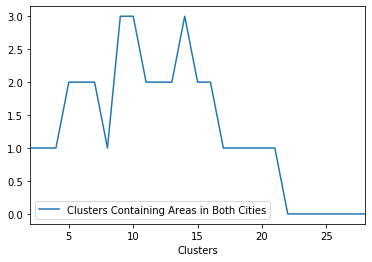

In [66]:
first=2
cluster_range = range(first,combo_grouped.shape[0])
clustering_results = [run_k_means_on_combo(combo_grouped, k) for k in cluster_range]
mixed_clusters = [number_of_mixed_city_clusters(r) for r in clustering_results]
mixed_by_k = pd.DataFrame(mixed_clusters, index=pd.Series(cluster_range, name="Clusters"), columns=["Clusters Containing Areas in Both Cities"])
mixed_by_k.plot()

##### Show the number of clusters in the models that have 3 clusters containing neighborhoods in both cities

In [67]:
mixed_by_k[mixed_by_k["Clusters Containing Areas in Both Cities"] == 3]

,Clusters Containing Areas in Both Cities
Clusters,
9,3
10,3
14,3


#### The best result is probably the one that has the fewest clusters but the most clusters containing neighborhoods in both cities

In [68]:
nclusters = 9
best_result = clustering_results[nclusters-first]
for i in range(nclusters):
    print("\n\nCLUSTER NUMBER: {}\n".format(i))
    condition = best_result['Cluster Labels'] == i
    print (best_result[condition][["Borough", "Neighborhood_y"]])



CLUSTER NUMBER: 0

             Borough                                     Neighborhood_y
9   Downtown Toronto                               Church and Wellesley
26  Downtown Toronto                           Ryerson, Garden District
4   Downtown Toronto                                 Central Bay Street
0   Downtown Toronto                           Adelaide, King, Richmond
21  Downtown Toronto  Harbourfront East, Toronto Islands, Union Station
11  Downtown Toronto           Design Exchange, Toronto Dominion Centre
10  Downtown Toronto                     Commerce Court, Victoria Hotel
28  Downtown Toronto                    Stn A PO Boxes 25 The Esplanade
17  Downtown Toronto             First Canadian Place, Underground city
13       Ville-Marie  Downtown Montreal North (McGill University), G...
12       Ville-Marie                             Downtown Montreal East


CLUSTER NUMBER: 1

             Borough                  Neighborhood_y
20  Downtown Toronto                    H

###### Make df_with_bor the same as the output of the model with the best value of k

In [69]:
df_with_bor = best_result

### Make bar charts and tables that show the results of the clustering

For clusters that have neighborhoods in both cities, create bar charts that show the occurances of common types of venues.

For clusters that only have neighborhood(s) in one city, create tables that show the most common types of venues in those neighborhoods. This will help show why those neighborhoods did not have counterparts in the other city. This will help the end user see what's special about those neighborhoods.

##### Make a set that has the top ten categories types in each cluster

In [70]:
venue_set = set()
for row in df_with_bor.iloc[:,3:].values:
    venue_set = venue_set.union(row)
print (len(venue_set))

110


##### Make a Series that has the frequencies of occurrance of the venues in all of the neighborhoods

In [71]:
venue_counts = pd.value_counts(combo_venues['Venue Category'].values)
venue_counts.sort_values(ascending=False,inplace=True)
venue_counts.head(10)

Coffee Shop            164
Café                   101
Hotel                   78
Restaurant              55
Bakery                  46
Italian Restaurant      42
Japanese Restaurant     33
French Restaurant       32
Bar                     30
Sandwich Place          29
dtype: int64

##### Make a Series with the 9 most-frequent venue types that are in venue_set
I noticed that 3 types of venues are tied for tenth place, and I don't want the bar graphs to have more than 10 columns, so I am just using the 9 most common venue types.

In [72]:
important_venues = venue_counts.loc[venue_set].sort_values(ascending=False).head(9).index.to_list()
important_venues

['Coffee Shop',
 'Café',
 'Hotel',
 'Restaurant',
 'Bakery',
 'Italian Restaurant',
 'Japanese Restaurant',
 'French Restaurant',
 'Bar']

### Define Functions for Getting Information From the Clusters based on Cluster Number and Borough

In [73]:
def neighborhoods_in_cluster(i, df_with_bor):
    ''' Return a Series containing the Neighborhoods that are in cluster i'''
    return (df_with_bor.loc[df_with_bor['Cluster Labels'] == i].loc[:, "Neighborhood_y"])

In [74]:
def venue_and_venue_counts_for_cluster(i, combo_onehot, df_with_bor):
    ''' For cluster i, return a Series where the index is venue category and the value is number of venues in that catagory'''
    combo_onehot_for_cluster = pd.merge(combo_onehot, neighborhoods_in_cluster(i, df_with_bor), left_on="Neighborhood_y", right_on="Neighborhood_y")
    return (combo_onehot_for_cluster.sum())
#venue_and_venue_counts_for_cluster(0, combo_onehot, df_with_bor)

In [75]:
def neighborhoods_in_cluster_and_borough(i, b, df_with_bor):
    ''' Return a Series containing the Neighborhoods that are in cluster i and in borough b'''
    condition1 = df_with_bor['Cluster Labels'] == i
    condition2 = df_with_bor['Borough'] == b
    cluster_rows = df_with_bor.loc[condition1]
    right_rows = cluster_rows.loc[condition2]
    return (right_rows.loc[:, "Neighborhood_y"])
results_for_checking = neighborhoods_in_cluster_and_borough(3, "Downtown Toronto", df_with_bor)
if (len(results_for_checking)==5): print("Function works")
else: print("Function doesn't work")

Function works


In [76]:
def venue_and_venue_counts_for_cluster_and_borough(i, b, combo_onehot, df_with_bor):
    ''' For cluster i and borough b, return a Series where the index is venue category and the value is number of venues in that catagory'''
    combo_onehot_for_cluster = pd.merge(combo_onehot, neighborhoods_in_cluster_and_borough(i, b, df_with_bor), left_on="Neighborhood_y", right_on="Neighborhood_y")
    #print(combo_onehot_for_cluster)
    return (combo_onehot_for_cluster.sum())
#vs = venue_and_venue_counts_for_cluster_and_borough(1, "Ville-Marie", combo_onehot, df_with_bor)
#vs = venue_and_venue_counts_for_cluster_and_borough(1, "Downtown Toronto", combo_onehot, df_with_bor)
#vs[vs != 0]

In [77]:
vs = venue_and_venue_counts_for_cluster_and_borough(1, "Ville-Marie", combo_onehot, df_with_bor)

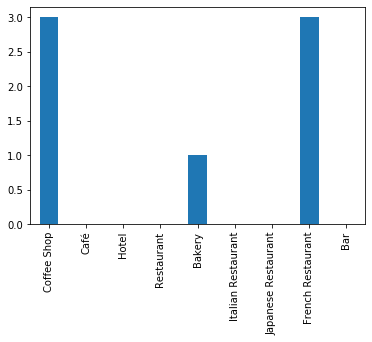

In [78]:
vs.loc[important_venues].plot(kind="bar")

#### Define a function for making side-by-side bar charts of the number of popular venues in clustes that contain both Cities

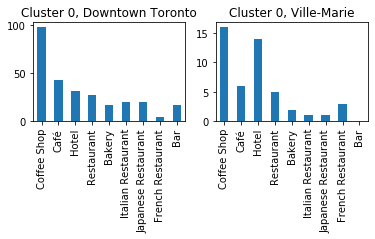

In [79]:
import matplotlib.pyplot as plt

def plot_cluster_by_borough(c, combo_onehot, df_with_bor):
    subplot_index = 1
    for b in (["Downtown Toronto", "Ville-Marie"]):
        plt.subplot(2,2,subplot_index)
        plt.title("Cluster {}, {}".format(c, b))
        vs = venue_and_venue_counts_for_cluster_and_borough(c, b, combo_onehot, df_with_bor)
        vs.loc[important_venues].plot(kind="bar")
        subplot_index += 1
    plt.show()
    
plot_cluster_by_borough(0, combo_onehot, df_with_bor)

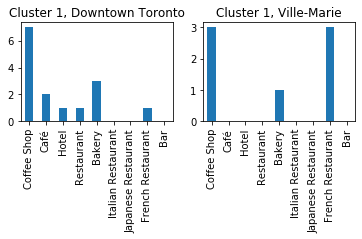

In [80]:
plot_cluster_by_borough(1, combo_onehot, df_with_bor)

#### Define a function for printing information about clusters that only have locations in one city

In [81]:
def print_cluster_info(c, combo_onehot, df_with_bor):
    condition = df_with_bor['Cluster Labels'] == c
    b = df_with_bor[condition]["Borough"].iloc[0]
    print("Cluster {}, {}".format(c, b))
    neighborhoods = pd.Series(df_with_bor[condition]["Neighborhood_y"].unique())
    suffix = ("s" if len(neighborhoods)>1 else "")
    print ("Neighborhood group{}: {}".format(suffix, neighborhoods.str.cat(sep=", ")))
    vs = venue_and_venue_counts_for_cluster(c, combo_onehot, df_with_bor)
    non_zero_vs = vs.loc[vs!=0][1:]
    print("\t{:<30}{:>5}".format("Venue Type", "Count"))
    for i in range(len(non_zero_vs)):
        print("\t{:<30}{:5}".format(non_zero_vs.index[i], non_zero_vs.values[i]))

# print_cluster_info(4, combo_onehot, df_with_bor)

#### Define a function for displaying useful information about a cluster whether it contains locations in one city or two

In [82]:
def show_cluster_info(c, combo_onehot, df_with_bor):
    if (len(df_with_bor.loc[df_with_bor['Cluster Labels'] == c].loc[:,"Borough"].unique()) == 2):
        plot_cluster_by_borough(c, combo_onehot, df_with_bor)
    else:
        return(print_cluster_info(c, combo_onehot, df_with_bor))

### Cluster 0, which where coffee shops, cafes, hotels, and restaurants are most popular, especially coffee shops

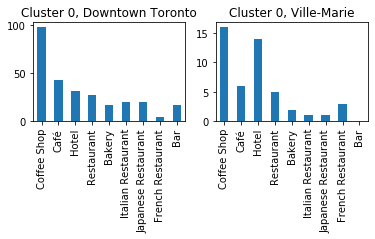

In [83]:
show_cluster_info(0, combo_onehot, df_with_bor)

### Cluster 1, which where coffee shops are popular, but bakeries are also popular, and hotels and cafes aren't so popular

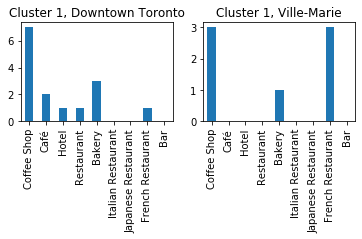

In [84]:
show_cluster_info(1, combo_onehot, df_with_bor)

### Cluster 2, where outdoor venues are popular, and which only has a presence in one city

In [85]:
show_cluster_info(2, combo_onehot, df_with_bor)

Cluster 2, Downtown Toronto
Neighborhood group: Rosedale
	Venue Type                    Count
	Park                              2
	Playground                        1
	Trail                             1


### Cluster 3, where cafes are more popular than coffee shops, and where all 9 of the most popular venues types are well represented
Diversity of venue types is valued here.

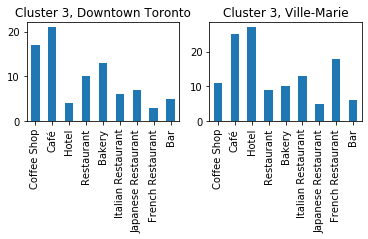

In [86]:
show_cluster_info(3, combo_onehot, df_with_bor)

In [87]:
show_cluster_info(4, combo_onehot, df_with_bor)

Cluster 4, Ville-Marie
Neighborhood group: Downtown Montreal Southwest, Shaughnessy Village, part of Mount Royal Park
	Venue Type                    Count
	Bus Stop                          1
	Historic Site                     1
	Lake                              1
	Mountain                          1


### Cluster 5, which is only represented in one city, and has a disproportionate number of coffee shops

In [88]:
show_cluster_info(5, combo_onehot, df_with_bor)

Cluster 5, Downtown Toronto
Neighborhood group: Queen's Park
	Venue Type                    Count
	Arts & Crafts Store               1
	Bar                               1
	Beer Bar                          1
	Burger Joint                      1
	Burrito Place                     1
	Café                              1
	Chinese Restaurant                1
	Coffee Shop                      11
	College Auditorium                1
	Creperie                          1
	Diner                             1
	Fast Food Restaurant              1
	Fried Chicken Joint               1
	Gym                               2
	Hobby Shop                        1
	Italian Restaurant                1
	Mexican Restaurant                1
	Music Venue                       1
	Nightclub                         1
	Park                              2
	Portuguese Restaurant             1
	Sandwich Place                    1
	Smoothie Shop                     1
	Sushi Restaurant                  1
	Theater      

### Cluster 6, which is only represented in one city, and which contains venues popular at airports
Ville-Marie doesn't have an airport, so that fact that this cluster is in only one city isn't surprising.

In [89]:
show_cluster_info(6, combo_onehot, df_with_bor)

Cluster 6, Downtown Toronto
Neighborhood group: CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
	Venue Type                    Count
	Airport                           1
	Airport Food Court                1
	Airport Lounge                    2
	Airport Service                   3
	Airport Terminal                  2
	Bar                               1
	Boat or Ferry                     1
	Boutique                          1
	Harbor / Marina                   1
	Plane                             1
	Rental Car Location               1
	Sculpture Garden                  1


### Cluster 7, which is only represented in one city, and doesn't contain coffee shops nor cafes

In [90]:
show_cluster_info(7, combo_onehot, df_with_bor)

Cluster 7, Ville-Marie
Neighborhood group: Centre-Sud South, Gay Village
	Venue Type                    Count
	Asian Restaurant                  1
	Beer Bar                          1
	Bike Rental / Bike Share          1
	Breakfast Spot                    1
	Caribbean Restaurant              1
	Cheese Shop                       1
	Concert Hall                      1
	Farmers Market                    1
	Fast Food Restaurant              1
	Gym                               1
	Hardware Store                    1
	History Museum                    1
	Hostel                            1
	Pharmacy                          1
	Plaza                             1
	Poutine Place                     1
	Restaurant                        2
	Supermarket                       1
	Thai Restaurant                   1


### Cluster 8, which is only represented in one city, and doesn't seem to have a lot of the most popular venues

In [91]:
show_cluster_info(8, combo_onehot, df_with_bor)

Cluster 8, Downtown Toronto
Neighborhood group: Christie
	Venue Type                    Count
	Athletics & Sports                1
	Baby Store                        1
	Café                              3
	Candy Store                       1
	Coffee Shop                       1
	Convenience Store                 1
	Diner                             1
	Grocery Store                     3
	Italian Restaurant                1
	Nightclub                         1
	Park                              2
	Restaurant                        1


### Note about the February 9 execution of this notebook compared with executions on previous dates

On the last run prior to February 9, the results were different. For example, there were 166 coffee shops instead of 164, and there were 99 Cafes instead of 101. There were 74 hotels instead of 78. In the report and presentation that I prepared for the Capstone project, I used results from a run prior to February 9. In those results, there were only two k-means results that had 3 clusters containing postal codes in both cities. They occured when k was 9 and when k was 15. In the February 9 run, there were 3 values of k that had 3 clusters containing postal codes in both cities (k=9, k=10, and k=14). k=9 fit the criteria for best value of k on February 9 and on dates prior to February 9. The characterizations of the clusters were the same on February 9 and on prior dates. For this reason, I haven't changed the report to use the February 9 results. Since I haven't changed the report, I haven't changed the presentation.

# End of Notebook